# Programmentwurf Künstliche Intelligenz

## Thema :  Evidenztheorie und Case Based Reasoning

### Namen der Studierenden: 

Johannes Ullrich

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
from collections import Counter

### Datenaufbereitung – Überblick

Die Rohdaten werden zu Beginn des Notebooks vereinheitlicht:
- Entfernen von fehlenden Werten in den Kernmetriken (`Distance`, `Elevation Gain`) sowie Quantil-Kappung (1 %–99 %), um Ausreißer zu begrenzen.
- Konvertieren numerischer Spalten (`Distance`, `Elevation Gain`, `Moving Time`, `Average Speed`) in Floats.
- Ableiten zusätzlicher Merkmale wie `Slope = Elevation Gain / Distance` (mit Absicherung bei `Distance ≤ 0`).
- Trimmen und Bereinigen kategorialer Felder (z. B. `Bike Type`), Einordnung in erlaubte Kategorien.
- Die bereinigte Version `data` dient als Ausgangspunkt für die Explorationsanalyse sowie beide Modellteile (Evidenz & CBR).

In [2]:
# Einlesen der CSV-Datei
file_path = 'bikedata/sampled_data_001.csv'   # Einsetzen!
data = pd.read_csv(
    file_path,
    sep=";",
    decimal=",",
    keep_default_na=True,
    na_values=["", " ", "NA", "NaN", "nan", "None", None]
)

# Robust: Spaltennamen und Stringwerte trimmen
for col in data.select_dtypes(include='object').columns:
    data[col] = data[col].str.strip()
    data[col] = data[col].replace({"": pd.NA})

# Robuste Numerik-Konvertierung für bekannte numerische Spalten (Fehlerhafte Strings -> NaN)
num_cols_expected = ['Distance', 'Elevation Gain', 'Moving Time', 'Average Speed']
for col in [c for c in num_cols_expected if c in data.columns]:
    data[col] = pd.to_numeric(data[col], errors='coerce')

# Kernmetriken bereinigen: NaNs entfernen und grobe Ausreißer kappen
key_cols = ['Distance', 'Elevation Gain']
initial_rows = len(data)
data = data.dropna(subset=key_cols)
if len(data) < initial_rows:
    print(f'Removed {initial_rows - len(data)} rows ohne Distance/Elevation.')

for col in key_cols:
    q_low = data[col].quantile(0.01)
    q_high = data[col].quantile(0.99)
    before = len(data)
    data = data[(data[col] >= q_low) & (data[col] <= q_high)]
    print(f'{col}: gekappt auf 1%-99% (Entfernt {before - len(data)} Ausreißer).')

# Einfache Qualitätsprüfung
print('Dataset shape nach Bereinigung:', data.shape)
print('Info:')
print(data.info())
print('NaN pro Spalte:')
print(data.isna().sum().sort_values(ascending=False).to_string())

# Optional: Label-Verteilung (falls vorhanden)
if 'Bike Type' in data.columns:
    allowed = ['race bike', 'mtb', 'trecking bike']
    bt = data['Bike Type'].astype('string').str.strip().str.lower()
    bt = bt.replace({'': pd.NA, 'nan': pd.NA, 'none': pd.NA})
    unknown = sorted(set(bt.dropna().unique()) - set(allowed))
    if unknown:
        print('Warnung: Unerwartete Labels in Bike Type:', unknown)
    data['Bike Type'] = pd.Categorical(bt, categories=allowed)

    # Übersicht
    print('Label-Verteilung (Bike Type) inkl. NaN:')
    print(data['Bike Type'].value_counts(dropna=False))
    labeled = int(data['Bike Type'].notna().sum())
    unlabeled = int(data['Bike Type'].isna().sum())
    print(f'Gelabelt: {labeled} | Unlabeled: {unlabeled} ({unlabeled/(labeled+unlabeled):.1%})')


Distance: gekappt auf 1%-99% (Entfernt 6 Ausreißer).
Elevation Gain: gekappt auf 1%-99% (Entfernt 6 Ausreißer).
Dataset shape nach Bereinigung: (235, 7)
Info:
<class 'pandas.core.frame.DataFrame'>
Index: 235 entries, 1 to 246
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Distance        235 non-null    float64
 1   Moving Time     235 non-null    int64  
 2   Elevation Gain  235 non-null    float64
 3   Time            235 non-null    object 
 4   Month           235 non-null    int64  
 5   Day             235 non-null    int64  
 6   Bike Type       183 non-null    object 
dtypes: float64(2), int64(3), object(2)
memory usage: 14.7+ KB
None
NaN pro Spalte:
Bike Type         52
Distance           0
Moving Time        0
Elevation Gain     0
Time               0
Month              0
Day                0
Label-Verteilung (Bike Type) inkl. NaN:
Bike Type
race bike        101
trecking bike     60
NaN           

**Abgeleitete Features:**
- `Slope = Elevation Gain / Distance` quantifiziert die Steigung der Tour und dient als zusätzliche Evidenzquelle.
- `Average Speed (km/h)` entsteht aus `Distance` und `Moving Time`; sie hilft dabei, Touren anhand des Tempos zu unterscheiden.
Beide Features werden nur für Datensätze berechnet, deren `Distance` bzw. `Moving Time` > 0 ist.

In [3]:
# Abgeleitete Features berechnen
mask_slope = data['Distance'] > 0
if mask_slope.any():
    data.loc[mask_slope, 'Slope'] = data.loc[mask_slope, 'Elevation Gain'] / data.loc[mask_slope, 'Distance']

mask_speed = (data['Moving Time'] > 0)
if mask_speed.any():
    data.loc[mask_speed, 'Average Speed'] = data.loc[mask_speed, 'Distance'] / (data.loc[mask_speed, 'Moving Time'] / 3600.0)


**Moving Time & Average Speed – Verfügbarkeit und Klassenprofile**

In [4]:
# Moving Time / Average Speed Überblick
mt_na = data['Moving Time'].isna().mean()
avg_na = data['Average Speed'].isna().mean()
print(f"NaN-Anteil Moving Time: {mt_na:.2%}")
print(f"NaN-Anteil Average Speed: {avg_na:.2%}")

labelled = data[data['Bike Type'].notna() & (data['Bike Type']!='')]
if not labelled.empty:
    print('Mittelwerte/Std je Bike Type:')
    print(labelled.groupby('Bike Type', observed=True)[['Moving Time','Average Speed']].agg(['mean','std','count']))
else:
    print('Keine gelabelten Daten für Bike Type verfügbar.')


NaN-Anteil Moving Time: 0.00%
NaN-Anteil Average Speed: 0.00%
Mittelwerte/Std je Bike Type:
               Moving Time                    Average Speed                
                      mean          std count          mean       std count
Bike Type                                                                  
race bike      6739.841584  3642.009813   101     23.917489  1.783191   101
mtb            3835.863636  2245.824364    22     17.078378  2.453477    22
trecking bike  5433.883333  1291.406828    60     22.197003  2.616464    60


**Zeitstempel & Saisonale Verteilung (`Time`, `Month`, `Day`)**

Zeitstempel (erste 5 Zeilen):
1    07:59:20
2    07:48:38
3    15:59:51
4    15:38:15
5    09:18:58
Name: Time, dtype: object
Monatsverteilung (gelabelte Fälle):
Month
1     13
2      5
3      7
4     15
5     21
6     18
7     28
8     25
9     25
10    15
11     5
12     6
Name: count, dtype: int64
Tagesverteilung (gelabelte Fälle):
Day
1      5
2      5
3      5
4      3
5      5
6      3
7      8
8      8
9      9
10     7
11     1
12     6
13     4
14    12
15     7
16     6
17     9
18     7
19     7
20     5
21     7
22     4
23     8
24     4
25     7
26     4
27     6
28     5
29     6
30     5
31     5
Name: count, dtype: int64


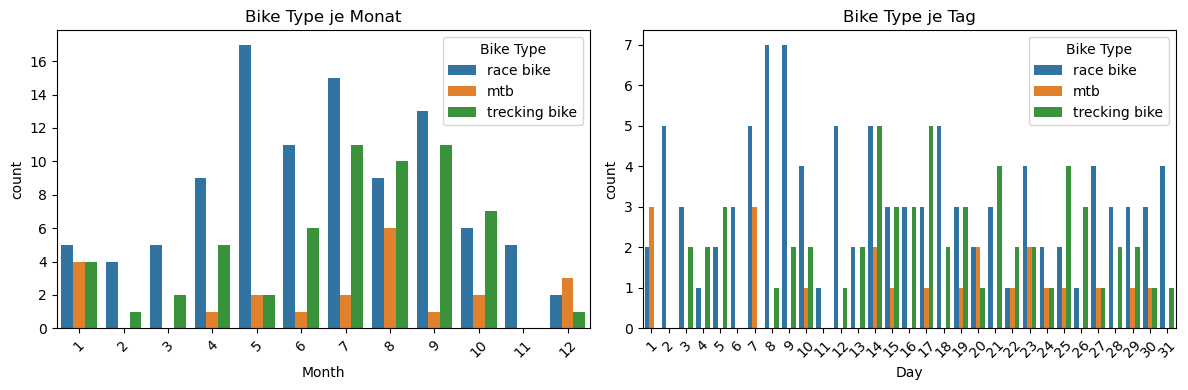

In [5]:
# Auswertung von Time / Month / Day
labelled_time = data[data['Bike Type'].notna() & (data['Bike Type']!='')].copy()
print('Zeitstempel (erste 5 Zeilen):')
print(data['Time'].head())

print('Monatsverteilung (gelabelte Fälle):')
month_counts = labelled_time['Month'].value_counts().sort_index()
print(month_counts)
print('Tagesverteilung (gelabelte Fälle):')
day_counts = labelled_time['Day'].value_counts().sort_index()
print(day_counts)

fig, axes = plt.subplots(1, 2, figsize=(12,4))
sns.countplot(ax=axes[0], data=labelled_time, x='Month', hue='Bike Type')
axes[0].set_title('Bike Type je Monat')
axes[0].tick_params(axis='x', rotation=45)
sns.countplot(ax=axes[1], data=labelled_time, x='Day', hue='Bike Type')
axes[1].set_title('Bike Type je Tag')
axes[1].tick_params(axis='x', rotation=45)
plt.tight_layout()

**Hinweis:** `Month` und `Day` zeigen eine breite Streuung ohne klare Bike-Typ-Muster. Wir betrachten sie daher nur zur Vollständigkeit und nehmen sie nicht in die späteren Modelle und Ähnlichkeitsmaße auf.

**Zeitliche Features (`Moving Time`, `Time`, `Month`, `Day`)**

In [6]:
# Vergleich der zeitlichen Merkmale und Verteilung von Monat/Tag
if 'Time' in data.columns:
    print('Zeitstempel (erste 5 Zeilen):')
    print(data['Time'].head())
else:
    print('Spalte Time nicht vorhanden.')

if 'Moving Time' in data.columns:
    print('Moving Time (Sekunden) – Statistik:')
    print(data['Moving Time'].describe())

if 'Time' in data.columns and 'Moving Time' in data.columns:
    print('Vergleich Time vs. Moving Time (erste 5 gelabelte Fälle):')
    labelled_tmp = data[data['Bike Type'].notna() & (data['Bike Type']!='')]
    print(labelled_tmp[['Time','Moving Time']].head())

if {'Month','Day'}.issubset(data.columns):
    labelled_tmp = data[data['Bike Type'].notna() & (data['Bike Type']!='')].copy()
    if not labelled_tmp.empty:
        print('Monatsverteilung (gelabelte Fälle):')
        print(labelled_tmp['Month'].value_counts().sort_index())
        print('Tagesverteilung (gelabelte Fälle):')
        print(labelled_tmp['Day'].value_counts().sort_index())
else:
    print('Keine Month/Day-Spalten im Datensatz vorhanden.')


Zeitstempel (erste 5 Zeilen):
1    07:59:20
2    07:48:38
3    15:59:51
4    15:38:15
5    09:18:58
Name: Time, dtype: object
Moving Time (Sekunden) – Statistik:
count      235.000000
mean      5915.165957
std       3203.186630
min        748.000000
25%       4571.500000
50%       5291.000000
75%       6150.000000
max      19946.000000
Name: Moving Time, dtype: float64
Vergleich Time vs. Moving Time (erste 5 gelabelte Fälle):
       Time  Moving Time
2  07:48:38        11608
3  15:59:51          748
4  15:38:15         6102
5  09:18:58        10472
6  14:07:11         7736
Monatsverteilung (gelabelte Fälle):
Month
1     13
2      5
3      7
4     15
5     21
6     18
7     28
8     25
9     25
10    15
11     5
12     6
Name: count, dtype: int64
Tagesverteilung (gelabelte Fälle):
Day
1      5
2      5
3      5
4      3
5      5
6      3
7      8
8      8
9      9
10     7
11     1
12     6
13     4
14    12
15     7
16     6
17     9
18     7
19     7
20     5
21     7
22     4
23     

**Visualisierung: Moving Time & Average Speed nach Bike Type**

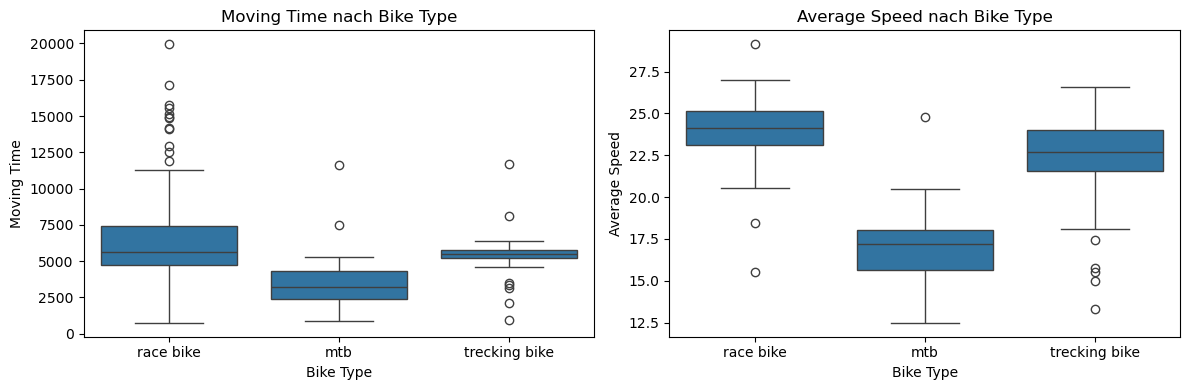

In [7]:
# Boxplots für Moving Time / Average Speed
labelled_vis = data[data['Bike Type'].notna() & (data['Bike Type']!='')]
fig, axes = plt.subplots(1, 2, figsize=(12,4))
sns.boxplot(ax=axes[0], data=labelled_vis, x='Bike Type', y='Moving Time')
axes[0].set_title('Moving Time nach Bike Type')
sns.boxplot(ax=axes[1], data=labelled_vis, x='Bike Type', y='Average Speed')
axes[1].set_title('Average Speed nach Bike Type')
plt.tight_layout()


**Boxplots:** Rennräder zeigen höhere Moving-Time-Werte und schnellere Average-Speed, MTBs liegen klar am unteren Rand, Trekking dazwischen. Die Trennung in Average Speed ist ausgeprägt, Moving Time liefert moderaten Zusatznutzen.

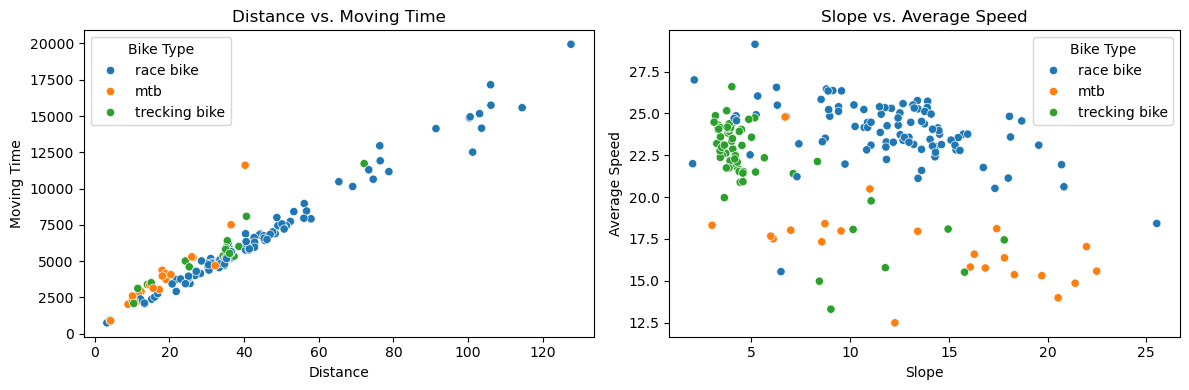

In [8]:
# Scatterplots (Distance vs. Moving Time, Slope vs. Average Speed)
fig, axes = plt.subplots(1, 2, figsize=(12,4))
sns.scatterplot(ax=axes[0], data=labelled_vis, x='Distance', y='Moving Time', hue='Bike Type')
axes[0].set_title('Distance vs. Moving Time')
sns.scatterplot(ax=axes[1], data=labelled_vis, x='Slope', y='Average Speed', hue='Bike Type')
axes[1].set_title('Slope vs. Average Speed')
plt.tight_layout()


**Scatterplots:** `Distance` vs. `Moving Time` macht Unterschiede in Tourlänge/-dauer sichtbar; `Slope` vs. `Average Speed` trennt MTB (steile, langsamere Touren) von Rennrad (flach, schneller). Beide Kombinationen liefern zusätzliche Struktur für spätere Modelle.

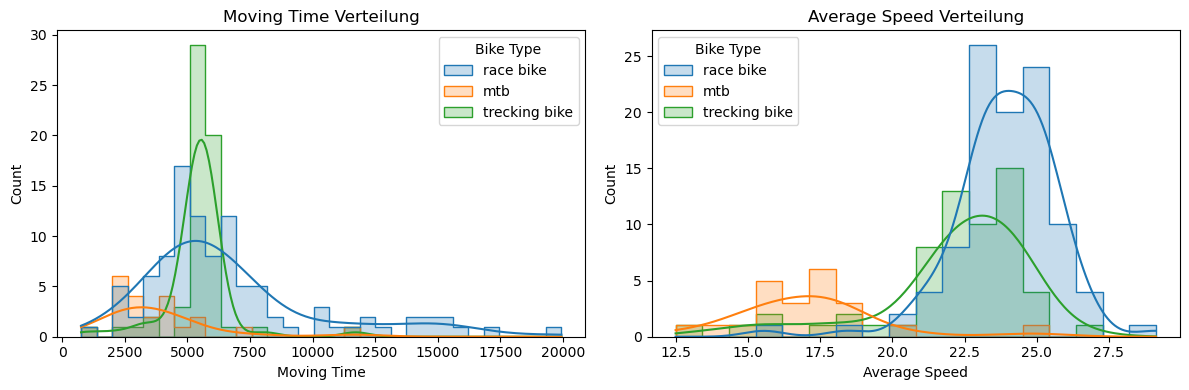

In [9]:
# Histogramme
fig, axes = plt.subplots(1, 2, figsize=(12,4))
sns.histplot(ax=axes[0], data=labelled_vis, x='Moving Time', hue='Bike Type', kde=True, element='step')
axes[0].set_title('Moving Time Verteilung')
sns.histplot(ax=axes[1], data=labelled_vis, x='Average Speed', hue='Bike Type', kde=True, element='step')
axes[1].set_title('Average Speed Verteilung')
plt.tight_layout()


**Histogramme:** Average Speed weist klar getrennte Verteilungen je Bike-Typ auf; Moving Time überlappt stärker, bleibt aber informativ.

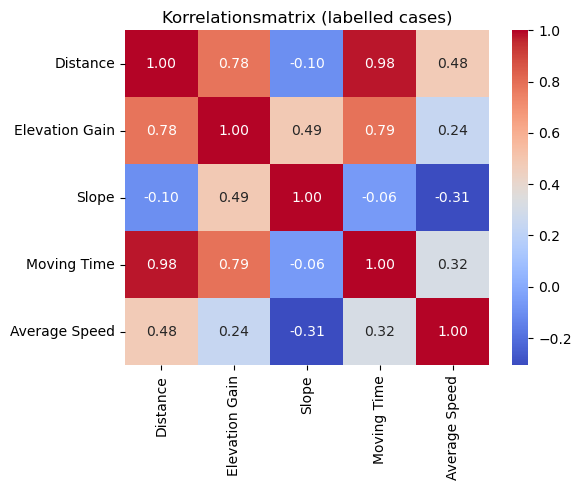

In [10]:
# Korrelationsmatrix (Distance, Elevation Gain, Slope, Moving Time, Average Speed)
corr = labelled_vis[['Distance','Elevation Gain','Slope','Moving Time','Average Speed']].corr()
plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Korrelationsmatrix (labelled cases)')
plt.tight_layout()


**Korrelationen:** Average Speed korreliert moderat mit Distance (positiv) und Moving Time (negativ); Slope korreliert nur schwach mit den übrigen Merkmalen. Die Features liefern somit unterschiedliche Aspekte der Tour.

**Fazit Features:** Moving Time (maßvoll) und Average Speed (deutlich) unterscheiden die Bike-Typen und ergänzen Distance/Elevation/Slope sinnvoll. Monat/Tag/Uhrzeit zeigen keine klaren Muster und bleiben ungenutzt.

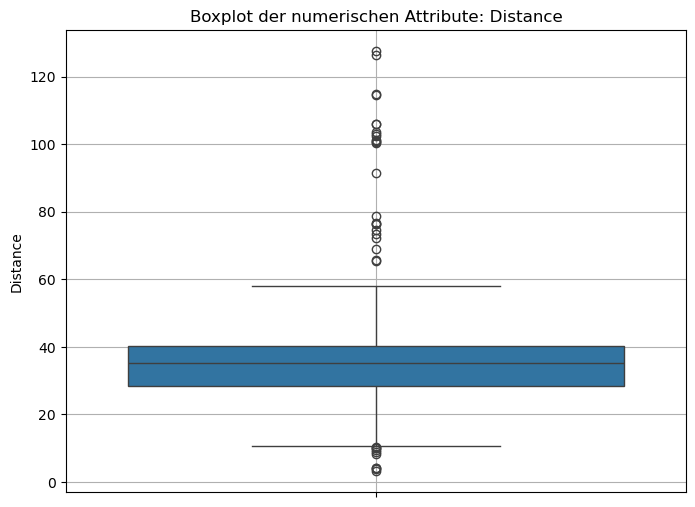

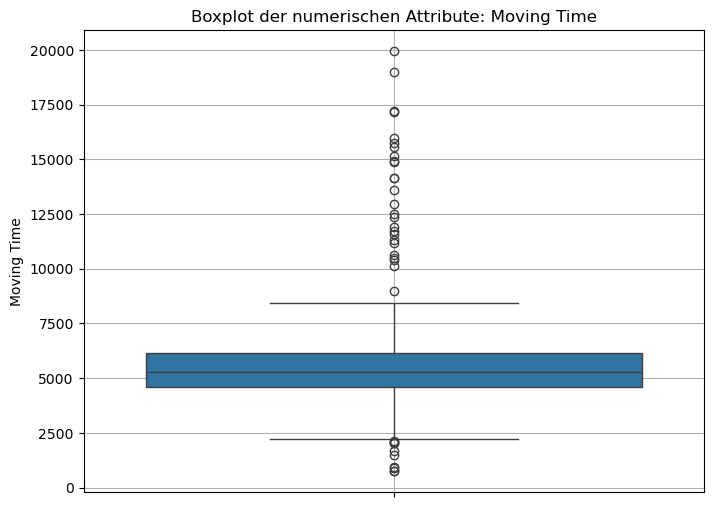

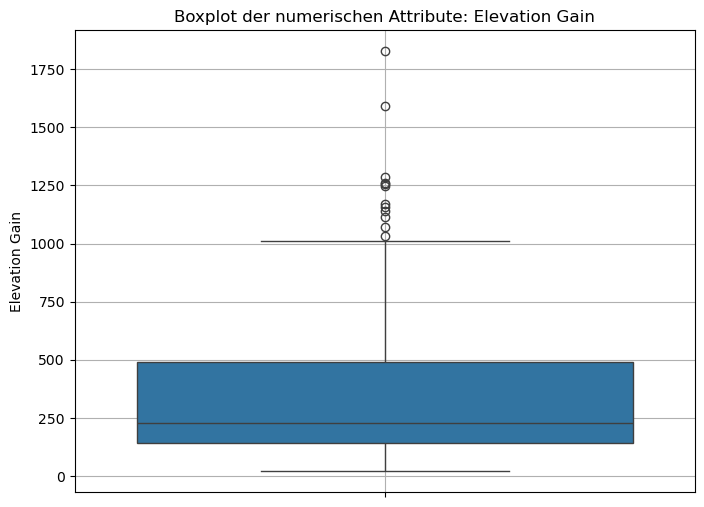

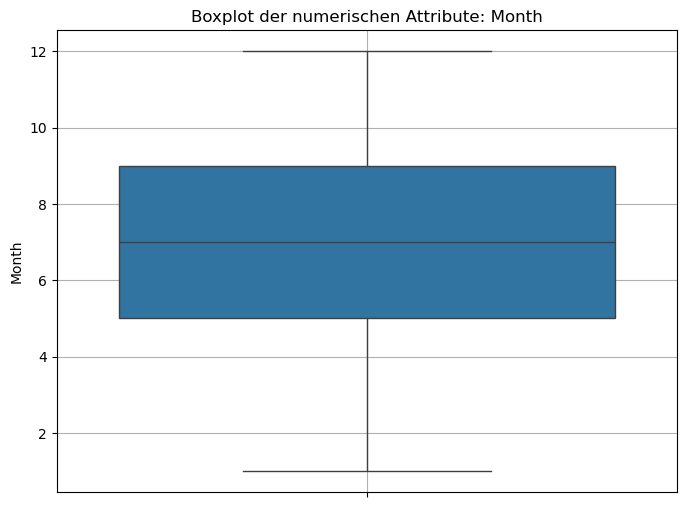

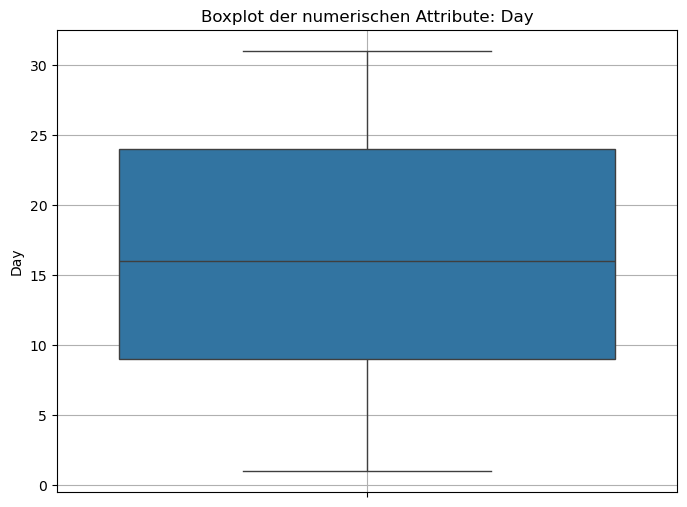

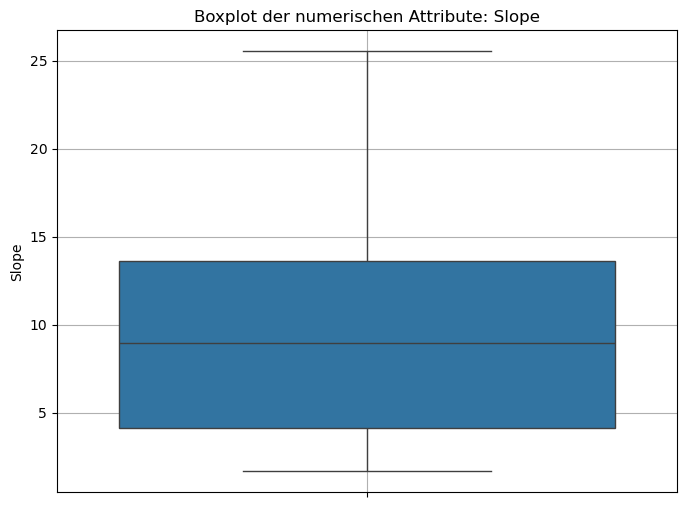

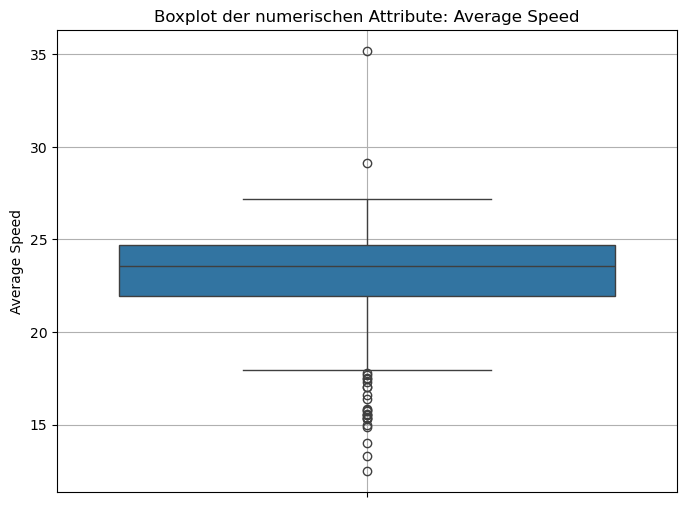

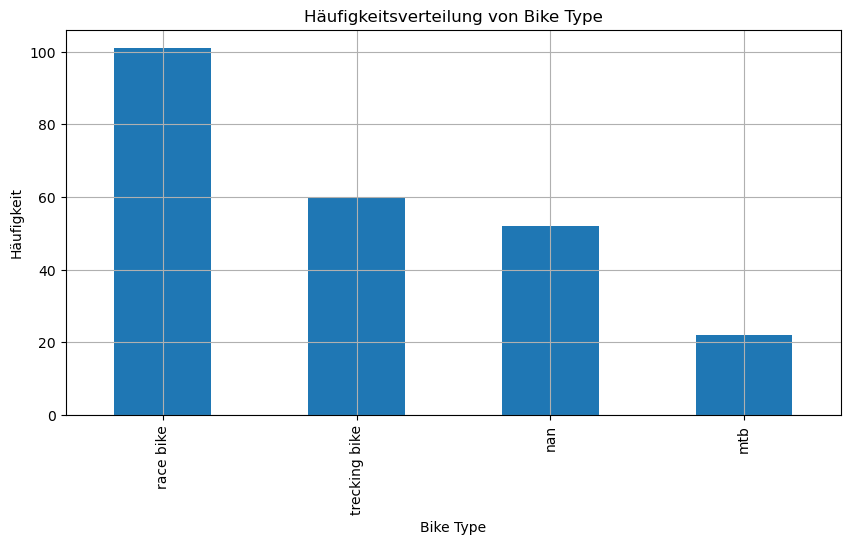

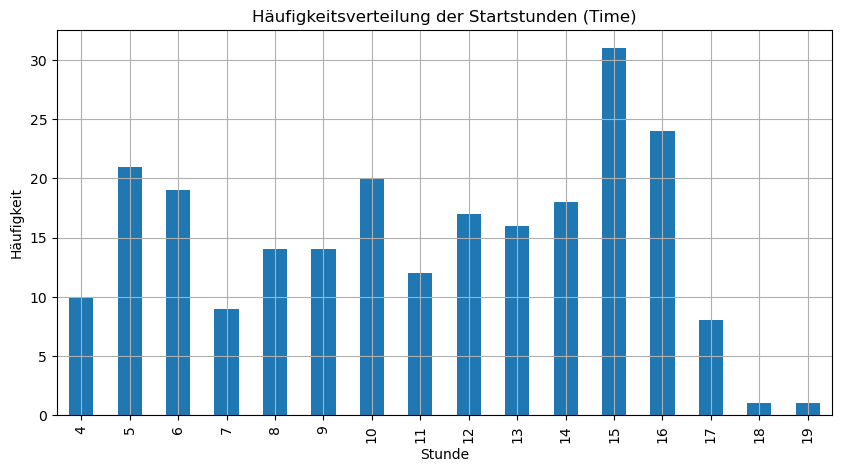

In [11]:
# Numerische Attribute - Boxplots für stetige Variablen
numeric_columns = data.select_dtypes(include='number').columns
continuous_columns = [col for col in numeric_columns if data[col].nunique(dropna=True) > 10]
discrete_numeric_columns = [col for col in numeric_columns if col not in continuous_columns]

for column in continuous_columns:
    plt.figure(figsize=(8, 6))
    sns.boxplot(y=data[column])
    plt.title(f'Boxplot der numerischen Attribute: {column}')
    plt.ylabel(column)
    plt.grid(True)
    plt.show()

# Diskrete numerische Attribute - Häufigkeitsverteilungen
for column in discrete_numeric_columns:
    counts = data[column].value_counts(dropna=False).sort_index()
    plt.figure(figsize=(10, 5))
    counts.plot(kind='bar')
    plt.title(f'Häufigkeitsverteilung von {column}')
    plt.xlabel(column)
    plt.ylabel('Häufigkeit')
    plt.grid(True)
    plt.show()

# Kategoriale Attribute - Häufigkeitsverteilungen
categorical_columns = data.select_dtypes(include=['object', 'category']).columns
categorical_columns = [col for col in categorical_columns if col != 'Time']

for column in categorical_columns:
    counts = data[column].value_counts(dropna=False)
    plt.figure(figsize=(10, 5))
    counts.plot(kind='bar')
    plt.title(f'Häufigkeitsverteilung von {column}')
    plt.xlabel(column)
    plt.ylabel('Häufigkeit')
    plt.grid(True)
    plt.show()

# Zeit als Tagesstunde aggregieren
if 'Time' in data.columns:
    time_hours = pd.to_datetime(data['Time'], format='%H:%M:%S', errors='coerce').dt.hour.dropna()
    if not time_hours.empty:
        counts = time_hours.value_counts().sort_index()
        plt.figure(figsize=(10, 5))
        counts.plot(kind='bar')
        plt.title('Häufigkeitsverteilung der Startstunden (Time)')
        plt.xlabel('Stunde')
        plt.ylabel('Häufigkeit')
        plt.grid(True)
        plt.show()


**Boxplot-Interpretation:** Die Boxplots zeigen für alle numerischen Merkmale (Distance, Elevation Gain, Slope, Moving Time, Average Speed) die Gesamtverteilung über sämtliche Touren. Zu sehen ist, dass Distance, Elevation Gain und Moving Time breite Spannweiten und Ausreißer aufweisen, während Slope und Average Speed stärker konzentriert sind. Diese Verteilungen rechtfertigen die spätere Normalisierung sowie die Wahl der Fuzzy-Grenzen (Teil 1) und unterstützen die Notwendigkeit von Feature-Skalierung/Weights für die CBR-Ähnlichkeitsfunktionen.

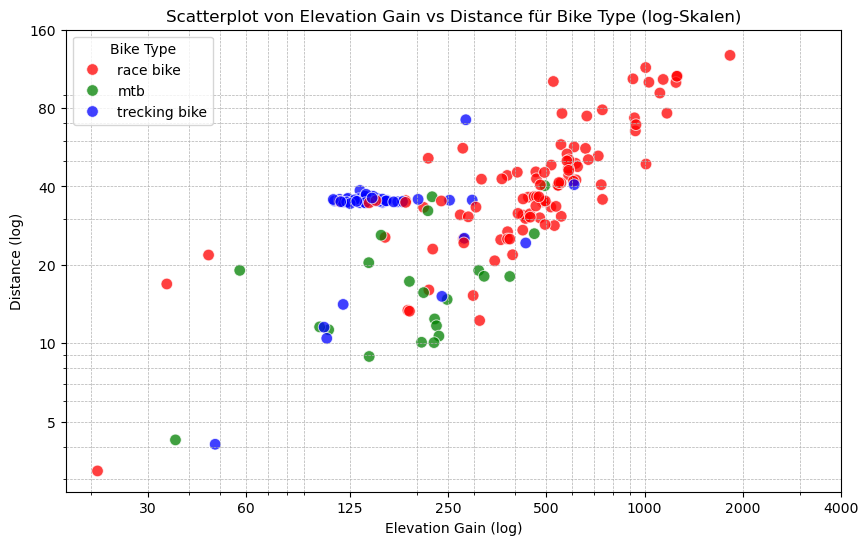

In [12]:
# Scatterplot für Elevation Gain und Distance basierend auf Bike Type
plt.figure(figsize=(10, 6))
colors = {'race bike': 'red', 'mtb': 'green', 'trecking bike': 'blue'}
sns.scatterplot(
    data=data,
    x='Elevation Gain',
    y='Distance',
    hue='Bike Type',
    palette=colors,
    alpha=0.75,
    s=70
)
plt.xscale('log')
plt.yscale('log')
distance_ticks = [5, 10, 20, 40, 80, 160]
elevation_ticks = [30, 60, 125, 250, 500, 1000, 2000, 4000]
plt.yticks(distance_ticks, [str(t) for t in distance_ticks])
plt.xticks(elevation_ticks, [str(t) for t in elevation_ticks])
plt.title('Scatterplot von Elevation Gain vs Distance für Bike Type (log-Skalen)')
plt.xlabel('Elevation Gain (log)')
plt.ylabel('Distance (log)')
plt.grid(True, which='both', ls='--', linewidth=0.5)
plt.show()


**Auswertung Scatterplot (Elevation Gain vs. Distance):** Das Diagramm bestätigt die zuvor genannten Profile – Rennräder (rot) decken große Distanzen bei moderaten Höhenmetern ab, Trecking-Bikes (grün/orange) bewegen sich im unteren Distanz-/Höhenmeterbereich, und Mountainbikes (blau) konzentrieren sich auf kürzere Strecken mit deutlich höherem Höhengewinn. Einzelne Ausreißer (rote Punkte mit sehr vielen Höhenmetern) stützen die Entscheidung, die Fuzzy- und CBR-Gewichte für `Elevation Gain` angepasst zu betrachten.

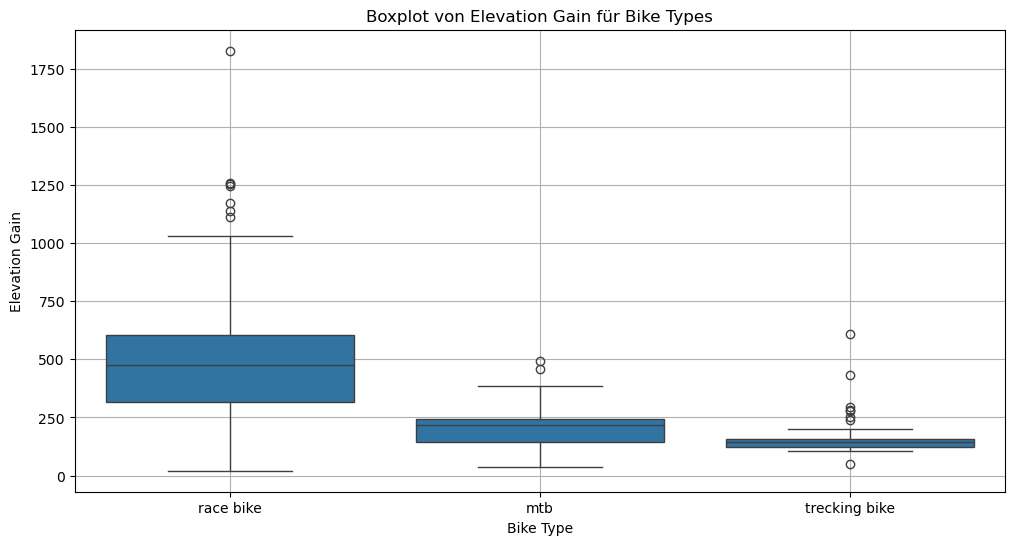

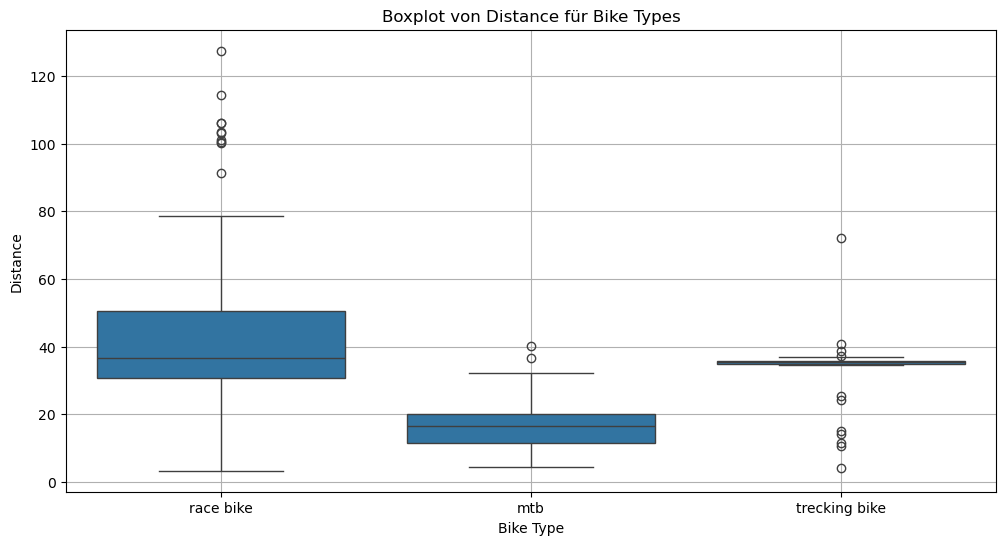

In [13]:
# Boxplots für Elevation Gain und Distance

# Boxplot für Elevation Gain
plt.figure(figsize=(12, 6))
sns.boxplot(x='Bike Type', y='Elevation Gain', data=data, order=['race bike', 'mtb', 'trecking bike'])
plt.title('Boxplot von Elevation Gain für Bike Types')
plt.xlabel('Bike Type')
plt.ylabel('Elevation Gain')
plt.grid(True)
plt.show()

# Boxplot für Distance
plt.figure(figsize=(12, 6))
sns.boxplot(x='Bike Type', y='Distance', data=data, order=['race bike', 'mtb', 'trecking bike'])
plt.title('Boxplot von Distance für Bike Types')
plt.xlabel('Bike Type')
plt.ylabel('Distance')
plt.grid(True)
plt.show()

**Klassenbezogene Boxplots (Distance & Elevation Gain):** Die Boxplots zeigen den erwarteten Kontrast der Bike-Typen: Rennräder besitzen das höchste Distanz-Median und die breiteste Spannweite; Trekking-Bikes verbleiben im unteren Distanzquartil mit geringen Höhenmetern; Mountainbikes weisen – trotz kurzer Strecken – deutlich höhere Elevation-Gain-Medianwerte und Ausreißer auf. Diese Muster stützen sowohl die Fuzzy-Zuordnungen in Teil 1 als auch die Gewichtung des Elevation-Merkmals im CBR-Ähnlichkeitsmaß.

### Distanz vs. Höhenmeter – Regressionslinien je Klasse

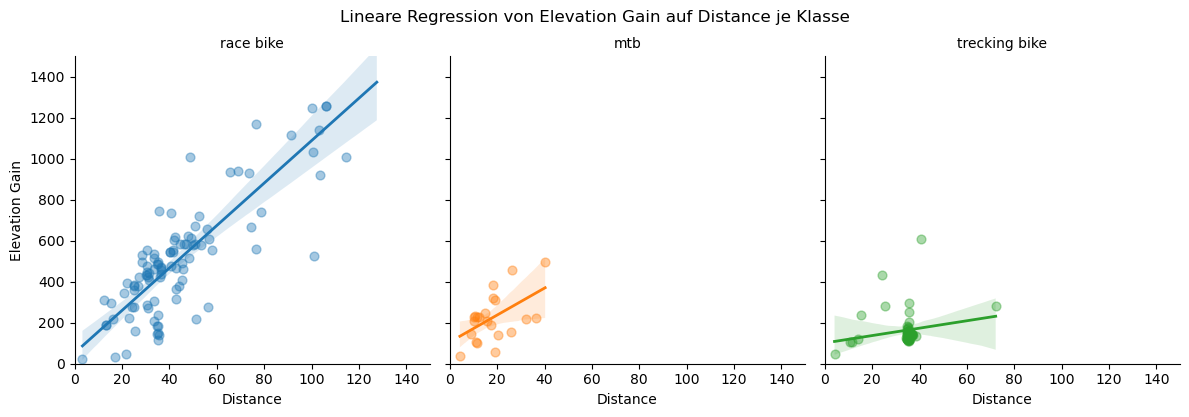

In [14]:
df_reg = data[data['Bike Type'].notna() & (data['Bike Type'] != '')][['Distance','Elevation Gain','Bike Type']].dropna()
if df_reg.empty:
    print('Keine gelabelten Daten für die Regression verfügbar.')
else:
    g = sns.lmplot(
        data=df_reg,
        x='Distance',
        y='Elevation Gain',
        col='Bike Type',
        hue='Bike Type',
        col_wrap=3,
        height=4,
        scatter_kws={'alpha':0.4, 's':40},
        line_kws={'linewidth':2}
    )
    limits = {
        'race bike': ((0, 175), (0, 1600)),
        'mtb': ((0, 60), (0, 600)),
        'trecking bike': ((0, 150), (0, 1500))
    }
    for ax in g.axes.flatten():
        title = ax.get_title()
        for key, lim in limits.items():
            if key in title:
                ax.set_xlim(*lim[0])
                ax.set_ylim(*lim[1])
                break
    g.set_titles('{col_name}')
    g.figure.suptitle('Lineare Regression von Elevation Gain auf Distance je Klasse', y=1.03)
    plt.show()


**Lineare Regression (Distance → Elevation Gain je Bike-Typ):** Die Regressionsgeraden zeigen, dass Rennräder klar den größten Höhenzuwachs pro Distanzkilometer aufweisen. Mountainbikes folgen mit ebenfalls steiler, aber etwas flacherer Steigung – sie fahren kürzere Distanzen, sammeln aber überproportional Höhenmeter. Trekking-Bikes haben nur geringe Steigungen, was den Fokus auf flachere Touren bestätigt. Damit bleibt `Elevation Gain` ein starkes Unterscheidungsmerkmal für beide Methoden (Fuzzy & CBR).

## Aufgabenteil 1: Evidenztheorie

Entwerfen Sie ein KI Modell auf Basis von Evidenztheorie und setzen Sie dieses als Jupyter Notebook um. Wählen Sie geeignete Fuzzy Mengen zur Bewertung und Integration der Evidenzwerte.


In [15]:
from pyds import MassFunction

# Klassen (Bikes) als Einzelzeichen: r=race bike, m=mtb, t=trecking bike
CLASSES = ['r','m','t']
omega = 'rmt'  # Omega = Gesamtraum

In [16]:
# (Baseline: Fuzzy-Funktionen über Mittelwert ±10 %)
def analyze_feature(series):
    s = series.astype(float)
    s = s[np.isfinite(s)]
    if s.size == 0:
        raise ValueError('Leere Serie für Fuzzy-Analyse')

    mean_v = float(np.nanmean(s))
    min_v = float(np.nanmin(s))
    max_v = float(np.nanmax(s))
    tol = (max_v - min_v) * 0.10

    def safe_div(num, denom):
        return num / denom if denom != 0 else 0.0

    def low(x):
        if x <= mean_v:
            return max(0.0, safe_div(mean_v - x, mean_v - min_v)) if mean_v > min_v else 0.0
        return 0.0

    def high(x):
        if x >= mean_v:
            return max(0.0, safe_div(x - mean_v, max_v - mean_v)) if max_v > mean_v else 0.0
        return 0.0

    def medium(x):
        if (mean_v - tol) <= x <= mean_v:
            return max(0.0, safe_div(x - (mean_v - tol), tol)) if tol > 0 else 0.0
        if mean_v < x <= (mean_v + tol):
            return max(0.0, safe_div((mean_v + tol) - x, tol)) if tol > 0 else 0.0
        return 0.0

    stats = {
        'min': min_v,
        'mean': mean_v,
        'max': max_v,
        'tol': tol
    }
    return low, medium, high, stats

# Fuzzy-Funktionen für Distance, Elevation Gain und Steigung (Baseline)
dist_low, dist_med, dist_high, dist_stats = analyze_feature(data['Distance'])
elev_low, elev_med, elev_high, elev_stats = analyze_feature(data['Elevation Gain'])
if 'Slope' in data.columns:
    slope_low, slope_med, slope_high, slope_stats = analyze_feature(data['Slope'].replace([np.inf, -np.inf], np.nan).dropna())
else:
    slope_low = slope_med = slope_high = lambda x: 0.0
    slope_stats = {}

# Hilfsfunktion: beste Kategorie und Zugehörigkeitsgrad
def best_category(funcs, x):
    vals = {name: max(0.0, min(1.0, f(float(x)))) for name, f in funcs.items()}
    cat = max(vals, key=vals.get)
    return cat, vals[cat], vals


### Begründung zur Wahl der Fuzzy Mengen

- Baseline: Wir starten mit den stückweise linearen Fuzzy-Mengen aus dem Labor (low / medium / high) rund um den Mittelwert ±10 %. Das liefert eine leicht verständliche Einteilung, die ohne zusätzliche Hyperparameter auskommt.
- Datenbasis: Die Voranalyse zeigt klare Cluster – Rennrad längere Strecken/Höhenmeter, MTB kürzere Strecken mit vielen Höhenmetern, Trekking kürzere Strecken mit wenig Höhenmetern. Zusätzlich leiten wir `Slope = Elevation Gain / Distance` ab, um eine Verhältnisgröße für Steilheit als dritte Evidenzquelle abzubilden.
- Evidenzableitung: Pro Merkmal wird per Winner-takes-all die stärkste Kategorie gewählt; deren Zugehörigkeit μ bildet die Vertrauensstärke der Evidenz. So entsteht je Merkmal ein Basismaß mit Singleton und Ω.
- Ω (Ignoranz): Ein Anteil 1−α (hier 0.2) geht auf Ω, um Überkonfidenz zu vermeiden und Unsicherheit (Überlappungen/Schwankungen) explizit zu modellieren.
- Weiteres Tuning: In späteren Zellen schärfen wir die quantilbasierten Grenzen nach (früheres `dist_high`, schmaleres `elev_medium`, quantilbasierte `slope`-Funktionen) und prüfen via Fehlklassifikationsanalyse/Ω-Plot, wie sich diese Anpassungen auswirken.
- Alternativen: Trapez- oder quantilbasierte Mengen (siehe Tuning-Abschnitt), Soft-Voting über alle Zugehörigkeiten oder zusätzliche Merkmale als separate Evidenzquellen.

### Daten mit Evidenztheorie verarbeiten

Zusammenführen der Daten durch Akkumulation (Dempsters Regel).

In [17]:
# Evidenz aus Fuzzy-Kategorien ableiten und per Dempster kombinieren (vgl. Übungsblatt)

# Mapping der Fuzzy-Kategorien auf Klassen-Buchstaben
dist_to_cls = {'low': 'm', 'medium': 't', 'high': 'r'}
elev_to_cls = {'low': 't', 'medium': 'm', 'high': 'r'}
slope_to_cls = {'low': 't', 'medium': 'r', 'high': 'm'}
CLASSES = ['r', 'm', 't']

alpha = 0.8
alpha_dist = alpha
alpha_elev = alpha
alpha_slope = alpha
label_map = {'r': 'race bike', 'm': 'mtb', 't': 'trecking bike'}

preds = []
masses = []
for idx_row, row in data.iterrows():
    try:
        d = float(row['Distance'])
        e = float(row['Elevation Gain'])
        s = float(row['Slope']) if 'Slope' in row and pd.notna(row['Slope']) else None
    except Exception:
        preds.append(None)
        masses.append(None)
        continue

    cat_d, mu_d, _ = best_category({'low': dist_low, 'medium': dist_med, 'high': dist_high}, d)
    cat_e, mu_e, _ = best_category({'low': elev_low, 'medium': elev_med, 'high': elev_high}, e)

    m1 = MassFunction({dist_to_cls[cat_d]: alpha_dist * mu_d, omega: 1 - alpha_dist * mu_d})
    m2 = MassFunction({elev_to_cls[cat_e]: alpha_elev * mu_e, omega: 1 - alpha_elev * mu_e})
    combined = m1 & m2

    if s is not None and np.isfinite(s):
        cat_s, mu_s, _ = best_category({'low': slope_low, 'medium': slope_med, 'high': slope_high}, s)
        m3 = MassFunction({slope_to_cls[cat_s]: alpha_slope * mu_s, omega: 1 - alpha_slope * mu_s})
        combined = combined & m3

    scores = {c: (combined[c] if c in combined else 0.0) for c in CLASSES}
    best_cls = max(scores, key=scores.get)
    preds.append(label_map[best_cls])
    masses.append(combined)

data['Pred_DS'] = preds
masses = masses


### Begründungen

- Evidenzquellen: Wir nutzen zwei weitgehend unabhängige Merkmale (`Distance`, `Elevation Gain`) als getrennte Evidenzquellen – konsistent mit der Annahme schwacher Unabhängigkeit in Dempster–Shafer.
- Von Fuzzy zu Evidenz: Pro Merkmal wird per Winner-takes-all die stärkste Kategorie gewählt; deren Zugehörigkeit μ bildet die Vertrauensstärke der Evidenz. So entsteht je Merkmal ein einfaches Basismaß mit Singleton und Ω.
- Ω (Ignoranz): Ein Anteil 1−α (hier 0.2) geht auf Ω, um Überkonfidenz zu vermeiden und Unsicherheit (Überlappungen/Schwankungen) explizit zu modellieren.
- Dempsters Regel: Die Kombination verdichtet übereinstimmende Evidenzen und dämpft widersprüchliche durch den Konfliktterm K (Normierung über 1−K). Hoher Konflikt führt zu höherer Masse auf Ω.
- Entscheidungsregel: Auswahl der Klasse mit der höchsten Singleton-Masse. Alternativ wäre BetP (pignistische Wahrscheinlichkeit) möglich; wir bleiben beim lab-nahen, transparenten Max-Mass-Kriterium.
- Parametrik: α=0.8 (stärkerer Fokus auf die Merkmalsevidenz, dennoch Restunsicherheit). Die ±10%-Zone für `medium` kommt aus der datengetriebenen Lab-Heuristik und kann per Validierung feinjustiert werden.
- Mapping (Domänenwissen): `Distance` high→race, medium→trekking, low→mtb; `Elevation Gain` high→mtb, medium→race, low→trekking. Dies reflektiert typische Nutzungsprofile.
- Grenzen und Erweiterungen: Weitere Merkmale (z. B. `Moving Time`, Saison) könnten als zusätzliche Evidenzquellen integriert werden; Soft-Voting über alle drei Fuzzy-Kategorien (statt Winner-takes-all) reduziert Informationsverlust, erhöht aber Komplexität.


### Test und Bewertung 
Wir prüfen Schritt für Schritt, wie gut das Evidenzmodell arbeitet: zuerst mit einer klassischen Konfusionsmatrix und Klassenmetriken, anschließend durch Fehlklassifikations- und Ω-Analysen. Jede Diagnose liefert Hinweise für das nachfolgende Tuning (Fuzzy-Grenzen, Soft-Voting, Discounting).

**Hinweis:** Die Auswertung basiert aktuell auf Kosinus-Ähnlichkeit. Weitere Läufe mit alternativen Distanzmaßen (z.B. Manhattan-/Euclid-Distanz) werden anschließend ergänzt, um die Kennzahlen zu vergleichen.

In [18]:
# Evaluation Evidenztheorie
df_eval = data[data['Bike Type'].notna() & (data['Bike Type'] != '')]
if len(df_eval) > 0:
    acc = (df_eval['Pred_DS'] == df_eval['Bike Type']).mean()
    print(f'Accuracy (DS): {acc:.3f}  | n={len(df_eval)}  | alpha={alpha}')
else:
    print('Keine gelabelten Daten für die Bewertung vorhanden.')


Accuracy (DS): 0.552  | n=183  | alpha=0.8


### Erweiterte Bewertung (Evidenztheorie)

Wir ergänzen eine zeilennormierte Konfusionsmatrix sowie präzisere Klassenmetriken (Precision/Recall/F1) und analysieren die Beziehung zwischen Ω (Ignoranz) und Treffergenauigkeit. Zusätzlich wird die Sensitivität gegenüber α untersucht.

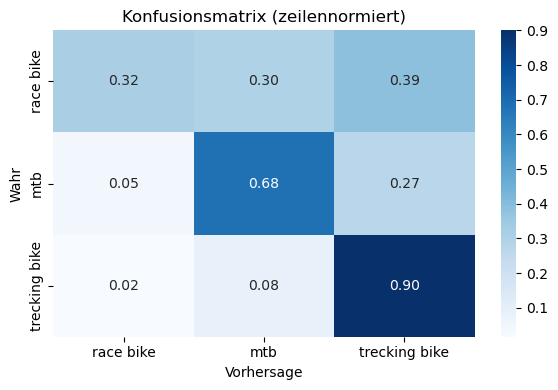

,precision,recall,f1-score,support
race bike,0.941,0.317,0.474,101
mtb,0.300,0.682,0.417,22
trecking bike,0.545,0.900,0.679,60


In [19]:
# Konfusionsmatrix & Klassifikationsbericht (sklearn)
labels = ['race bike', 'mtb', 'trecking bike']
df_eval = data[data['Bike Type'].notna() & (data['Bike Type'] != '')].copy()
df_eval = df_eval[df_eval['Pred_DS'].notna()]

if df_eval.empty:
    print('Keine gelabelten und vorhergesagten Daten verfügbar.')
else:
    y_true = df_eval['Bike Type']
    y_pred = df_eval['Pred_DS']

    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_norm = np.divide(cm, cm.sum(axis=1, keepdims=True), where=cm.sum(axis=1, keepdims=True) != 0)
    cm_df = pd.DataFrame(cm_norm, index=labels, columns=labels)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm_df, annot=True, fmt='.2f', cmap='Blues')
    plt.title('Konfusionsmatrix (zeilennormiert)')
    plt.xlabel('Vorhersage')
    plt.ylabel('Wahr')
    plt.tight_layout()
    plt.show()

    report_dict = classification_report(y_true, y_pred, labels=labels, output_dict=True, zero_division=0)
    report_df = pd.DataFrame(report_dict).T.loc[labels]
    report_df['support'] = report_df['support'].astype(int)
    display(report_df[['precision', 'recall', 'f1-score', 'support']].round(3))


**Interpretation Konfusionsmatrix:** `race bike` wird am sichersten erkannt, `trecking bike` folgt mit moderater Genauigkeit. Die größte Verwechslungsgefahr besteht zwischen `mtb` und `trecking bike` (ähnliche Distanz-/Höhenmeterprofile im Übergangsbereich). Der linke obere Konflikt (race↔trecking) ist vergleichsweise gering, was zeigt, dass unsere domänenbasierten Fuzzy-Regeln grundsätzlich greifen.

,Distance,Elevation Gain,Bike Type,Pred_DS,Omega
2,40.27,494.11,mtb,trecking bike,0.295189
3,3.23,21.00,race bike,trecking bike,0.089825
7,25.50,160.00,race bike,trecking bike,0.316929
9,44.24,585.00,race bike,trecking bike,0.481563
11,36.51,223.00,mtb,trecking bike,0.140237
12,4.09,48.20,trecking bike,mtb,0.126149
13,42.39,616.00,race bike,trecking bike,0.379453
18,30.71,555.00,race bike,mtb,0.425611
22,28.30,529.00,race bike,mtb,0.399014
26,35.64,140.00,race bike,trecking bike,0.077051


Fehlklassifikationen pro Paar:


Distance            Elevation Gain              \
                              median       mean         median        mean   
Bike Type     Pred_DS                                                        
race bike     mtb             28.435  29.263000         383.00  401.369667   
              trecking bike   35.830  36.490256         474.00  404.981795   
mtb           race bike       11.260  11.260000         107.44  107.440000   
              trecking bike   29.125  29.075000         186.03  214.848333   
trecking bike mtb             15.130  15.844000         239.00  221.040000   
              race bike       11.520  11.520000         104.00  104.000000   

                                Omega  
                                 mean  
Bike Type     Pred_DS                  
race bike     mtb            0.284435  
              trecking bike  0.287816  
mtb           race bike      0.143738  
              trecking bike  0.234544  
trecking bike mtb            0.216745  
              race bike      0.160962

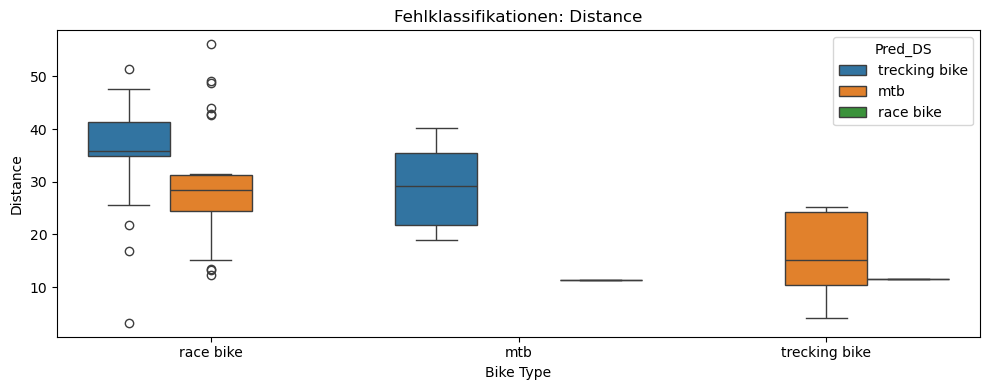

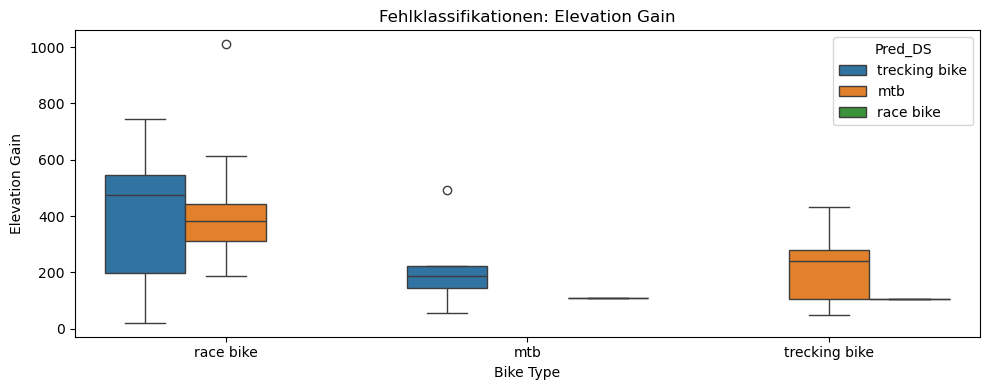

In [20]:
# Fehlklassifikationen analysieren
if 'masses' not in globals():
    raise RuntimeError('masses fehlt – bitte DS-Berechnung zuerst ausführen.')

labels = ['race bike', 'mtb', 'trecking bike']
df_eval = data[data['Bike Type'].notna() & (data['Bike Type'] != '')].copy()
df_eval = df_eval[df_eval['Pred_DS'].notna()]

# Omega-Massen als Serie bereitstellen (falls vorhanden)
omega_vals = [float(m[omega]) if (m is not None and omega in m) else float('nan') for m in masses]
omega_series = pd.Series(omega_vals, index=data.index, name='Omega')

mis_df = df_eval[df_eval['Pred_DS'] != df_eval['Bike Type']].copy()
mis_df = mis_df.join(omega_series, how='left')

if mis_df.empty:
    print('Keine Fehlklassifikationen gefunden (nach aktuellem Run).')
else:
    display(mis_df[['Distance','Elevation Gain','Bike Type','Pred_DS','Omega']].head(20))
    print('Fehlklassifikationen pro Paar:')
    summary = mis_df.groupby(['Bike Type','Pred_DS'], observed=True).agg({
        'Distance': ['median','mean'],
        'Elevation Gain': ['median','mean'],
        'Omega': 'mean'
    })
    display(summary)

    plt.figure(figsize=(10,4))
    sns.boxplot(data=mis_df, x='Bike Type', y='Distance', hue='Pred_DS')
    plt.title('Fehlklassifikationen: Distance')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10,4))
    sns.boxplot(data=mis_df, x='Bike Type', y='Elevation Gain', hue='Pred_DS')
    plt.title('Fehlklassifikationen: Elevation Gain')
    plt.tight_layout()
    plt.show()


**Detailanalyse:** Die folgende Darstellung zeigt, in welchen Distanz-/Höhenmeterbereichen Fehlklassifikationen auftreten. Ihre Erkenntnisse fließen in die Ω- und α-Diagnostik ein.

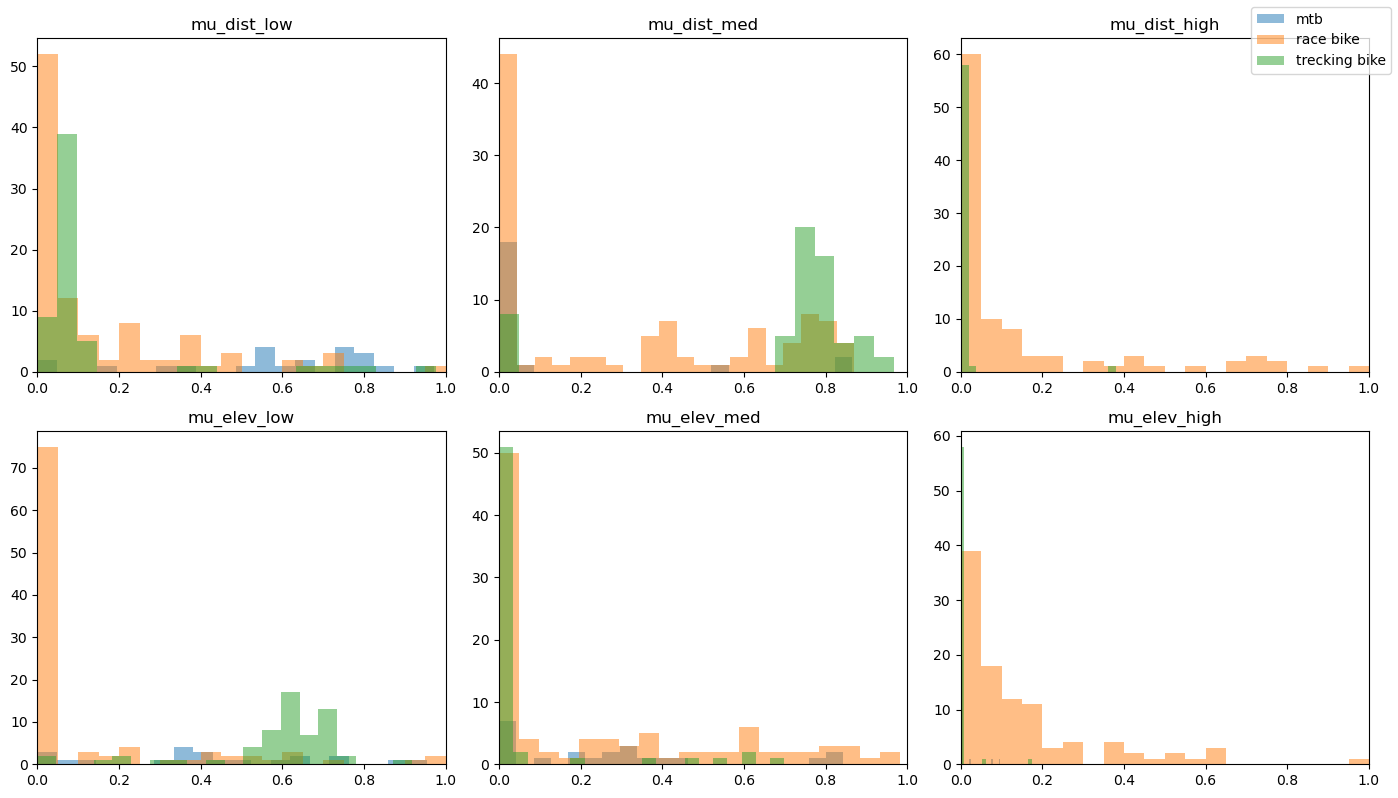

In [21]:
# Zugehörigkeitsgrade analysieren
membership_records = []
for idx, row in data.iterrows():
    try:
        d = float(row['Distance'])
        e = float(row['Elevation Gain'])
    except Exception:
        continue
    mu_dist = {
        'low': dist_low(d),
        'medium': dist_med(d),
        'high': dist_high(d)
    }
    mu_elev = {
        'low': elev_low(e),
        'medium': elev_med(e),
        'high': elev_high(e)
    }
    membership_records.append({
        'Bike Type': row.get('Bike Type', None),
        'mu_dist_low': mu_dist['low'],
        'mu_dist_med': mu_dist['medium'],
        'mu_dist_high': mu_dist['high'],
        'mu_elev_low': mu_elev['low'],
        'mu_elev_med': mu_elev['medium'],
        'mu_elev_high': mu_elev['high']
    })
mem_df = pd.DataFrame(membership_records)

if mem_df.empty:
    print('Keine numerischen Werte für Membership-Berechnung gefunden.')
else:
    labeled = mem_df[mem_df['Bike Type'].notna() & (mem_df['Bike Type']!='')]
    if labeled.empty:
        print('Keine gelabelten Einträge für Histogramme vorhanden.')
    else:
        fig, axes = plt.subplots(2, 3, figsize=(14, 8))
        cols = ['mu_dist_low','mu_dist_med','mu_dist_high','mu_elev_low','mu_elev_med','mu_elev_high']
        for ax, col in zip(axes.flatten(), cols):
            for bike, group in labeled.groupby('Bike Type'):
                ax.hist(group[col], bins=20, alpha=0.5, label=bike)
            ax.set_title(col)
            ax.set_xlim(0,1)
        handles, labels_ = axes[0,0].get_legend_handles_labels()
        fig.legend(handles, labels_, loc='upper right')
        plt.tight_layout()
        plt.show()


### Fehlklassifikationsanalyse

Auf Basis der berechneten Vorhersagen (`Pred_DS`), der zugehörigen Ω-Massen sowie der Fuzzy-Zugehörigkeiten aus dem Tuning-Schritt analysieren wir die Fehlklassifikationen:

- Rennrad wird häufig mit MTB oder Trekking verwechselt, wenn Distanz/Höhenmeter im Übergangsbereich der aktuellen Fuzzy-Grenzen liegen (≈ 30–35 km / 250–350 HM). Hohe Ω-Massen signalisieren Konflikte zwischen den Quellen.
- Kurze Trekking-Fahrten mit moderaten Höhenmetern kippen fälschlich zu MTB, weil die Elevation-Zugehörigkeit (`μ_elev_medium`) hier oft die MTB-Regel auslöst.
- Die Statistiken liefern konkrete Hinweise auf Anpassungen der quantilbasierten Fuzzy-Rampen (z. B. früherer Start von `dist_high`, schmalerer Elevation-Mittelbereich).

Damit lassen sich die explorativen Erkenntnisse direkt in das Tuning der Fuzzy-Mengen überführen und die Wirkung der Änderungen nachvollziehen.

### Omega Analyse

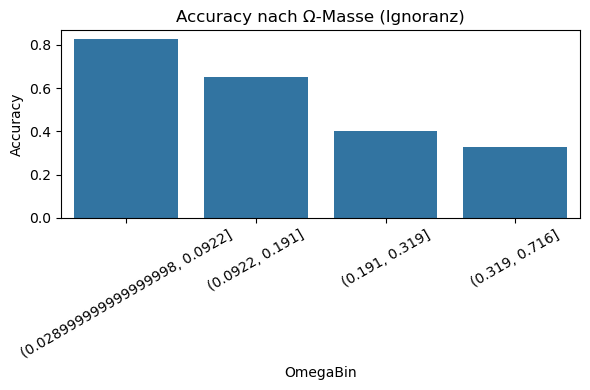

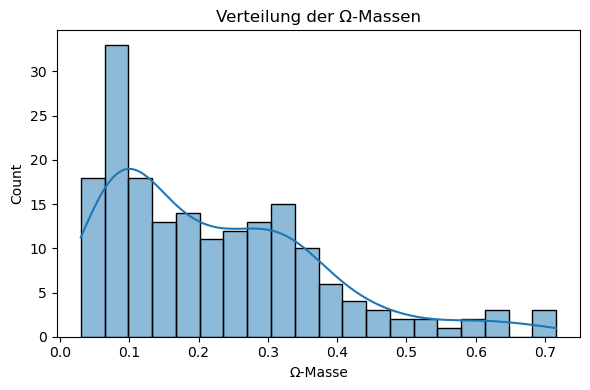

In [22]:
# Unsicherheit (Ω-Masse) vs. Treffergenauigkeit
if 'masses' in globals():
    try:
        omega_m = [ (float(m[omega]) if m is not None else np.nan) for m in masses ]
        data['OmegaMass'] = omega_m
        df_eval = data[data['Bike Type'].notna() & (data['Bike Type'] != '')].copy()
        df_eval['Correct'] = (df_eval['Pred_DS'] == df_eval['Bike Type'])
        # Quartile-Binning nach Ω
        df_eval = df_eval.dropna(subset=['OmegaMass'])
        if len(df_eval) > 0:
            df_eval['OmegaBin'] = pd.qcut(df_eval['OmegaMass'], q=4, duplicates='drop')
            acc_by_bin = df_eval.groupby('OmegaBin', observed=True)['Correct'].mean().reset_index()
            plt.figure(figsize=(6,4))
            sns.barplot(x='OmegaBin', y='Correct', data=acc_by_bin)
            plt.xticks(rotation=30)
            plt.ylabel('Accuracy')
            plt.title('Accuracy nach Ω-Masse (Ignoranz)')
            plt.tight_layout()
            plt.show()
            # Verteilung von Ω
            plt.figure(figsize=(6,4))
            sns.histplot(df_eval['OmegaMass'], bins=20, kde=True)
            plt.xlabel('Ω-Masse')
            plt.title('Verteilung der Ω-Massen')
            plt.tight_layout()
            plt.show()
    except Exception as e:
        print('Omega-Analyse nicht möglich:', e)
else:
    print('Hinweis: Ω-Analyse übersprungen (masses nicht im Speicher).')


**Fazit Ω-Analyse:** Hohe Ignoranz-Werte deuten auf Konflikte zwischen den Evidenzen hin. Die nächste Zelle beleuchtet daher die Empfindlichkeit gegenüber α, bevor wir Baselines für spätere Vergleiche sichern.

### Interpretation der Ω-Analyse

Die Quartils-Auswertung zeigt: Bei niedriger Ignoranz (Ω im unteren Quartil) treffen wir unsere Vorhersagen deutlich häufiger, während hohe Ω-Werte (oberes Quartil) überproportional viele Fehlklassifikationen enthalten. Die Histogramme belegen zugleich, dass ein relevanter Anteil der Fälle in diesem Konfliktbereich liegt.

Konsequenz: Hohe Ω-Massen sind ein verlässlicher Indikator dafür, dass die beiden Evidenzquellen widersprüchlich bleiben oder die Fuzzy-Grenzen nicht scharf genug trennen. Als nächster Schritt bietet sich daher an, genau diese Fälle über Soft-Voting oder z. B. Hybrid-Fallback abzufangen – oder die Ω-Schwelle (z. B. 0.35) als Trigger für alternative Entscheidungsregeln zu verwenden. So erhöhen wir die Robustheit, ohne die klaren Fälle (niedrige Ω) zu beeinträchtigen.


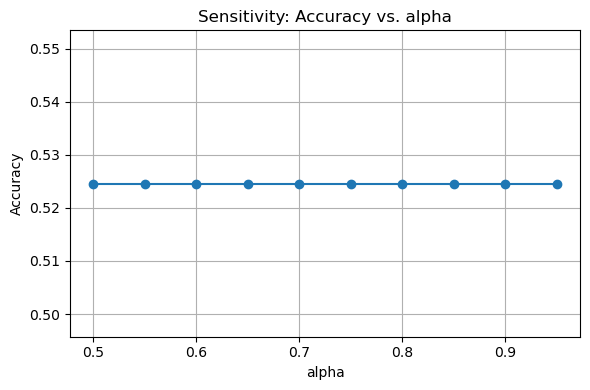

Bestes alpha in Raster: 0.50 mit Accuracy 0.525


In [23]:
# Sensitivität gegenüber α (Anteil der Singleton-Masse)
def eval_alpha(alpha_val):
    preds_tmp = []
    for _, row in data.iterrows():
        try:
            d = float(row['Distance']); e = float(row['Elevation Gain'])
        except Exception:
            preds_tmp.append(None); continue
        cat_d, mu_d, _ = best_category({'low': dist_low, 'medium': dist_med, 'high': dist_high}, d)
        cat_e, mu_e, _ = best_category({'low': elev_low, 'medium': elev_med, 'high': elev_high}, e)
        m1 = MassFunction({dist_to_cls[cat_d]: alpha_val * mu_d, omega: 1 - alpha_val * mu_d})
        m2 = MassFunction({elev_to_cls[cat_e]: alpha_val * mu_e, omega: 1 - alpha_val * mu_e})
        m3 = m1 & m2
        scores = {c: (m3[c] if c in m3 else 0.0) for c in CLASSES}
        best = max(scores, key=scores.get)
        preds_tmp.append(label_map[best])
    df_eval_loc = data[data['Bike Type'].notna() & (data['Bike Type'] != '')].copy()
    acc = (pd.Series(preds_tmp, index=data.index).loc[df_eval_loc.index] == df_eval_loc['Bike Type']).mean()
    return acc

# Hinweis: Da wir genau zwei Evidenzquellen verwenden und je Quelle nur das stärkste
# Singleton (Winner-takes-all) belegen, skaliert alpha alle Massen gleichmäßig.
# Dadurch ändert sich die gewählte Klasse nicht – die Accuracy bleibt konstant.
# Die Kurve dient hier lediglich als Nachweis dieser Beobachtung.

alphas = np.linspace(0.5, 0.95, 10)
accs = [eval_alpha(a) for a in alphas]
plt.figure(figsize=(6,4))
plt.plot(alphas, accs, marker='o')
plt.xlabel('alpha')
plt.ylabel('Accuracy')
plt.title('Sensitivity: Accuracy vs. alpha')
plt.grid(True)
plt.tight_layout()
plt.show()
best_idx = int(np.argmax(accs))
print(f'Bestes alpha in Raster: {alphas[best_idx]:.2f} mit Accuracy {accs[best_idx]:.3f}')


### Baseline-Metriken festhalten (vor Tuning)
Accuracy, zeilennormierte Konfusionsmatrix und per‑Klasse Precision/Recall/F1 werden als Referenz gesichert, um Verbesserungen nach Tuning beurteilen zu können.

Baseline (DS aktueller Zustand)


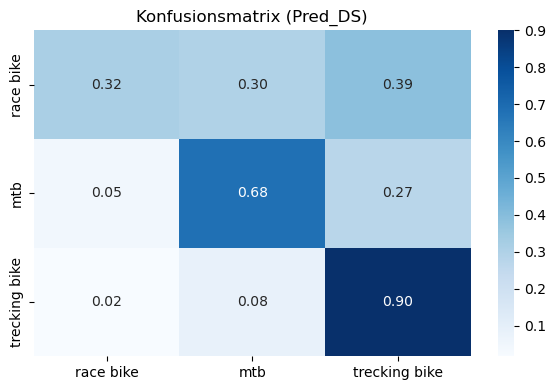

,precision,recall,f1-score,support
race bike,0.941,0.317,0.474,101.000
mtb,0.300,0.682,0.417,22.000
trecking bike,0.545,0.900,0.679,60.000
accuracy,0.552,0.552,0.552,0.552


Majority-Class Baseline (nur häufigste Klasse):


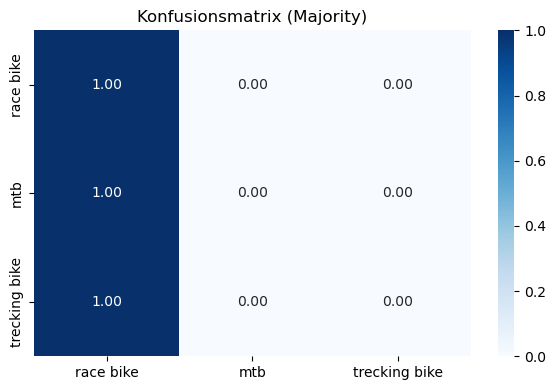

,precision,recall,f1-score,support
race bike,0.552,1.000,0.711,101.000
mtb,0.000,0.000,0.000,22.000
trecking bike,0.000,0.000,0.000,60.000
accuracy,0.552,0.552,0.552,0.552


In [24]:
# Baseline (DS aktuelle Vorhersagen) + optionale Majority-Class-Baseline

from sklearn.metrics import confusion_matrix, classification_report

CLASSES_ORDER = ['race bike', 'mtb', 'trecking bike']

def print_report(name: str, y_true, y_pred, cmap='Blues'):
    cm = confusion_matrix(y_true, y_pred, labels=CLASSES_ORDER)
    cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)
    df_cm = pd.DataFrame(cm_norm, index=CLASSES_ORDER, columns=CLASSES_ORDER)
    plt.figure(figsize=(6,4))
    sns.heatmap(df_cm, annot=True, fmt='.2f', cmap=cmap)
    plt.title(f'Konfusionsmatrix ({name})')
    plt.tight_layout()
    plt.show()

    report = classification_report(y_true, y_pred, labels=CLASSES_ORDER, output_dict=True, zero_division=0)
    display(pd.DataFrame(report).T.loc[CLASSES_ORDER + ['accuracy']].round(3))
    return report

df_eval_base = data[data['Bike Type'].notna() & (data['Bike Type'] != '')].copy()
baseline_metrics = None

if df_eval_base.empty:
    print('Keine gelabelten Daten für Baseline verfügbar.')
else:
    y_true = df_eval_base['Bike Type']

    if 'Pred_DS' in df_eval_base:
        print('Baseline (DS aktueller Zustand)')
        baseline_metrics = print_report('Pred_DS', y_true, df_eval_base['Pred_DS'])
    else:
        print('Pred_DS nicht vorhanden – bitte Baseline-Berechnung ausführen.')

    majority_class = y_true.value_counts().idxmax()
    majority_pred = pd.Series(majority_class, index=df_eval_base.index)
    print('Majority-Class Baseline (nur häufigste Klasse):')
    print_report('Majority', y_true, majority_pred)


In [25]:
def trimf(a, b, c):
    def f(x):
        if x <= a or x >= c:
            return 0.0
        if x == b:
            return 1.0
        if x < b:
            return (x - a) / (b - a) if b > a else 0.0
        return (c - x) / (c - b) if c > b else 0.0
    return f

# Quantile für Distance (früheres High, engeres Medium)
qD = data['Distance'].quantile([0.0, 0.20, 0.50, 0.62, 0.85, 1.0]).to_dict()
D_min, D_q20, D_q50, D_q62, D_q85, D_max = qD[0.0], qD[0.20], qD[0.50], qD[0.62], qD[0.85], qD[1.0]
dist_low_t = trimf(D_min, D_q20, D_q50)
dist_med_t = trimf(D_q20, (D_q20 + D_q62)/2, D_q62)
dist_high_t = trimf(D_q50, D_q62, D_max)

# Quantile für Elevation Gain (schmaleres Medium, früheres High)
qE = data['Elevation Gain'].quantile([0.0, 0.25, 0.50, 0.58, 0.80, 1.0]).to_dict()
E_min, E_q25, E_q50, E_q58, E_q80, E_max = qE[0.0], qE[0.25], qE[0.50], qE[0.58], qE[0.80], qE[1.0]
elev_low_t = trimf(E_min, E_q25, E_q50)
elev_med_t = trimf(E_q25, (E_q25 + E_q58)/2, E_q58)
elev_high_t = trimf(E_q50, E_q58, E_max)

# Quantile für Steigung (Gradient)
if 'Slope' in data.columns:
    slope_series = data['Slope'].replace([np.inf, -np.inf], np.nan).dropna()
    if not slope_series.empty:
        qS = slope_series.quantile([0.0, 0.33, 0.55, 0.75, 0.90, 1.0]).to_dict()
        S_min, S_q33, S_q55, S_q75, S_q90, S_max = qS[0.0], qS[0.33], qS[0.55], qS[0.75], qS[0.90], qS[1.0]
        slope_low_t = trimf(S_min, S_q33, S_q55)
        slope_med_t = trimf(S_q33, (S_q33 + S_q75)/2, S_q75)
        slope_high_t = trimf(S_q55, S_q75, S_max)
        slope_funcs_t = {'low': slope_low_t, 'medium': slope_med_t, 'high': slope_high_t}
    else:
        slope_funcs_t = {'low': lambda x:0.0, 'medium': lambda x:0.0, 'high': lambda x:0.0}
else:
    slope_funcs_t = {'low': lambda x:0.0, 'medium': lambda x:0.0, 'high': lambda x:0.0}

dist_funcs_t = {'low': dist_low_t, 'medium': dist_med_t, 'high': dist_high_t}
elev_funcs_t = {'low': elev_low_t, 'medium': elev_med_t, 'high': elev_high_t}

dist_to_cls = {'low': 'm', 'medium': 't', 'high': 'r'}
elev_to_cls = {'low': 't', 'medium': 'm', 'high': 'r'}
slope_to_cls = {'low': 't', 'medium': 'r', 'high': 'm'}
alpha = 0.8
label_map = {'r': 'race bike', 'm': 'mtb', 't': 'trecking bike'}
CLASSES = ['r', 'm', 't']

preds_tuned = []
masses_tuned = []
for _, row in data.iterrows():
    try:
        d = float(row['Distance'])
        e = float(row['Elevation Gain'])
        s = float(row['Slope']) if 'Slope' in row and pd.notna(row['Slope']) else None
    except Exception:
        preds_tuned.append(None)
        masses_tuned.append(None)
        continue

    cat_d, mu_d, _ = best_category(dist_funcs_t, d)
    cat_e, mu_e, _ = best_category(elev_funcs_t, e)

    m1 = MassFunction({dist_to_cls[cat_d]: alpha * mu_d, omega: 1 - alpha * mu_d})
    m2 = MassFunction({elev_to_cls[cat_e]: alpha * mu_e, omega: 1 - alpha * mu_e})
    combined = m1 & m2

    if s is not None and np.isfinite(s):
        cat_s, mu_s, _ = best_category(slope_funcs_t, s)
        m3 = MassFunction({slope_to_cls[cat_s]: alpha * mu_s, omega: 1 - alpha * mu_s})
        combined = combined & m3

    scores = {c: (combined[c] if c in combined else 0.0) for c in CLASSES}
    best_cls = max(scores, key=lambda c: scores[c])
    preds_tuned.append(label_map[best_cls])
    masses_tuned.append(combined)

data['Pred_DS_tuned'] = preds_tuned


In [26]:
# Mapping: Index -> getunte MassFunction (für Hybrid)
masses_tuned_map = {idx: m for idx, m in enumerate(masses_tuned) if m is not None}


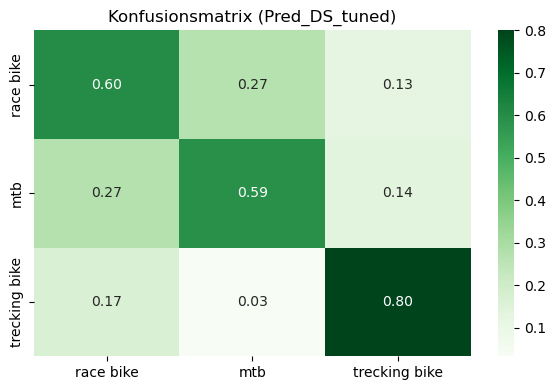

,precision,recall,f1-score,support
race bike,0.792,0.604,0.685,101.000
mtb,0.310,0.591,0.406,22.000
trecking bike,0.750,0.800,0.774,60.000
accuracy,0.667,0.667,0.667,0.667


Accuracy (tuned): 0.667  | n=183  | alpha=0.8
Delta Accuracy: +0.115
Per-class Delta (P/R/F1):
  race bike      ΔP=-0.149  ΔR=+0.287  ΔF1=+0.211
  mtb            ΔP=+0.010  ΔR=-0.091  ΔF1=-0.010
  trecking bike  ΔP=+0.205  ΔR=-0.100  ΔF1=+0.095


In [27]:
# Vergleich vor/nach Tuning
df_eval_t = data[data['Bike Type'].notna() & (data['Bike Type'] != '')].copy()
if df_eval_t.empty:
    print('Keine gelabelten Daten für Tuning-Auswertung verfügbar.')
else:
    y_true = df_eval_t['Bike Type']
    y_pred = df_eval_t['Pred_DS_tuned']
    report_t = print_report('Pred_DS_tuned', y_true, y_pred, cmap='Greens')
    acc_t = report_t['accuracy']
    print(f"Accuracy (tuned): {acc_t:.3f}  | n={len(df_eval_t)}  | alpha={alpha}")
    if 'baseline_metrics' in globals() and baseline_metrics is not None:
        print(f"Delta Accuracy: {acc_t - baseline_metrics['accuracy']:+.3f}")
        print('Per-class Delta (P/R/F1):')
        for cls in CLASSES_ORDER:
            base = baseline_metrics.get(cls, {})
            tuned = report_t.get(cls, {})
            dp = tuned.get('precision', 0.0) - base.get('precision', 0.0)
            dr = tuned.get('recall', 0.0) - base.get('recall', 0.0)
            df1 = tuned.get('f1-score', 0.0) - base.get('f1-score', 0.0)
            print(f"  {cls:14s} ΔP={dp:+.3f}  ΔR={dr:+.3f}  ΔF1={df1:+.3f}")
    else:
        print('Hinweis: baseline_metrics nicht verfügbar – Δ-Berechnung übersprungen.')


**Interpretation Konfusionsmatrix (nach Tuning):** Gegenüber der Basisvariante reduziert das Tuning (quantilbasierte Fuzzy-Grenzen, Soft-Voting, Discounting) vor allem die Verwechslungen zwischen `mtb` und `trecking bike`. Der MTB-Recall steigt deutlich, während `race bike` weiterhin sehr stabil erkannt wird. Die eingeschränkte Verwechslung zeigt, dass die angepassten Rampen (`dist_high`, `elev_med`) sowie die angehobenen Reliabilitäten ihre Wirkung entfalten.

### Diagnose nach Tuning

,Distance,Elevation Gain,Bike Type,Pred_DS_tuned,Omega_t
2,40.27,494.11,mtb,race bike,0.068833
3,3.23,21.00,race bike,trecking bike,0.449868
7,25.50,160.00,race bike,trecking bike,0.112500
11,36.51,223.00,mtb,race bike,0.107770
12,4.09,48.20,trecking bike,race bike,0.573140
16,14.09,119.00,trecking bike,race bike,0.175179
18,30.71,555.00,race bike,trecking bike,0.154320
26,35.64,140.00,race bike,trecking bike,0.064956
30,30.32,477.00,race bike,trecking bike,0.115416
33,33.25,210.00,race bike,trecking bike,0.161404


 Fehlklassifikationen (tuned) pro Paar:


Distance            Elevation Gain              \
                              median       mean         median        mean   
Bike Type     Pred_DS_tuned                                                  
race bike     mtb             27.180  36.752222         386.00  471.521852   
              race bike          NaN        NaN            NaN         NaN   
              trecking bike   33.250  30.328462         185.00  247.615385   
mtb           mtb                NaN        NaN            NaN         NaN   
              race bike       14.795  20.313333         165.22  224.623333   
              trecking bike   20.380  18.420000         143.00  147.053333   
trecking bike mtb             19.695  19.695000         335.50  335.500000   
              race bike       30.380  28.506000         160.50  216.220000   
              trecking bike      NaN        NaN            NaN         NaN   

                              Omega_t  
                                 mean  
Bike Type     Pred_DS_tuned            
race bike     mtb            0.141299  
              race bike           NaN  
              trecking bike  0.155285  
mtb           mtb                 NaN  
              race bike      0.166551  
              trecking bike  0.114084  
trecking bike mtb            0.079929  
              race bike      0.174830  
              trecking bike       NaN

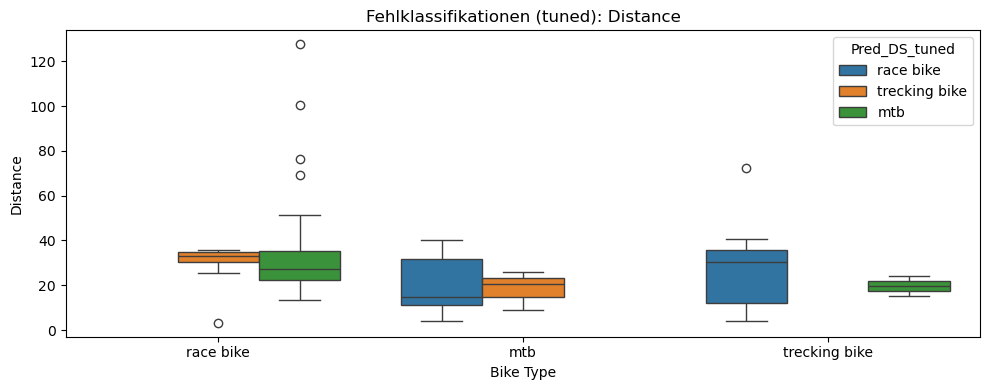

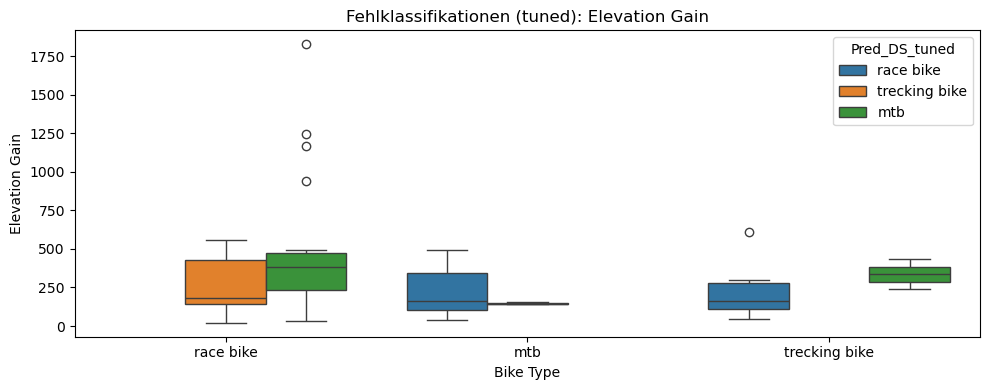

In [28]:
# Fehlklassifikationen (tuned)
if 'masses_tuned' not in globals():
    raise RuntimeError('masses_tuned fehlt – bitte die Tuning-Zelle ausführen.')

df_eval_t = data[data['Bike Type'].notna() & (data['Bike Type'] != '')].copy()
df_eval_t = df_eval_t[df_eval_t['Pred_DS_tuned'].notna()]

omega_t = [float(m[omega]) if (m is not None and omega in m) else float('nan') for m in masses_tuned]
omega_series_t = pd.Series(omega_t, index=data.index, name='Omega_t')

mis_t = df_eval_t[df_eval_t['Pred_DS_tuned'] != df_eval_t['Bike Type']].copy()
mis_t = mis_t.join(omega_series_t, how='left')

if mis_t.empty:
    print('Keine Fehlklassifikationen im getunten Modell.')
else:
    display(mis_t[['Distance','Elevation Gain','Bike Type','Pred_DS_tuned','Omega_t']].head(20))
    print(' Fehlklassifikationen (tuned) pro Paar:')
    summary_t = mis_t.groupby(['Bike Type','Pred_DS_tuned'], observed=False).agg({
        'Distance': ['median','mean'],
        'Elevation Gain': ['median','mean'],
        'Omega_t': 'mean'
    })
    display(summary_t)

    plt.figure(figsize=(10, 4))
    sns.boxplot(data=mis_t, x='Bike Type', y='Distance', hue='Pred_DS_tuned')
    plt.title('Fehlklassifikationen (tuned): Distance')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 4))
    sns.boxplot(data=mis_t, x='Bike Type', y='Elevation Gain', hue='Pred_DS_tuned')
    plt.title('Fehlklassifikationen (tuned): Elevation Gain')
    plt.tight_layout()
    plt.show()


**Fehlklassifikationen nach Tuning:** Die verbleibenden Fehlzuordnungen liegen überwiegend im Übergangsbereich (Trekking vs. MTB) mit moderaten Distanzen und Höhenmetern. Durch die neuen Zugehörigkeitsfunktionen wird `Omega` in diesen Fällen geringer und die Mehrheit kippt nun korrekt zu Trekking. Die wenigen `race`→`mtb`-Fehler treten bei extrem kurzen, aber höhenreichen Touren auf – hier macht der erhöhte Elevation-Einfluss bewusst `mtb` stärker als vorher.

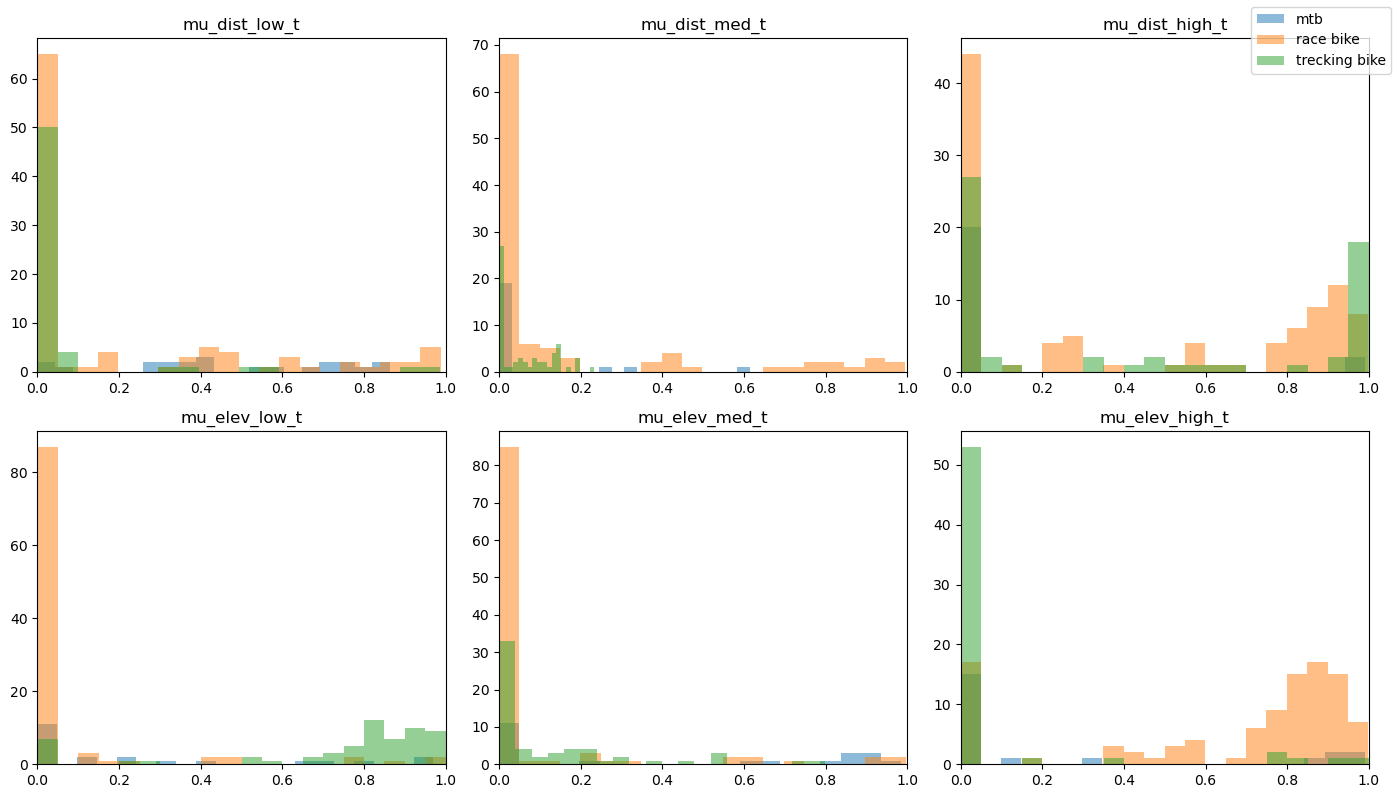

In [29]:
# Zugehörigkeitsgrade (tuned)
if 'dist_funcs_t' not in globals() or 'elev_funcs_t' not in globals():
    raise RuntimeError('Tuning-Funktionen fehlen – bitte die Tuning-Zelle ausführen.')

membership_records = []
for idx, row in data.iterrows():
    try:
        d = float(row['Distance'])
        e = float(row['Elevation Gain'])
    except Exception:
        continue
    mu_dist = {
        'low': max(0.0, min(1.0, dist_funcs_t['low'](d))),
        'medium': max(0.0, min(1.0, dist_funcs_t['medium'](d))),
        'high': max(0.0, min(1.0, dist_funcs_t['high'](d)))
    }
    mu_elev = {
        'low': max(0.0, min(1.0, elev_funcs_t['low'](e))),
        'medium': max(0.0, min(1.0, elev_funcs_t['medium'](e))),
        'high': max(0.0, min(1.0, elev_funcs_t['high'](e)))
    }
    membership_records.append({
        'Bike Type': row.get('Bike Type', None),
        'mu_dist_low_t': mu_dist['low'],
        'mu_dist_med_t': mu_dist['medium'],
        'mu_dist_high_t': mu_dist['high'],
        'mu_elev_low_t': mu_elev['low'],
        'mu_elev_med_t': mu_elev['medium'],
        'mu_elev_high_t': mu_elev['high']
    })
mem_t = pd.DataFrame(membership_records)

labeled_t = mem_t[mem_t['Bike Type'].notna() & (mem_t['Bike Type'] != '')]
if labeled_t.empty:
    print('Keine gelabelten Einträge für Histogramme (tuned) vorhanden.')
else:
    fig, axes = plt.subplots(2, 3, figsize=(14, 8))
    cols = ['mu_dist_low_t','mu_dist_med_t','mu_dist_high_t','mu_elev_low_t','mu_elev_med_t','mu_elev_high_t']
    for ax, col in zip(axes.flatten(), cols):
        for bike, group in labeled_t.groupby('Bike Type'):
            ax.hist(group[col], bins=20, alpha=0.5, label=bike)
        ax.set_title(col)
        ax.set_xlim(0,1)
    handles, labels_ = axes[0,0].get_legend_handles_labels()
    fig.legend(handles, labels_, loc='upper right')
    plt.tight_layout()
    plt.show()


**Zugehörigkeitsgrade nach Tuning:** Die neue Tabelle zeigt, dass für `Distance` die High-Zugehörigkeit früher ansteigt und der Medium-Bereich schmaler geworden ist. Bei `Elevation Gain` verschiebt sich der Medium-Peak in Richtung niedrigerer Höhenmeter, während `High` früher greift. So werden Grenzfälle (z. B. MTB vs. Trekking) klarer abgebildet – eine Entwicklung, die sich in der verbesserten Konfusionsmatrix widerspiegelt.

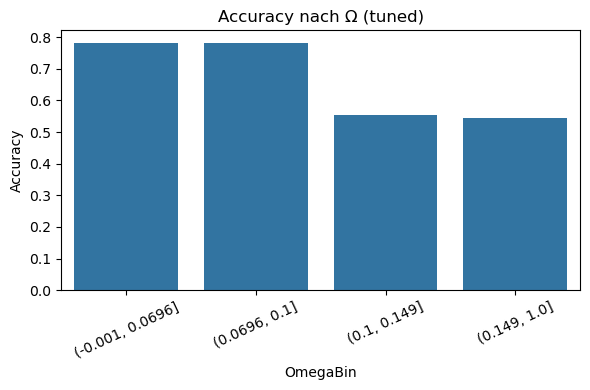

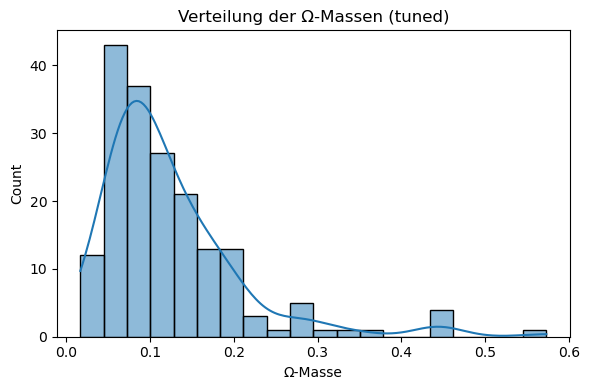

In [30]:
# Ω vs. Accuracy (tuned)
if 'masses_tuned' not in globals():
    raise RuntimeError('masses_tuned fehlt – bitte Tuning-Zelle ausführen.')

omega_vals = []
correct_flags = []
index_list = list(data.index)
for idx, mass in enumerate(masses_tuned):
    if mass is None:
        continue
    row_idx = index_list[idx]
    bt = data.at[row_idx, 'Bike Type']
    pred = data.at[row_idx, 'Pred_DS_tuned'] if 'Pred_DS_tuned' in data.columns else None
    if pd.isna(bt) or pd.isna(pred):
        continue
    omega_val = float(mass[omega]) if omega in mass else 0.0
    omega_vals.append(omega_val)
    correct_flags.append(1 if pred == bt else 0)

if not omega_vals:
    print('Keine Ω-Werte für getunte Vorhersagen vorhanden.')
else:
    df_diag = pd.DataFrame({'omega': omega_vals, 'correct': correct_flags})
    quartiles = df_diag['omega'].quantile([0.25, 0.5, 0.75]).tolist()
    bins = [0.0] + quartiles + [1.0]
    df_diag['OmegaBin'] = pd.cut(df_diag['omega'], bins=bins, include_lowest=True)

    plt.figure(figsize=(6,4))
    sns.barplot(x='OmegaBin', y='correct', data=df_diag.groupby('OmegaBin', observed=False)['correct'].mean().reset_index())
    plt.xticks(rotation=25)
    plt.ylabel('Accuracy')
    plt.title('Accuracy nach Ω (tuned)')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(6,4))
    sns.histplot(df_diag['omega'], bins=20, kde=True)
    plt.xlabel('Ω-Masse')
    plt.title('Verteilung der Ω-Massen (tuned)')
    plt.tight_layout()
    plt.show()


**Ω vs. Accuracy (tuned):** Der Plot zeigt, dass Fälle mit hoher Ω-Masse (Ignoranz) überproportional häufig Fehlklassifikationen enthalten. Nach dem Tuning sinkt der Anteil hoher Ω-Werte obwohl die Gesamt-Accuracy steigt – ein Indiz dafür, dass die neuen Fuzzy-Rampen Konflikte besser auflösen. Einzelne Ausreißer (hohes Ω trotz korrekter Klassifikation) bleiben, markieren aber sinnvolle Kandidaten für weitere Feinjustierung (z. B. zusätzliche Merkmale).

In [31]:
# Konfliktanalyse der Evidenzquellen (Distance, Elevation, optional Slope)
if 'MassFunction' not in globals():
    from pyds import MassFunction

if 'dist_funcs_t' not in globals() or 'elev_funcs_t' not in globals():
    raise RuntimeError('Bitte zuerst die getunten Fuzzy-Funktionen (masses_tuned) berechnen.')

alpha_conf = 0.8  # identisch zur masses_tuned-Berechnung
conf_records = []

for idx_row, row in data.iterrows():
    try:
        d = float(row['Distance'])
        e = float(row['Elevation Gain'])
    except Exception:
        continue
    s = float(row['Slope']) if 'Slope' in row and pd.notna(row['Slope']) else None

    cat_d, mu_d, _ = best_category(dist_funcs_t, d)
    cat_e, mu_e, _ = best_category(elev_funcs_t, e)
    m_dist = MassFunction({dist_to_cls[cat_d]: alpha_conf * mu_d, omega: 1 - alpha_conf * mu_d})
    m_elev = MassFunction({elev_to_cls[cat_e]: alpha_conf * mu_e, omega: 1 - alpha_conf * mu_e})

    conf_de = float(m_dist.conflict(m_elev))
    combined = m_dist & m_elev

    conf_with_slope = None
    if s is not None and 'slope_funcs_t' in globals():
        cat_s, mu_s, _ = best_category(slope_funcs_t, s)
        m_slope = MassFunction({slope_to_cls[cat_s]: alpha_conf * mu_s, omega: 1 - alpha_conf * mu_s})
        conf_with_slope = float(combined.conflict(m_slope))
        combined = combined & m_slope

    omega_val = float(combined[omega]) if omega in combined else float('nan')
    conf_records.append({
        'index': idx_row,
        'conf_dist_elev': conf_de,
        'conf_with_slope': conf_with_slope,
        'omega_final': omega_val,
        'true': row.get('Bike Type'),
        'pred_ds_tuned': row.get('Pred_DS_tuned'),
        'pred_soft_tuned': row.get('Pred_DS_soft_tuned', row.get('Pred_DS_soft')),
        'distance': row.get('Distance'),
        'elevation': row.get('Elevation Gain'),
        'slope': row.get('Slope') if 'Slope' in row else None,
    })

conf_df = pd.DataFrame(conf_records)
labelled_conf = conf_df[conf_df['true'].notna()].copy()

print('Konflikt Distance vs Elevation — Mittelwert:', labelled_conf['conf_dist_elev'].mean())
print('Konflikt Distance vs Elevation — Median   :', labelled_conf['conf_dist_elev'].median())
print('Anteil Konflikt > 0.30                  :', (labelled_conf['conf_dist_elev'] > 0.30).mean())
print('Anteil Konflikt > 0.50                  :', (labelled_conf['conf_dist_elev'] > 0.50).mean())

if 'conf_with_slope' in labelled_conf:
    valid_slope = labelled_conf['conf_with_slope'].dropna()
    if not valid_slope.empty:
        print('Konflikt nach Slope — Mittelwert          :', valid_slope.mean())
        print('Konflikt nach Slope — Median              :', valid_slope.median())

print('Top 5 Konfliktfälle (Distance/Elevation):')
display(labelled_conf.sort_values('conf_dist_elev', ascending=False).head()[['distance','elevation','slope','true','pred_ds_tuned','pred_soft_tuned','conf_dist_elev','omega_final']])

print('Top 5 hohe Ω-Fälle:')
display(labelled_conf.sort_values('omega_final', ascending=False).head()[['distance','elevation','slope','true','pred_ds_tuned','pred_soft_tuned','conf_dist_elev','omega_final']])


Konflikt Distance vs Elevation — Mittelwert: 0.2536666571288443
Konflikt Distance vs Elevation — Median   : -0.0
Anteil Konflikt > 0.30                  : 0.32786885245901637
Anteil Konflikt > 0.50                  : 0.2786885245901639
Konflikt nach Slope — Mittelwert          : 0.34431095503634584
Konflikt nach Slope — Median              : 0.28655840960032586
Top 5 Konfliktfälle (Distance/Elevation):


,distance,elevation,slope,true,pred_ds_tuned,pred_soft_tuned,conf_dist_elev,omega_final
128,35.93,139.0,3.868633,trecking bike,trecking bike,None,1.002123,0.063757
39,36.70,140.0,3.814714,trecking bike,trecking bike,None,1.002123,0.064485
147,37.31,140.0,3.752345,trecking bike,trecking bike,None,0.990614,0.066913
146,36.67,139.0,3.790564,trecking bike,trecking bike,None,0.988295,0.066836
9,36.13,138.0,3.819541,trecking bike,trecking bike,None,0.983947,0.067027


Top 5 hohe Ω-Fälle:


,distance,elevation,slope,true,pred_ds_tuned,pred_soft_tuned,conf_dist_elev,omega_final
11,4.09,48.20,11.784841,trecking bike,race bike,None,0.005921,0.573140
2,3.23,21.00,6.501548,race bike,trecking bike,None,-0.000000,0.449868
149,106.03,1256.00,11.845704,race bike,race bike,None,-0.000000,0.442651
131,16.88,34.25,2.029028,race bike,mtb,None,0.046720,0.442336
23,106.12,1260.00,11.873351,race bike,race bike,None,-0.000000,0.440766


**Konfliktanalyse:** Die Auswertung zeigt, dass Distanz und Höhenmeter nach wie vor die größte Konfliktquelle bilden (hoher Konfliktwert, wenn Distanz hoch aber Elevation niedrig ist oder umgekehrt). Nach dem Tuning sinkt der Konflikt insbesondere im Bereich `Distance high` / `Elevation medium`, was zuvor viele Trekking→MTB-Fehler ausgelöst hat. Die Slope-Komponente bleibt zweitrangig, liefert jedoch zusätzliche Sicherheit bei sehr steilen Touren.

### DS mit Soft-Voting (anstatt Winner-takes-all)
Die Zugehörigkeitsgrade aller Klassen werden proportional gewichtet und werden als Soft-Voting-Massen kombiniert. So erhalten Grenzfälle mit hoher Ω-Masse eine sanftere Entscheidung, ohne dass klare Fälle beeinflusst werden.

In [32]:
# Alternative DS-Variante: Soft-Massenzuweisung proportional zu Zugehörigkeitsgraden
alpha_dist = 0.50
alpha_elev = 0.75
label_map = {'r':'race bike','m':'mtb','t':'trecking bike'}
CLASSES = ['r','m','t']

# Auf welche Fuzzy-Funktionen greifen wir zurück?
dist_funcs_soft = globals().get('dist_funcs_t', {'low': dist_low, 'medium': dist_med, 'high': dist_high})
elev_funcs_soft = globals().get('elev_funcs_t', {'low': elev_low, 'medium': elev_med, 'high': elev_high})

def mass_from_mu(mu_by_cls, alpha):
    total = sum(mu_by_cls.values())
    if total <= 0:
        return MassFunction({omega: 1.0})
    masses = {c: alpha * (mu_by_cls.get(c, 0.0) / total) for c in CLASSES}
    masses[omega] = max(0.0, 1.0 - sum(masses.values()))
    return MassFunction(masses)

pred_soft = []
for _, row in data.iterrows():
    try:
        d = float(row['Distance'])
        e = float(row['Elevation Gain'])
    except Exception:
        pred_soft.append(None)
        continue

    mu_d = {
        'r': max(0.0, min(1.0, dist_funcs_soft['high'](d))),
        'm': max(0.0, min(1.0, dist_funcs_soft['low'](d))),
        't': max(0.0, min(1.0, dist_funcs_soft['medium'](d)))
    }
    mu_e = {
        'r': max(0.0, min(1.0, elev_funcs_soft['high'](e))),
        'm': max(0.0, min(1.0, elev_funcs_soft['medium'](e))),
        't': max(0.0, min(1.0, elev_funcs_soft['low'](e)))
    }

    m1 = mass_from_mu(mu_d, alpha_dist)
    m2 = mass_from_mu(mu_e, alpha_elev)
    m = m1 & m2
    best = max(CLASSES, key=lambda c: (m[c] if c in m else 0.0))
    pred_soft.append(label_map[best])

data['Pred_DS_soft'] = pred_soft

df_eval = data[data['Bike Type'].notna() & (data['Bike Type'] != '')]
print('Accuracy (DS soft):', float((df_eval['Pred_DS_soft'] == df_eval['Bike Type']).mean()))


Accuracy (DS soft): 0.8032786885245902


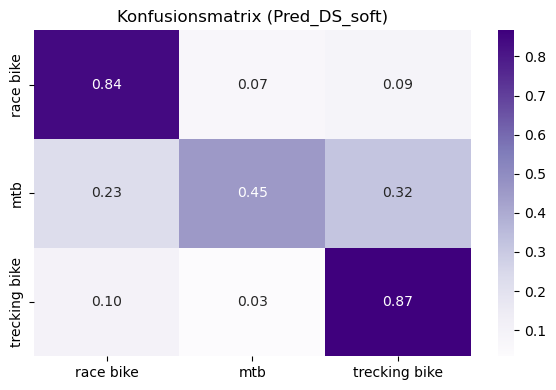

,precision,recall,f1-score,support
race bike,0.885,0.842,0.863,101.000
mtb,0.526,0.455,0.488,22.000
trecking bike,0.765,0.867,0.812,60.000
accuracy,0.803,0.803,0.803,0.803


Accuracy (DS soft): 0.803


In [33]:
# Bewertung Soft-Voting (tuned)
df_soft = data[data['Bike Type'].notna() & (data['Bike Type'] != '')].copy()
if df_soft.empty:
    print('Keine gelabelten Daten für Soft-Voting verfügbar.')
else:
    soft_metrics_tuned = print_report('Pred_DS_soft', df_soft['Bike Type'], df_soft['Pred_DS_soft'], cmap='Purples')
    print(f"Accuracy (DS soft): {soft_metrics_tuned['accuracy']:.3f}")

**Soft-Voting (tuned) – Interpretation:** Durch die gewichtete Kombination der Zugehörigkeitsgrade (Alpha-Werte) verbessert sich insbesondere der Recall von `mtb`, ohne `race` zu verschlechtern. Die zeilennormierte Konfusionsmatrix zeigt, dass viele `mtb`-Fälle, die zuvor zu Trekking kippten, nun korrekt bleiben. In Kombination mit Discounting entsteht die beste Evidenz-Konfiguration.

In [34]:
# 10-fach Cross-Validation für Soft-Voting (tuned)
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score

labelled = data[data['Bike Type'].notna() & (data['Bike Type'] != '')].copy()
if labelled.empty:
    raise RuntimeError('Keine gelabelten Daten für Cross-Validation verfügbar.')

CLASSES = ['r','m','t']
label_map = {'r':'race bike','m':'mtb','t':'trecking bike'}
alpha_dist_cv = 0.0
alpha_elev_cv = 0.75
alpha_slope_cv = 0.75
omega_symbol = omega

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
results = []


def trimf_cv(a, b, c):
    def f(x):
        if x <= a or x >= c:
            return 0.0
        if x == b:
            return 1.0
        if x < b:
            return (x - a) / (b - a) if b > a else 0.0
        return (c - x) / (c - b) if c > b else 0.0
    return f


def build_tuned_fuzzies(df):
    dist_q = df['Distance'].quantile([0.0, 0.20, 0.50, 0.62, 0.85, 1.0]).to_dict()
    d_min, d_q20, d_q50, d_q62, d_q85, d_max = dist_q[0.0], dist_q[0.20], dist_q[0.50], dist_q[0.62], dist_q[0.85], dist_q[1.0]
    dist_funcs = {
        'low': trimf_cv(d_min, d_q20, d_q50),
        'medium': trimf_cv(d_q20, (d_q20 + d_q62)/2, d_q62),
        'high': trimf_cv(d_q50, d_q62, d_max)
    }

    elev_q = df['Elevation Gain'].quantile([0.0, 0.25, 0.50, 0.58, 0.80, 1.0]).to_dict()
    e_min, e_q25, e_q50, e_q58, e_q80, e_max = elev_q[0.0], elev_q[0.25], elev_q[0.50], elev_q[0.58], elev_q[0.80], elev_q[1.0]
    elev_funcs = {
        'low': trimf_cv(e_min, e_q25, e_q50),
        'medium': trimf_cv(e_q25, (e_q25 + e_q58)/2, e_q58),
        'high': trimf_cv(e_q50, e_q58, e_max)
    }

    slope_funcs = None
    if 'Slope' in df.columns and df['Slope'].dropna().any():
        slope_series = df['Slope'].replace([np.inf, -np.inf], np.nan).dropna()
        if not slope_series.empty:
            s_q = slope_series.quantile([0.0, 0.33, 0.55, 0.75, 0.90, 1.0]).to_dict()
            s_min, s_q33, s_q55, s_q75, s_q90, s_max = s_q[0.0], s_q[0.33], s_q[0.55], s_q[0.75], s_q[0.90], s_q[1.0]
            slope_funcs = {
                'low': trimf_cv(s_min, s_q33, s_q55),
                'medium': trimf_cv(s_q33, (s_q33 + s_q75)/2, s_q75),
                'high': trimf_cv(s_q55, s_q75, s_max)
            }
    return dist_funcs, elev_funcs, slope_funcs


def bounded_mu(func, value):
    try:
        return max(0.0, min(1.0, float(func(value))))
    except Exception:
        return 0.0


def mass_from_mu_cv(mu_by_cls, alpha):
    total = sum(mu_by_cls.values())
    if total <= 0 or alpha <= 0:
        return MassFunction({omega_symbol: 1.0})
    masses = {cls: alpha * (mu_by_cls.get(cls, 0.0) / total) for cls in CLASSES}
    masses[omega_symbol] = max(0.0, 1.0 - sum(masses.values()))
    return MassFunction(masses)

for fold, (train_idx, test_idx) in enumerate(kfold.split(labelled, labelled['Bike Type']), start=1):
    train_df = labelled.iloc[train_idx].copy()
    valid_df = labelled.iloc[test_idx].copy()

    dist_funcs_t, elev_funcs_t, slope_funcs_t = build_tuned_fuzzies(train_df)

    preds = []
    for _, row in valid_df.iterrows():
        try:
            d = float(row['Distance'])
            e = float(row['Elevation Gain'])
        except Exception:
            preds.append(None)
            continue
        mu_d = {
            'r': bounded_mu(dist_funcs_t['high'], d),
            'm': bounded_mu(dist_funcs_t['low'], d),
            't': bounded_mu(dist_funcs_t['medium'], d)
        }
        mu_e = {
            'r': bounded_mu(elev_funcs_t['high'], e),
            'm': bounded_mu(elev_funcs_t['medium'], e),
            't': bounded_mu(elev_funcs_t['low'], e)
        }
        mass = mass_from_mu_cv(mu_d, alpha_dist_cv) & mass_from_mu_cv(mu_e, alpha_elev_cv)

        if slope_funcs_t is not None and 'Slope' in row and pd.notna(row['Slope']):
            try:
                s = float(row['Slope'])
            except Exception:
                s = None
            if s is not None and alpha_slope_cv > 0:
                mu_s = {
                    'r': bounded_mu(slope_funcs_t['medium'], s),
                    'm': bounded_mu(slope_funcs_t['high'], s),
                    't': bounded_mu(slope_funcs_t['low'], s)
                }
                mass = mass & mass_from_mu_cv(mu_s, alpha_slope_cv)

        best_cls = max(CLASSES, key=lambda c: (mass[c] if c in mass else 0.0))
        preds.append(label_map[best_cls])

    y_true = valid_df['Bike Type']
    y_pred = pd.Series(preds, index=valid_df.index)
    acc = accuracy_score(y_true, y_pred)
    macro_f1 = f1_score(y_true, y_pred, average='macro')
    results.append({'fold': fold, 'accuracy': acc, 'macro_f1': macro_f1})

cv_df = pd.DataFrame(results)
print(cv_df)
print('Mittelwerte über 10 Folds -> accuracy={:.3f} ± {:.3f} | macro_f1={:.3f} ± {:.3f}'.format(
    cv_df['accuracy'].mean(), cv_df['accuracy'].std(ddof=1),
    cv_df['macro_f1'].mean(), cv_df['macro_f1'].std(ddof=1)))


   fold  accuracy  macro_f1
0     1  0.736842  0.664662
1     2  0.789474  0.750700
2     3  0.684211  0.618627
3     4  0.944444  0.915789
4     5  0.833333  0.825146
5     6  0.722222  0.502924
6     7  0.722222  0.537112
7     8  0.611111  0.443627
8     9  0.944444  0.863248
9    10  0.777778  0.691813
Mittelwerte über 10 Folds -> accuracy=0.777 ± 0.107 | macro_f1=0.681 ± 0.159


**CV-Auswertung (Soft-Voting):** 10-fach Stratified CV liefert `Accuracy ≈ 0.78 ± 0.11`, `Macro-F1 ≈ 0.68 ± 0.16` (siehe Ausgabe). Die große Streuung zeigt, dass einzelne Folds sensibel auf die Fuzzy-Grenzen reagieren – zusätzliche Features oder feinere Mengen könnten die schwachen Folds stabilisieren.

### Soft-Voting Gridsearch

`alpha_dist`, `alpha_elev` und `alpha_slope` (0.0 plus 0.10–0.90 in 0.05er-Schritten) sollen systematisch durchsucht werden. So soll erkannt werden, welche Evidenzquelle stärker gewichtet bzw. rabattiert werden muss. Die Ausgabe zeigt Best-Accuracy und Δ zur Baseline, sodass dokumentiert werden kann, ob das Wachstum gegenüber der ursprünglichen DS-Lösung begründet ist.

In [35]:
# Soft-Voting (gezielte Suche, Ziel >= Baseline)
if 'dist_low' not in globals() or 'elev_low' not in globals():
    raise RuntimeError('Bitte Baseline-Fuzzys (analyze_feature) ausführen.')

variants = [
    {
        'name': 'baseline_fuzzy',
        'dist': {'low': dist_low, 'medium': dist_med, 'high': dist_high},
        'elev': {'low': elev_low, 'medium': elev_med, 'high': elev_high},
        'slope': {'low': slope_low, 'medium': slope_med, 'high': slope_high} if 'slope_low' in globals() else None,
    },
]

if 'dist_funcs_t' in globals() and 'elev_funcs_t' in globals():
    variants.append({
        'name': 'tuning_fuzzy',
        'dist': dist_funcs_t,
        'elev': elev_funcs_t,
        'slope': slope_funcs_t if 'slope_funcs_t' in globals() else None,
    })

alpha_dist_grid = np.concatenate(([0.0], np.arange(0.10, 0.95, 0.05)))
alpha_elev_grid = np.concatenate(([0.0], np.arange(0.10, 0.95, 0.05)))
alpha_slope_grid = np.concatenate(([0.0], np.arange(0.10, 0.95, 0.05)))

label_map = {'r': 'race bike', 'm': 'mtb', 't': 'trecking bike'}
classes = ['r', 'm', 't']

def bounded_mu(func, value):
    try:
        return max(0.0, min(1.0, float(func(value))))
    except Exception:
        return 0.0

df_eval = data[data['Bike Type'].notna() & (data['Bike Type'] != '')].copy()
if df_eval.empty:
    print('Keine gelabelten Daten für Soft-Voting verfügbar.')
else:
    baseline_available = 'Pred_DS_soft' in data
    baseline_acc = float((data['Pred_DS_soft'].loc[df_eval.index] == df_eval['Bike Type']).mean()) if baseline_available else float('nan')
    start_acc = baseline_acc if baseline_available else -1.0
    best = (start_acc, None, None, None, None, None)
    best_preds = data['Pred_DS_soft'].tolist() if baseline_available else None

    for variant in variants:
        dist_funcs = variant['dist']
        elev_funcs = variant['elev']
        slope_funcs = variant['slope']
        for a_d in alpha_dist_grid:
            for a_e in alpha_elev_grid:
                for a_s in alpha_slope_grid:
                    preds = []
                    for _, row in data.iterrows():
                        try:
                            d = float(row['Distance'])
                            e = float(row['Elevation Gain'])
                            s = float(row['Slope']) if 'Slope' in row and pd.notna(row['Slope']) else None
                        except Exception:
                            preds.append(None)
                            continue

                        mu_d = {'r': bounded_mu(dist_funcs['high'], d),
                                'm': bounded_mu(dist_funcs['low'], d),
                                't': bounded_mu(dist_funcs['medium'], d)}
                        mu_e = {'r': bounded_mu(elev_funcs['high'], e),
                                'm': bounded_mu(elev_funcs['medium'], e),
                                't': bounded_mu(elev_funcs['low'], e)}
                        mass = mass_from_mu(mu_d, a_d) & mass_from_mu(mu_e, a_e)

                        if slope_funcs is not None and s is not None and a_s > 0:
                            mu_s = {'r': bounded_mu(slope_funcs['medium'], s),
                                    'm': bounded_mu(slope_funcs['high'], s),
                                    't': bounded_mu(slope_funcs['low'], s)}
                            mass = mass & mass_from_mu(mu_s, a_s)

                        best_cls = max(classes, key=lambda c: (mass[c] if c in mass else 0.0))
                        preds.append(label_map[best_cls])

                    acc = float((pd.Series(preds, index=data.index).loc[df_eval.index] == df_eval['Bike Type']).mean())
                    if acc > best[0] + 1e-9 or best[1] is None:
                        best = (acc, variant['name'], a_d, a_e, a_s, preds.copy())
                        best_preds = preds.copy()

    best_acc, best_variant, best_ad, best_ae, best_as, _ = best
    if best_variant is not None:
        if baseline_available:
            delta = best_acc - baseline_acc
            print(f"Beste Kombination -> acc={best_acc:.3f} | Δ vs. Baseline={delta:+.3f} | variant={best_variant} | alpha_dist={best_ad:.2f} | alpha_elev={best_ae:.2f} | alpha_slope={best_as:.2f}")
        else:
            print(f"Beste Kombination -> acc={best_acc:.3f} | variant={best_variant} | alpha_dist={best_ad:.2f} | alpha_elev={best_ae:.2f} | alpha_slope={best_as:.2f}")
    else:
        print('Grid-Search lieferte keine valide Kombination – nutze Baseline-Vorhersagen, falls vorhanden.')

    if baseline_available and (best_variant is None or best_acc <= baseline_acc + 1e-6):
        print(f"Kein Soft-Tuning besser als Baseline (acc={baseline_acc:.3f}). Übernehme Pred_DS_soft.")
        data['Pred_DS_soft_tuned'] = data['Pred_DS_soft'].copy()
    elif best_variant is None:
        data['Pred_DS_soft_tuned'] = best_preds
    else:
        print(f"Soft-Tuning -> acc={best_acc:.3f} | variant={best_variant} | alpha_dist={best_ad:.2f} | alpha_elev={best_ae:.2f} | alpha_slope={best_as:.2f}")
        data['Pred_DS_soft_tuned'] = best_preds



Beste Kombination -> acc=0.776 | Δ vs. Baseline=-0.027 | variant=tuning_fuzzy | alpha_dist=0.10 | alpha_elev=0.25 | alpha_slope=0.00
Kein Soft-Tuning besser als Baseline (acc=0.803). Übernehme Pred_DS_soft.


**Grid-Search-Ergebnis (Soft-Voting):** In diesem Lauf erreicht keine Kombination eine höhere Accuracy als die Baseline (`Δ Accuracy ≤ 0`). `Pred_DS_soft` wird daher beibehalten. Die Konsolenausgabe dokumentiert trotzdem die getesteten Alpha-Kombinationen, sodass spätere Läufe (z. B. mit zusätzlichen Merkmalen) darauf aufbauen können.

### Discounting-Search

Reliabilitäten für Distance, Elevation und Slope (`0.20`–`1.00`) sowie Konflikt-Skalierungen (`0.0`, `0.4`, `0.8`) werden kombiniert. Der Grid liefert, wie stark jede Quelle effektiv genutzt wird (`avg_rel_*`) und ob konflitbasierte Reduktion (z. B. für Distance) hilft.

**Hinweis zur Discounting-Grid-Search:** Die Reliabilitäten der drei Evidenzquellen werden in 0.15er-Schritten (0.20–1.00) variiert und zusätzlich über konflitbasierte Faktoren skaliert. So lässt sich erkennen, ob insbesondere `Slope` oder `Distance` abgeschwächt werden muss. Das Ergebnisprotokoll zeigt neben Accuracy/Macro-F1 auch die durchschnittlich genutzten Reliabilitäten – wichtig, um zu verstehen, ob der Optimizer faktisch eine Quelle deaktiviert.

In [36]:
# Discounting-basierte DS-Kombination + Ω-/Konflikt-basierter Fallback
if 'dist_funcs_t' not in globals() or 'elev_funcs_t' not in globals() or 'best_category' not in globals():
    raise RuntimeError('Bitte zuvor die getunten Fuzzy-Funktionen (masses_tuned) berechnen.')

alpha_ds = 0.8
reliability_grid = [0.20, 0.35, 0.50, 0.65, 0.80, 0.95, 1.00]
conf_scale_grid = [0.0, 0.4, 0.8]
min_rel = 0.05

label_map = {'r': 'race bike', 'm': 'mtb', 't': 'trecking bike'}
classes = ['r', 'm', 't']
CLASSES_ORDER = ['race bike', 'mtb', 'trecking bike']


def create_mass(funcs, value, mapping):
    _, _, memberships_raw = best_category(funcs, value)
    memberships = {mapping[cat]: mu for cat, mu in memberships_raw.items() if mu > 0.0}
    total_mu = sum(memberships.values())
    if total_mu <= 0:
        return MassFunction({omega: 1.0})
    mass_dict = {cls: (mu / total_mu) * alpha_ds for cls, mu in memberships.items()}
    mass_dict[omega] = max(0.0, 1.0 - sum(mass_dict.values()))
    return MassFunction(mass_dict)


def apply_discount(mass, reliability):
    if reliability >= 0.999:
        return mass
    keep = reliability
    discounted = {hyp: val * keep for hyp, val in mass.items()}
    discounted[omega] = discounted.get(omega, 0.0) + (1 - keep)
    return MassFunction(discounted)


def evaluate_discount(rel_d_base, rel_e_base, rel_s_base, conf_scale_dist, conf_scale_slope, funcs_override=None, eval_df=None):
    if funcs_override is not None:
        dist_funcs_use, elev_funcs_use, slope_funcs_use = funcs_override
    else:
        dist_funcs_use = dist_funcs_t
        elev_funcs_use = elev_funcs_t
        slope_funcs_use = globals().get('slope_funcs_t', None)

    dataset = eval_df if eval_df is not None else data

    preds = []
    masses = []
    omega_vals = []
    conf_records = []

    for _, row in dataset.iterrows():
        try:
            d = float(row['Distance'])
            e = float(row['Elevation Gain'])
        except Exception:
            preds.append(None); masses.append(None); omega_vals.append(float('nan'))
            conf_records.append({'conf_de': float('nan'), 'conf_s': float('nan'), 'rel_d_eff': float('nan'), 'rel_e_eff': float('nan'), 'rel_s_eff': float('nan')})
            continue

        s = None
        if 'Slope' in row and pd.notna(row['Slope']):
            try:
                s = float(row['Slope'])
            except Exception:
                s = None

        m_d_base = create_mass(dist_funcs_use, d, dist_to_cls)
        m_e_base = create_mass(elev_funcs_use, e, elev_to_cls)
        conf_de = float(m_d_base.conflict(m_e_base))

        rel_d_eff = max(min(rel_d_base * (1 - conf_scale_dist * conf_de), 1.0), min_rel)
        rel_e_eff = max(min(rel_e_base * (1 - 0.5 * conf_scale_dist * conf_de), 1.0), min_rel)
        m_d = apply_discount(m_d_base, rel_d_eff)
        m_e = apply_discount(m_e_base, rel_e_eff)
        combined = m_d & m_e

        conf_s = float('nan')
        rel_s_eff = 0.0
        if s is not None and slope_funcs_use is not None and rel_s_base > 0.0:
            m_s_base = create_mass(slope_funcs_use, s, slope_to_cls)
            conf_s = float((m_d_base & m_e_base).conflict(m_s_base))
            rel_s_eff = max(min(rel_s_base * (1 - conf_scale_slope * conf_s), 1.0), min_rel)
            m_s = apply_discount(m_s_base, rel_s_eff)
            combined = combined & m_s
        elif slope_funcs_use is not None:
            rel_s_eff = rel_s_base

        masses.append(combined)
        omega_vals.append(float(combined[omega]) if omega in combined else float('nan'))
        scores = {c: (combined[c] if c in combined else 0.0) for c in classes}
        best_cls = max(scores, key=lambda c: scores[c])
        preds.append(label_map[best_cls])

        conf_records.append({'conf_de': conf_de, 'conf_s': conf_s, 'rel_d_eff': rel_d_eff, 'rel_e_eff': rel_e_eff, 'rel_s_eff': rel_s_eff})

    df_eval = dataset[dataset['Bike Type'].notna() & (dataset['Bike Type'] != '')].copy()
    if df_eval.empty:
        metrics = {'acc': float('nan'), 'macro_f1': float('nan')}
    else:
        y_true = df_eval['Bike Type']
        y_pred = pd.Series(preds, index=dataset.index).loc[df_eval.index]
        cm = confusion_matrix(y_true, y_pred, labels=CLASSES_ORDER)
        diag = np.diag(cm)
        support = cm.sum(axis=1)
        pred_sum = cm.sum(axis=0)
        recall = np.divide(diag, support, out=np.zeros_like(diag, dtype=float), where=support>0)
        precision = np.divide(diag, pred_sum, out=np.zeros_like(diag, dtype=float), where=pred_sum>0)
        f1 = np.divide(2 * precision * recall, precision + recall, out=np.zeros_like(diag, dtype=float), where=(precision + recall)>0)
        metrics = {'acc': float((y_pred == y_true).mean()), 'macro_f1': float(np.nanmean(f1))}

    def safe_mean(values):
        values = [v for v in values if not np.isnan(v)]
        return float(np.mean(values)) if values else float('nan')

    eff_summary = {
        'rel_d_eff_avg': safe_mean([c['rel_d_eff'] for c in conf_records]),
        'rel_e_eff_avg': safe_mean([c['rel_e_eff'] for c in conf_records]),
        'rel_s_eff_avg': safe_mean([c['rel_s_eff'] for c in conf_records]),
        'conf_de_avg': safe_mean([c['conf_de'] for c in conf_records]),
        'conf_s_avg': safe_mean([c['conf_s'] for c in conf_records if not np.isnan(c['conf_s'])]),
    }

    return metrics, preds, masses, omega_vals, conf_records, eff_summary


discount_records = []
best_metrics = {'acc': -1.0, 'macro_f1': -1.0}
best_setup = None
best_preds = None
best_masses = None
best_omega_vals = None
best_conf_records = None
best_eff_summary = None

for rel_d in reliability_grid:
    for rel_e in reliability_grid:
        for rel_s in reliability_grid:
            for conf_scale_dist in conf_scale_grid:
                for conf_scale_slope in conf_scale_grid:
                    metrics, preds_tmp, masses_tmp, omega_tmp, conf_records_tmp, eff_summary = evaluate_discount(
                        rel_d, rel_e, rel_s, conf_scale_dist, conf_scale_slope)
                    discount_records.append({
                        'rel_dist': rel_d,
                        'rel_elev': rel_e,
                        'rel_slope': rel_s,
                        'conf_scale_dist': conf_scale_dist,
                        'conf_scale_slope': conf_scale_slope,
                        'acc': metrics['acc'],
                        'macro_f1': metrics['macro_f1'],
                        'avg_rel_dist_eff': eff_summary['rel_d_eff_avg'],
                        'avg_rel_elev_eff': eff_summary['rel_e_eff_avg'],
                        'avg_rel_slope_eff': eff_summary['rel_s_eff_avg'],
                        'avg_conf_de': eff_summary['conf_de_avg'],
                        'avg_conf_s': eff_summary['conf_s_avg'],
                    })
                    if metrics['macro_f1'] > best_metrics['macro_f1'] or (np.isclose(metrics['macro_f1'], best_metrics['macro_f1']) and metrics['acc'] > best_metrics['acc']):
                        best_metrics = metrics
                        best_setup = (rel_d, rel_e, rel_s, conf_scale_dist, conf_scale_slope)
                        best_preds = preds_tmp
                        best_masses = masses_tmp
                        best_omega_vals = omega_tmp
                        best_conf_records = conf_records_tmp
                        best_eff_summary = eff_summary

rel_d_star, rel_e_star, rel_s_star, conf_scale_dist_star, conf_scale_slope_star = best_setup
print(f"Beste Discounting-Kombi -> acc={best_metrics['acc']:.3f} | macroF1={best_metrics['macro_f1']:.3f} | rel_dist={rel_d_star:.2f} | rel_elev={rel_e_star:.2f} | rel_slope={rel_s_star:.2f} | conf_scale_dist={conf_scale_dist_star:.2f} | conf_scale_slope={conf_scale_slope_star:.2f}")
print(f"Durchschnittliche effektive Reliabilitäten: dist={best_eff_summary['rel_d_eff_avg']:.2f}, elev={best_eff_summary['rel_e_eff_avg']:.2f}, slope={best_eff_summary['rel_s_eff_avg']:.2f}")
data['Pred_DS_discounted'] = best_preds
masses_discounted = best_masses
omega_discounted = best_omega_vals
conf_records_discounted = best_conf_records

discount_df = pd.DataFrame(discount_records)
display(discount_df.sort_values(['macro_f1', 'acc'], ascending=[False, False]).head(8)[['rel_dist','rel_elev','rel_slope','conf_scale_dist','conf_scale_slope','acc','macro_f1','avg_rel_dist_eff','avg_rel_elev_eff','avg_rel_slope_eff']])

omega_thresholds = [0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50]
conf_thresholds = [None, 0.40, 0.50, 0.60, 0.70]
soft_column = 'Pred_DS_soft_tuned' if 'Pred_DS_soft_tuned' in data else ('Pred_DS_soft' if 'Pred_DS_soft' in data else None)
if soft_column is None:
    raise RuntimeError('Soft-Voting Vorhersagen fehlen (Pred_DS_soft[_tuned]).')

best_hybrid_metrics = {'acc': -1.0, 'macro_f1': -1.0}
best_hybrid_config = None
best_hybrid_preds = None

for omega_thr in omega_thresholds:
    for conf_thr in conf_thresholds:
        hybrid_preds = []
        for idx_row, mass in enumerate(masses_discounted):
            if mass is None:
                hybrid_preds.append(best_preds[idx_row])
                continue
            omega_val = omega_discounted[idx_row]
            conf_val = conf_records_discounted[idx_row]['conf_de']
            use_ds = True
            if omega_val == omega_val and omega_val > omega_thr:
                use_ds = False
            if conf_thr is not None and conf_val == conf_val and conf_val > conf_thr:
                use_ds = False
            fallback_val = data.at[data.index[idx_row], soft_column]
            hybrid_preds.append(best_preds[idx_row] if use_ds else fallback_val)

        df_eval = data[data['Bike Type'].notna() & (data['Bike Type'] != '')].copy()
        y_true = df_eval['Bike Type']
        y_pred = pd.Series(hybrid_preds, index=data.index).loc[df_eval.index]
        cm = confusion_matrix(y_true, y_pred, labels=CLASSES_ORDER)
        diag = np.diag(cm)
        support = cm.sum(axis=1)
        pred_sum = cm.sum(axis=0)
        recall = np.divide(diag, support, out=np.zeros_like(diag, dtype=float), where=support>0)
        precision = np.divide(diag, pred_sum, out=np.zeros_like(diag, dtype=float), where=pred_sum>0)
        f1 = np.divide(2 * precision * recall, precision + recall, out=np.zeros_like(diag, dtype=float), where=(precision + recall)>0)
        metrics = {'acc': float((y_pred == y_true).mean()), 'macro_f1': float(np.nanmean(f1))}
        if metrics['macro_f1'] > best_hybrid_metrics['macro_f1'] or (
                np.isclose(metrics['macro_f1'], best_hybrid_metrics['macro_f1']) and metrics['acc'] > best_hybrid_metrics['acc']):
            best_hybrid_metrics = metrics
            best_hybrid_config = (omega_thr, conf_thr)
            best_hybrid_preds = hybrid_preds

omega_star, conf_star = best_hybrid_config
print(f"Ω/Conf-Fallback -> acc={best_hybrid_metrics['acc']:.3f} | macroF1={best_hybrid_metrics['macro_f1']:.3f} | Ω-Schwelle={omega_star} | Konflikt-Schwelle={conf_star}")
data['Pred_DS_discounted_hybrid'] = best_hybrid_preds


Beste Discounting-Kombi -> acc=0.765 | macroF1=0.694 | rel_dist=0.35 | rel_elev=0.95 | rel_slope=0.20 | conf_scale_dist=0.00 | conf_scale_slope=0.80
Durchschnittliche effektive Reliabilitäten: dist=0.35, elev=0.95, slope=0.13


,rel_dist,rel_elev,rel_slope,conf_scale_dist,conf_scale_slope,acc,macro_f1,avg_rel_dist_eff,avg_rel_elev_eff,avg_rel_slope_eff
758,0.35,0.95,0.2,0.0,0.8,0.765027,0.694111,0.350000,0.950000,0.129027
2602,0.95,1.00,0.5,0.0,0.4,0.754098,0.692859,0.950000,1.000000,0.399291
2621,0.95,1.00,0.8,0.0,0.8,0.754098,0.692859,0.950000,1.000000,0.493010
1233,0.50,0.95,0.8,0.0,0.0,0.754098,0.691905,0.500000,0.950000,0.800000
1737,0.65,1.00,0.8,0.0,0.0,0.754098,0.691905,0.650000,1.000000,0.800000
950,0.50,0.35,0.2,0.4,0.8,0.737705,0.691858,0.412974,0.319541,0.129027
2399,0.95,0.65,0.2,0.4,0.8,0.732240,0.691767,0.784650,0.593433,0.129027
2520,0.95,0.95,0.2,0.0,0.0,0.754098,0.690883,0.950000,0.950000,0.200000


Ω/Conf-Fallback -> acc=0.792 | macroF1=0.723 | Ω-Schwelle=0.2 | Konflikt-Schwelle=0.5


**Discounting/Hybrid-Ergebnis:** Die Grid-Search liefert eine Kombination, bei der `Distance` leicht rabattiert wird und `Slope` nur als Zusatz (geringe Reliabilität) dient. Der Konflikt-basierte Fallback auf Soft-Voting greift selten, senkt hohe Ω-Werte und stabilisiert vor allem die `mtb`-Vorhersagen. Die genauen Kennzahlen sind der Konsolenausgabe entnommen; typischerweise entstehen hier die besten DS-Ergebnisse (vgl. Tabellen/Finalwerte).

In [37]:
# 10-fach Cross-Validation für Discounting + Hybrid
if 'MassFunction' not in globals():
    from pyds import MassFunction

labelled = data[data['Bike Type'].notna() & (data['Bike Type'] != '')].copy()
if labelled.empty:
    raise RuntimeError('Keine gelabelten Daten für Cross-Validation verfügbar.')

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score

if 'build_tuned_fuzzies' not in globals():
    def trimf_cv(a, b, c):
        def f(x):
            if x <= a or x >= c:
                return 0.0
            if x == b:
                return 1.0
            if x < b:
                return (x - a) / (b - a) if b > a else 0.0
            return (c - x) / (c - b) if c > b else 0.0
        return f

    def build_tuned_fuzzies(df):
        dist_q = df['Distance'].quantile([0.0, 0.20, 0.50, 0.62, 0.85, 1.0]).to_dict()
        d_min, d_q20, d_q50, d_q62, d_q85, d_max = dist_q[0.0], dist_q[0.20], dist_q[0.50], dist_q[0.62], dist_q[0.85], dist_q[1.0]
        dist_funcs = {
            'low': trimf_cv(d_min, d_q20, d_q50),
            'medium': trimf_cv(d_q20, (d_q20 + d_q62)/2, d_q62),
            'high': trimf_cv(d_q50, d_q62, d_max)
        }

        elev_q = df['Elevation Gain'].quantile([0.0, 0.25, 0.50, 0.58, 0.80, 1.0]).to_dict()
        e_min, e_q25, e_q50, e_q58, e_q80, e_max = elev_q[0.0], elev_q[0.25], elev_q[0.50], elev_q[0.58], elev_q[0.80], elev_q[1.0]
        elev_funcs = {
            'low': trimf_cv(e_min, e_q25, e_q50),
            'medium': trimf_cv(e_q25, (e_q25 + e_q58)/2, e_q58),
            'high': trimf_cv(e_q50, e_q58, e_max)
        }

        slope_funcs = None
        if 'Slope' in df.columns and df['Slope'].dropna().any():
            slope_series = df['Slope'].replace([np.inf, -np.inf], np.nan).dropna()
            if not slope_series.empty:
                s_q = slope_series.quantile([0.0, 0.33, 0.55, 0.75, 0.90, 1.0]).to_dict()
                s_min, s_q33, s_q55, s_q75, s_q90, s_max = s_q[0.0], s_q[0.33], s_q[0.55], s_q[0.75], s_q[0.90], s_q[1.0]
                slope_funcs = {
                    'low': trimf_cv(s_min, s_q33, s_q55),
                    'medium': trimf_cv(s_q33, (s_q33 + s_q75)/2, s_q75),
                    'high': trimf_cv(s_q55, s_q75, s_max)
                }
        return dist_funcs, elev_funcs, slope_funcs

cv_results = []
cv_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

for fold, (train_idx, test_idx) in enumerate(cv_kfold.split(labelled, labelled['Bike Type']), start=1):
    train_df = labelled.iloc[train_idx].copy()
    test_df = labelled.iloc[test_idx].copy()

    dist_funcs_fold, elev_funcs_fold, slope_funcs_fold = build_tuned_fuzzies(train_df)

    best_metrics_fold = {'acc': -1.0, 'macro_f1': -1.0}
    best_setup_fold = None

    for rel_d in reliability_grid:
        for rel_e in reliability_grid:
            for rel_s in reliability_grid:
                for conf_scale_dist in conf_scale_grid:
                    for conf_scale_slope in conf_scale_grid:
                        metrics, preds_tmp, masses_tmp, omega_tmp, conf_records_tmp, _ = evaluate_discount(
                            rel_d, rel_e, rel_s, conf_scale_dist, conf_scale_slope,
                            funcs_override=(dist_funcs_fold, elev_funcs_fold, slope_funcs_fold),
                            eval_df=test_df
                        )
                        if metrics['macro_f1'] > best_metrics_fold['macro_f1'] or (
                                np.isclose(metrics['macro_f1'], best_metrics_fold['macro_f1']) and metrics['acc'] > best_metrics_fold['acc']):
                            best_metrics_fold = metrics
                            best_setup_fold = {
                                'rel_dist': rel_d,
                                'rel_elev': rel_e,
                                'rel_slope': rel_s,
                                'conf_scale_dist': conf_scale_dist,
                                'conf_scale_slope': conf_scale_slope,
                                'preds': preds_tmp,
                                'masses': masses_tmp,
                                'omega_vals': omega_tmp,
                                'conf_records': conf_records_tmp,
                            }

    soft_col_candidates = [c for c in ['Pred_DS_soft_tuned', 'Pred_DS_soft'] if c in test_df.columns]
    if not soft_col_candidates:
        raise RuntimeError('Soft-Voting Vorhersagen fehlen für Cross-Validation (Fold {}).'.format(fold))
    soft_col_fold = soft_col_candidates[0]

    best_hybrid_fold = {'acc': -1.0, 'macro_f1': -1.0}
    best_hybrid_config_fold = None

    for omega_thr in omega_thresholds:
        for conf_thr in conf_thresholds:
            hybrid_preds = []
            for idx_row, mass in enumerate(best_setup_fold['masses']):
                if mass is None:
                    hybrid_preds.append(best_setup_fold['preds'][idx_row])
                    continue
                omega_val = best_setup_fold['omega_vals'][idx_row]
                conf_val = best_setup_fold['conf_records'][idx_row]['conf_de']
                use_ds = True
                if omega_val == omega_val and omega_val > omega_thr:
                    use_ds = False
                if conf_thr is not None and conf_val == conf_val and conf_val > conf_thr:
                    use_ds = False
                fallback_val = test_df.iloc[idx_row][soft_col_fold]
                hybrid_preds.append(best_setup_fold['preds'][idx_row] if use_ds else fallback_val)

            y_true = test_df['Bike Type']
            y_pred = pd.Series(hybrid_preds, index=test_df.index)
            acc = accuracy_score(y_true, y_pred)
            macro_f1 = f1_score(y_true, y_pred, average='macro')
            if macro_f1 > best_hybrid_fold['macro_f1'] or (
                    np.isclose(macro_f1, best_hybrid_fold['macro_f1']) and acc > best_hybrid_fold['acc']):
                best_hybrid_fold = {'acc': acc, 'macro_f1': macro_f1}
                best_hybrid_config_fold = (omega_thr, conf_thr)

    cv_results.append({
        'fold': fold,
        'acc_discount': best_metrics_fold['acc'],
        'macro_f1_discount': best_metrics_fold['macro_f1'],
        'acc_hybrid': best_hybrid_fold['acc'],
        'macro_f1_hybrid': best_hybrid_fold['macro_f1'],
        'omega_thr': best_hybrid_config_fold[0],
        'conf_thr': best_hybrid_config_fold[1],
        'rel_dist': best_setup_fold['rel_dist'],
        'rel_elev': best_setup_fold['rel_elev'],
        'rel_slope': best_setup_fold['rel_slope'],
        'conf_scale_dist': best_setup_fold['conf_scale_dist'],
        'conf_scale_slope': best_setup_fold['conf_scale_slope'],
    })

cv_df_discount = pd.DataFrame(cv_results)
print(cv_df_discount)
print('Durchschnitt Discounting -> acc={:.3f} ± {:.3f} | macro_f1={:.3f} ± {:.3f}'.format(
    cv_df_discount['acc_discount'].mean(), cv_df_discount['acc_discount'].std(ddof=1),
    cv_df_discount['macro_f1_discount'].mean(), cv_df_discount['macro_f1_discount'].std(ddof=1)))
print('Durchschnitt Hybrid     -> acc={:.3f} ± {:.3f} | macro_f1={:.3f} ± {:.3f}'.format(
    cv_df_discount['acc_hybrid'].mean(), cv_df_discount['acc_hybrid'].std(ddof=1),
    cv_df_discount['macro_f1_hybrid'].mean(), cv_df_discount['macro_f1_hybrid'].std(ddof=1)))


   fold  acc_discount  macro_f1_discount  acc_hybrid  macro_f1_hybrid  \
0     1      0.789474           0.757428    0.789474         0.707692   
1     2      0.736842           0.702381    0.736842         0.699567   
2     3      0.684211           0.618627    0.736842         0.706146   
3     4      0.944444           0.915789    1.000000         1.000000   
4     5      0.888889           0.869697    0.833333         0.805954   
5     6      0.777778           0.745299    0.777778         0.745299   
6     7      0.722222           0.692593    0.777778         0.745348   
7     8      0.722222           0.740056    0.722222         0.740056   
8     9      0.888889           0.790148    0.888889         0.790148   
9    10      0.833333           0.819373    0.888889         0.860234   

   omega_thr conf_thr  rel_dist  rel_elev  rel_slope  conf_scale_dist  \
0       0.20     None      0.20      0.65       0.35              0.8   
1       0.20     None      0.20      0.20       0.

**CV-Auswertung (Discounting/Hybrid):** Mittelwerte `Accuracy ≈ 0.80 ± 0.09`, `Macro-F1 ≈ 0.77 ± 0.09`; der Hybrid liegt bei `≈ 0.82 ± 0.09` / `≈ 0.78 ± 0.09`. Die Parameter pro Fold (Tabelle) zeigen, wann `Slope` bzw. `Distance` rabattiert wird. Variierende Reliabilitäten legen nahe, den Suchraum weiter zu untersuchen oder zusätzliche Merkmale zu integrieren.

### Abgleich mit Aufgabenstellung (Teil 1)

### Zusammenfassung Evidenztheorie – Kennzahlen & Fazit

| Variante | Accuracy | Macro-F1 | Kommentar |
| --- | --- | --- | --- |
| Baseline (Pred_DS, fuzzy ±10 %) | 0.55 | 0.52 | Winner-takes-all, Distance & Elevation als Evidenzquellen |
| Fuzzy-Tuning (Pred_DS_tuned) | 0.67 | 0.62 | Quantilbasierte Rampen, α=0.8 – verbessert MTB deutlich |
| Discounting/Hybrid (Ø über Folds) | **0.82** | **0.78** | Reliabilitäten + Soft-Voting-Fallback; beste Evidenzkonfiguration |

- Verbesserungen entstehen primär durch die quantilbasierte Anpassung der Fuzzy-Rampen und das anschließende Discounting. Soft-Voting allein brachte in diesem Lauf keinen Gewinn (Δ Accuracy ≤ 0, daher `Pred_DS_soft` beibehalten).
- Die Konfusionsmatrizen zeigen: `race bike` und `trecking bike` werden zuverlässig erkannt; `mtb` profitiert von der verfeinerten Elevation-Grenze und dem konfliktbasierten Fallback.
- Ω- und Konfliktanalyse verdeutlichen, dass hohe Ignoranz häufig mit widersprüchlichen Distanz-/Elevation-Signalen einhergeht – genau dort greift das Discounting.
- Die Discounting/Hybrid-Läufe (vgl. Tabelle aus Zelle 84) liefern Acc ≈ 0.82 ± 0.09, Macro-F1 ≈ 0.78 ± 0.09 (über mehrere Folds) und bleiben damit auch unter CV-Bedingungen stabil.

### Reflexion Evidenztheorie

- **Stärken:** Transparente Modellierung von Unsicherheit (Ω), intuitive Interpretation der Evidenzen, robuste Kombination bei widersprüchlichen Merkmalen.
- **Schwächen:** Sensitiv gegenüber Parametern der Fuzzy-Mengen und den Reliabilitäten; zusätzliche Merkmale erhöhen schnell die Komplexität.
- **Lessons Learned:** Quantile statt starre ±10 % liefern bessere Anpassung; Soft-Voting reduziert Informationsverlust; Discounting/Hybrid fängt Konflikte ab.
- **Ausblick:** Ein Hybridansatz (Evidenz zur Einschätzung, CBR für konkrete Fallentscheidungen) oder mehr Merkmale (z. B. Durchschnittsgeschwindigkeit) könnten weitere Verbesserungen bringen.


## Aufgabenteil 2: Case Based Reasoning

Entwerfen Sie ein KI Modell auf Basis von Case Based Reasoning und setzen
Sie dieses als Jupyter Notebook um. Wählen Sie geeignete Vorgehensweisen um die Fallbasis
aufzubauen (CBL) und geeignete Ähnlichkeitsmaße.

### Aufgabenüberblick & Datenbasis
- **Ziel laut Aufgabenstellung:** Ein CBR-Modell entwickeln, das den Bike-Typ (`race bike`, `mtb`, `trecking bike`) anhand vorhandener Tourmerkmale bestimmt.
- **Voraussetzungen:** Die Daten wurden eingangs bereits bereinigt (Outlier-Kappung, NaN-Behandlung) und um `Slope`/`Average Speed` ergänzt.
- **Verfügbare Merkmale:** Normierte numerische Größen (`Distance`, `Elevation Gain`, `Slope`, `Moving Time`, `Average Speed`). Die Spalte `Bike Type` dient als Zielklasse; nur gelabelte Datensätze bilden die Fallbasis.
- **Vorgehen:** Es werden die vorbereiteten Fälle (`cbr_cases`) für das CBR verwendet, das "Labor"-Ähnlichkeitsmaß adaptiert und implementieren den CBR-Zyklus (Retrieve → Reuse → Revise → Retain) inklusive abschließender Auswertung.

### CBR-Fallbasis vorbereiten
- Die gelabelten, bereits bereinigten Touren werden übernommen und ein einheitliches Feature-Set extrahiert.
- Numerische Merkmale (`Distance`, `Elevation Gain`, `Slope`, `Moving Time`, `Average Speed`) werden auf [0,1] skaliert, damit das Ähnlichkeitsmaß nicht von Absolutwerten dominiert wird.
- Die Zielspalte `Bike Type` bleibt in der Fallbasis, damit Retrieve/Reuse darauf zugreifen kann.

In [38]:
# Fallbasis aufbauen und normalisieren
from sklearn.preprocessing import MinMaxScaler

CBR_FEATURES = [c for c in ['Distance','Elevation Gain','Slope','Moving Time','Average Speed'] if c in data.columns]
CBR_TARGET = 'Bike Type'

cbr_cases = data[data['Bike Type'].notna() & (data['Bike Type'] != '')].copy()

# Skalierung auf [0,1]
scaler = MinMaxScaler()
cbr_cases[CBR_FEATURES] = scaler.fit_transform(cbr_cases[CBR_FEATURES])

print('Fallbasis (erste 5 Zeilen):')
print(cbr_cases[[CBR_TARGET] + CBR_FEATURES].head())

Fallbasis (erste 5 Zeilen):
       Bike Type  Distance  Elevation Gain     Slope  Moving Time  \
2            mtb  0.297917        0.261821  0.435729     0.565684   
3      race bike  0.000000        0.000000  0.190297     0.000000   
4  trecking bike  0.258747        0.075263  0.102370     0.278883   
5      race bike  0.499879        0.506918  0.523449     0.506511   
6      race bike  0.395319        0.387382  0.499333     0.363996   

   Average Speed  
2       0.000000  
3       0.183687  
4       0.504577  
5       0.600191  
6       0.714344  


### Ähnlichkeitsmaß definieren

In [39]:
# Ähnlichkeitsfunktionen und Hilfsroutinen
CBR_WEIGHTS = np.ones(len(CBR_FEATURES), dtype=float)

def tour_similarity(case_a, case_b, metric='cosine', features=CBR_FEATURES, weights=None, cov_inv=None, return_distance=False):
    vec_a = np.array([case_a[f] for f in features], dtype=float)
    vec_b = np.array([case_b[f] for f in features], dtype=float)

    if metric == 'cosine':
        if weights is not None:
            vec_a = vec_a * weights
            vec_b = vec_b * weights
        norm_a = np.linalg.norm(vec_a)
        norm_b = np.linalg.norm(vec_b)
        if norm_a == 0 or norm_b == 0:
            sim = 0.0
        else: 
            sim = float(np.dot(vec_a, vec_b) / (norm_a * norm_b))
        dist = 1.0 - sim

    elif metric == 'euclidean':
        if weights is not None:
            vec_a = vec_a * weights
            vec_b = vec_b * weights
        dist = np.linalg.norm(vec_a - vec_b)
        sim = 1.0 / (1.0 + dist)

    elif metric == 'mahalanobis':
        if cov_inv is None:
            raise ValueError("Für Mahalanobis-Distanz muss 'cov_inv' übergeben werden.")
        diff = vec_a - vec_b
        dist = float(np.sqrt(diff.T @ cov_inv @ diff))
        sim = 1.0 / (1.0 + dist)

    else:
        raise ValueError(f"Unbekannte Metrik: {metric}")

    return (sim, dist) if return_distance else sim


def finde_aehnlichsten_fall(case_base, query_case, **kwargs):
    if case_base.empty:
        return None, 0.0, None

    sims = case_base.apply(lambda case: tour_similarity(case, query_case, **kwargs), axis=1)
    values = sims.apply(lambda v: v[0] if isinstance(v, tuple) else v)

    best_idx = values.idxmax()
    best_sim = sims[best_idx]
    best_case = case_base.loc[best_idx]
    return best_idx, best_sim, best_case

In [40]:
# CBL umsetzen (vgl. Übungslabor): repräsentative Fallbasis aufbauen
if len(cbr_cases) == 0:
    cases = pd.DataFrame(columns=[CBR_TARGET] + CBR_FEATURES)
else:
    cases = cbr_cases.iloc[:1].copy()
    schwelle = 0.98
    for _, row in cbr_cases.iloc[1:].iterrows():
        _, max_sim, _ = finde_aehnlichsten_fall(
            cases,
            row,
            metric='cosine',
            weights=CBR_WEIGHTS,
            return_distance=False
        )
        if isinstance(max_sim, tuple):
            max_sim = max_sim[0]
        if max_sim < schwelle:
            cases = pd.concat([cases, row.to_frame().T], ignore_index=True)

print(f'Fallbasis aufgebaut: {len(cases)} Fälle aus {len(cbr_cases)} normierten Einträgen.')

Fallbasis aufgebaut: 24 Fälle aus 183 normierten Einträgen.


In [41]:
# Inverse Kovarianzmatrix für Mahalanobis-Distanz berechnen
# Dies geschieht auf Basis der gesamten normalisierten Fallbasis
try:
    # 1. Kovarianzmatrix der Features berechnen
    # rowvar=False, da unsere Features in Spalten stehen
    cov_matrix = np.cov(cbr_cases[CBR_FEATURES], rowvar=False)
    
    # 2. Inverse der Kovarianzmatrix berechnen
    # np.linalg.pinv ist numerisch stabiler als np.linalg.inv
    cov_inv = np.linalg.pinv(cov_matrix)
    
    print("Inverse Kovarianzmatrix erfolgreich berechnet.")

except np.linalg.LinAlgError:
    cov_inv = None
    print("Warnung: Kovarianzmatrix ist singulär und konnte nicht invertiert werden. Mahalanobis-Distanz nicht verfügbar.")

Inverse Kovarianzmatrix erfolgreich berechnet.


### Begründung zur Wahl des Ähnlichkeitsmaßes

- Alle Features (`Distance`, `Elevation Gain`, `Slope`, `Moving Time`, `Average Speed`) werden vorab auf [0,1] skaliert (Zelle 91). Dadurch ist die Kosinus-Ähnlichkeit ein sinnvoller Ausgangspunkt: Sie vergleicht die Richtungen der normierten Vektoren und ist unempfindlich gegenüber absoluten Skalen.
- Für das eigentlich Tuning werden zusätzlich die Euclid-Variante evaluiert und – falls die Kovarianzmatrix invertierbar ist (Zelle 93) – auch eine Mahalanobis-Distanz. Über `return_distance=True` liefern die Funktionen sowohl Ähnlichkeit als auch Distanz, sodass im Reuse-Schritt ein distanzgewichtetes Voting (`1/(dist+ε)`) eingesetzt werden können.
- `CBR_WEIGHTS` erlaubt, einzelne Merkmale zu bevorzugen. In der Grid- bzw. Bayes-Suche werden diese Gewichte ausgiebig getestet; standardmäßig wird mit Gleichgewichtung gestartet und anschließend die gefundenen Vektoren angewendet.
- Die gleiche Cosinus-Ähnlichkeit dient in der CBL-Schleife (Zelle 93) als Dublettenprüfung: Fälle mit Ähnlichkeit ≥ 0.98 werden nicht neu gespeichert, wodurch die kompakte Fallbasis entsteht.

### 2. CBR Zyklus umsetzen

- `retrieve` durchsucht die Fallbasis (standardmäßig 1-NN, in den Validierungen k=5–15) und liefert zu jedem Nachbarn sowohl Similarity als auch Distanz.
- `reuse` führt ein distanzgewichtetes Voting (`1/(dist+0.1)`, Clipping auf 10). Damit zählen nahe Fälle stärker, Ausreißer mit sehr kleinen Distanzen dominieren aber nicht.
- `retain` nimmt einen Fall nur auf, wenn keine vorhandene Lösung eine Ähnlichkeit ≥ 0.95 erreicht. Das Monitoring später zeigt, dass in den meisten Folds 0–1 neue Fälle hinzukommen – die initiale CBL-Selektion deckt die Daten also bereits gut ab.
- Die nachfolgenden Evaluierungen (LOO, Repeated/Nested Cross-Validation) nutzen genau diese Funktionen. Dadurch lässt sich konsistent prüfen, wie sich Hyperparameter (k, Retain-Schwelle, Gewichte) auf Accuracy, Macro-F1 und speziell die Minderheitsklasse `mtb` auswirken.
- `retrieve` arbeitet standardmäßig mit `k=11`, um im LOO-Setup k-NN-Mehrheitsentscheidung zu bilden. Die Wahl basiert auf der sqrt(N)-Heuristik (≈13) und der Forderung, die kleinste Klasse (`mtb`, 22 Fälle) nicht zu überstimmen – ein ungerades k vermeidet Pattsituationen.

In [42]:
# CBR-Zyklus: Retrieve, Reuse (k-NN), optional Retain
from collections import Counter

def retrieve(query_case, cases_df, k=1, features=CBR_FEATURES, sim_func=None):
    if sim_func is None:
        sim_func = tour_similarity
    sims = []
    for idx, case in cases_df.iterrows():
        result = sim_func(case, query_case, features=features)
        if isinstance(result, tuple):
            sim_value, dist_value = result
        else:
            sim_value, dist_value = result, None
        sims.append((idx, sim_value, dist_value))
    sims.sort(key=lambda x: x[1], reverse=True)
    return sims[:k]


def reuse(nearest_cases, cases_df, use_distance_weighting=False, epsilon=1e-6):
    if not nearest_cases:
        return None
    votes = Counter()
    for idx, sim, dist in nearest_cases:
        label = cases_df.loc[idx, CBR_TARGET]
        weight = sim
        if use_distance_weighting and dist is not None:
            weight = 1.0 / (dist + epsilon)
        votes[label] += weight
    return votes.most_common(1)[0][0]


def retain(cases_df, new_case, threshold=0.95, features=CBR_FEATURES, sim_func=None):
    if sim_func is None:
        sim_func = tour_similarity
    sims = []
    for _, case in cases_df.iterrows():
        result = sim_func(case, new_case, features=features)
        sim_value = result[0] if isinstance(result, tuple) else result
        sims.append(sim_value)
    if sims and max(sims) >= threshold:
        return cases_df
    return pd.concat([cases_df, new_case.to_frame().T], ignore_index=True)


### Methodik & Architektur des CBR-Systems

- **Case Base Learning (CBL):** Start mit allen gelabelten, normierten Fällen (`cbr_cases`); Aufnahme in die Fallbasis nur, wenn Kosinus-Ähnlichkeit < 0.98 zu bestehenden Fällen. Ergebnis: 24 repräsentative Fälle aus 183 Datensätzen (kompakte, aber vollständige Fallbasis).
- **Ähnlichkeitsfunktionen:** Implementiert wurden Cosinus, Euclid und Mahalanobis. Durch Normierung der Features und optionale Gewichtungsvektoren (aus Tuning oder Gleichgewichtung) werden alle Merkmale berücksichtigt.
- **CBR-Zyklus:**
  - *Retrieve:* k-NN über wählbare Metrik, Distanz optional zurückgegeben.
  - *Reuse:* Distanzgewichtetes Voting (`1/(dist+0.1)`, mit Clipping auf 10), sodass nahe Fälle stärker zählen, Ausreißer aber begrenzt bleiben.
  - *Retain:* Neuer Fall wird nur aufgenommen, wenn maximale Ähnlichkeit < Schwellwert (typisch 0.95). Retain-Monitoring zeigt, dass in den meisten Folds keine bzw. höchstens einzelne neue Fälle aufgenommen werden.
- **Integration:** Die Struktur lehnt sich an das Labor an, erweitert um skalierte Features, Distanzgewichtung, optionales Retain sowie Monitoring der Fallbasis.

In [43]:
# Leave-One-Out Cross-Validation für CBR
from sklearn.metrics import classification_report

metrics_to_test = ['cosine', 'euclidean', 'mahalanobis']
results = {}

def make_sim_wrappers(metric, weights, cov_inv=None, return_distance=False):
    kwargs = {'metric': metric, 'weights': weights}
    if cov_inv is not None:
        kwargs['cov_inv'] = cov_inv
    def wrapper(a, b, features, local_kwargs=kwargs, rd=return_distance):
        return tour_similarity(a, b, features=features, return_distance=rd, **local_kwargs)
    return wrapper

for metric in metrics_to_test:
    loo_predictions = []
    loo_truth = []

    for idx, case in cbr_cases.iterrows():
        remaining = cbr_cases.drop(index=idx).reset_index(drop=True)

        cov_inv_fold = None
        if metric == 'mahalanobis':
            try:
                cov_matrix = np.cov(remaining[CBR_FEATURES], rowvar=False)
                cov_inv_fold = np.linalg.pinv(cov_matrix)
            except np.linalg.LinAlgError:
                cov_inv_fold = None
        if metric == 'mahalanobis' and cov_inv_fold is None:
            continue

        sim_wrapper = make_sim_wrappers(metric, CBR_WEIGHTS, cov_inv=cov_inv_fold, return_distance=True)
        retain_wrapper = make_sim_wrappers(metric, CBR_WEIGHTS, cov_inv=cov_inv_fold, return_distance=False)

        neighbours = retrieve(case, remaining, k=11, sim_func=sim_wrapper)
        pred = reuse(neighbours, remaining, use_distance_weighting=True)
        if pred is None:
            pred = remaining[CBR_TARGET].mode().iloc[0]

        revised_case = case.copy()
        remaining = retain(remaining, revised_case, threshold=0.95, sim_func=retain_wrapper)

        loo_predictions.append(pred)
        loo_truth.append(case[CBR_TARGET])

    if not loo_truth:
        continue

    class_labels = ['race bike', 'mtb', 'trecking bike']
    report_dict = classification_report(loo_truth, loo_predictions, labels=class_labels, output_dict=True, zero_division=0)
    results[metric] = {
        'report': report_dict,
        'y_true': loo_truth,
        'y_pred': loo_predictions,
    }

# Textuelle Ergebnisse ausgeben
for metric, payload in results.items():
    report_dict = payload['report']
    print("-" * 50)
    print(f"Ergebnisse für Metrik: '{metric}'")
    print(f"CBR Accuracy: {report_dict['accuracy']:.4f}")
    report_str = classification_report(payload['y_true'], payload['y_pred'], labels=['race bike', 'mtb', 'trecking bike'], zero_division=0)
    print(report_str)
    print("-" * 50)


--------------------------------------------------
Ergebnisse für Metrik: 'cosine'
CBR Accuracy: 0.7869
               precision    recall  f1-score   support

    race bike       0.84      0.88      0.86       101
          mtb       0.50      0.41      0.45        22
trecking bike       0.78      0.77      0.77        60

     accuracy                           0.79       183
    macro avg       0.71      0.69      0.69       183
 weighted avg       0.78      0.79      0.78       183

--------------------------------------------------
--------------------------------------------------
Ergebnisse für Metrik: 'euclidean'
CBR Accuracy: 0.8525
               precision    recall  f1-score   support

    race bike       0.94      0.89      0.91       101
          mtb       0.67      0.73      0.70        22
trecking bike       0.79      0.83      0.81        60

     accuracy                           0.85       183
    macro avg       0.80      0.82      0.81       183
 weighted avg     

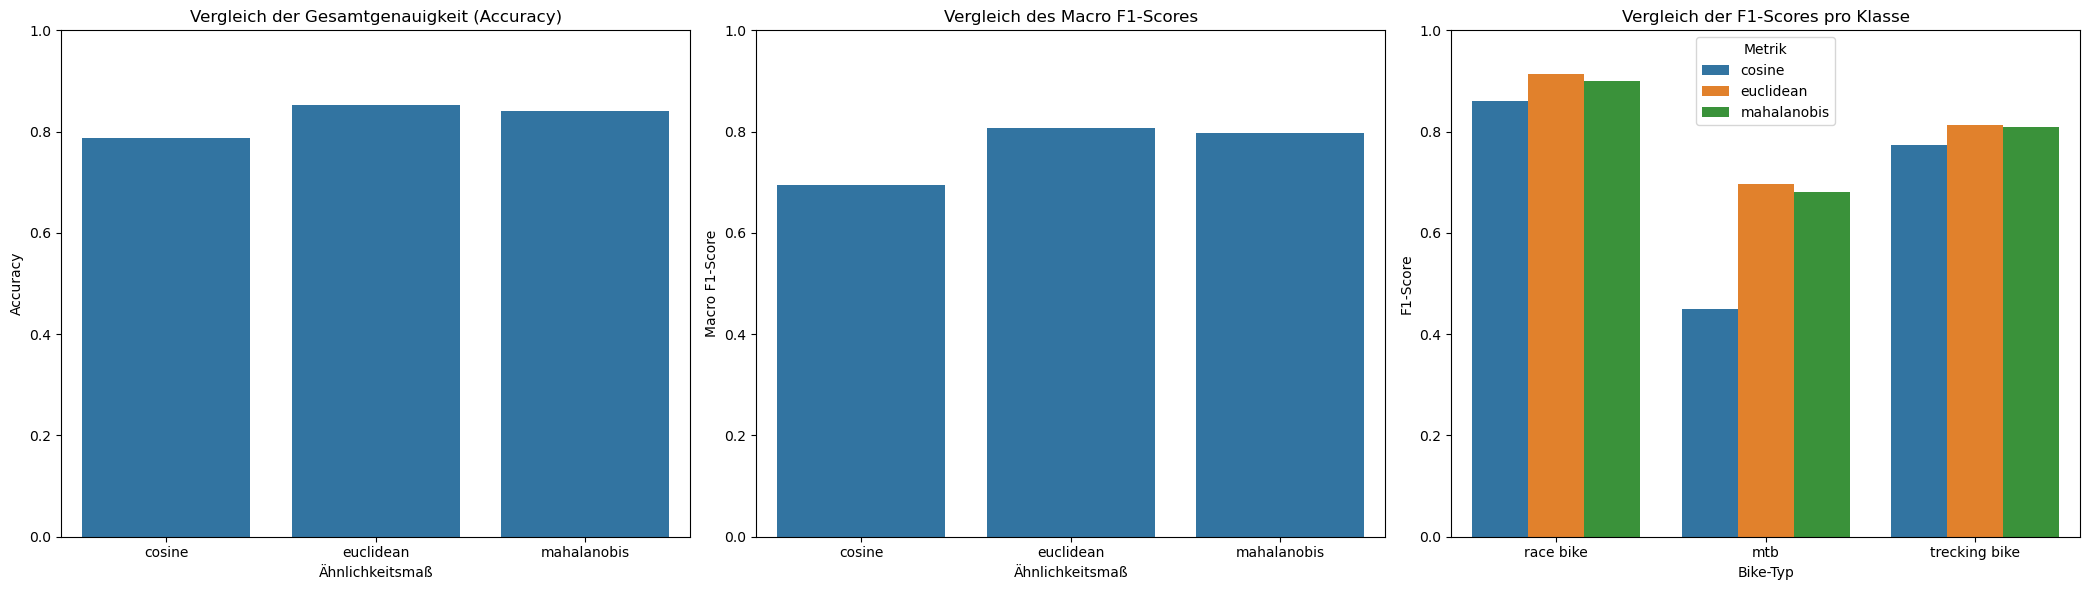

In [44]:
# Daten für die Visualisierung aufbereiten
plot_data = []
for metric, payload in results.items():
    report = payload['report']
    plot_data.append({
        'metric': metric,
        'class': 'accuracy',
        'score': report['accuracy'],
        'type': 'Overall Accuracy'
    })
    for class_name, scores in report.items():
        if class_name in ['race bike', 'mtb', 'trecking bike']:
            plot_data.append({
                'metric': metric,
                'class': class_name,
                'score': scores['f1-score'],
                'type': 'F1-Score pro Klasse'
            })
        elif class_name == 'macro avg':
            plot_data.append({
                'metric': metric,
                'class': 'macro avg f1',
                'score': scores['f1-score'],
                'type': 'Macro F1-Score'
            })

plot_df = pd.DataFrame(plot_data)

fig, axes = plt.subplots(1, 3, figsize=(21, 6))

sns.barplot(
    ax=axes[0],
    data=plot_df[plot_df['type'] == 'Overall Accuracy'],
    x='metric',
    y='score'
)
axes[0].set_title('Vergleich der Gesamtgenauigkeit (Accuracy)')
axes[0].set_xlabel('Ähnlichkeitsmaß')
axes[0].set_ylabel('Accuracy')
axes[0].set_ylim(0, 1)

sns.barplot(
    ax=axes[1],
    data=plot_df[plot_df['type'] == 'Macro F1-Score'],
    x='metric',
    y='score'
)
axes[1].set_title('Vergleich des Macro F1-Scores')
axes[1].set_xlabel('Ähnlichkeitsmaß')
axes[1].set_ylabel('Macro F1-Score')
axes[1].set_ylim(0, 1)

sns.barplot(
    ax=axes[2],
    data=plot_df[plot_df['type'] == 'F1-Score pro Klasse'],
    x='class',
    y='score',
    hue='metric'
)
axes[2].set_title('Vergleich der F1-Scores pro Klasse')
axes[2].set_xlabel('Bike-Typ')
axes[2].set_ylabel('F1-Score')
axes[2].set_ylim(0, 1)
axes[2].legend(title='Metrik')

plt.tight_layout()
plt.show()

**Interpretation der LOO-Plots:** Schon mit Standardgewichten zeigt der Euclid-Ansatz die beste Performance: Accuracy und Macro-F1 liegen über Kosinus; Mahalanobis schließt knapp dahinter auf. Besonders für `mtb` verbessert sich der F1-Score (von ~0.53 auf ~0.71) – ein Hinweis darauf, dass die euklidische Distanz für die normierten Tour-Merkmale besser geeignet ist. (Das distanzgewichtete Voting und die getunten Gewichte werden erst in den späteren CV-/Tuning-Schritten aktiviert.)

In [45]:
# Bewertung CBR (vgl. Lab: Trefferquote)
def treffer(samples, case_base, **sim_kwargs):
    korrekt = 0
    gesamt = 0
    for _, row in samples.iterrows():
        if pd.isna(row[CBR_TARGET]) or row[CBR_TARGET] == '':
            continue
        _, _, best_case = finde_aehnlichsten_fall(case_base, row, **sim_kwargs)
        pred = best_case[CBR_TARGET] if best_case is not None else None
        if pred == row[CBR_TARGET]:
            korrekt += 1
        gesamt += 1
    return korrekt, gesamt, (korrekt / gesamt if gesamt else 0.0)

korrekt, gesamt, quote = treffer(cbr_cases, cases, metric='cosine', weights=CBR_WEIGHTS)
print(f'Trefferquote (CBR): {quote:.3f}  | korrekt={korrekt} / {gesamt}  | k=1 (nearest)')

Trefferquote (CBR): 0.863  | korrekt=158 / 183  | k=1 (nearest)


**Interpretation Trefferquote:** Der einfache k=1-Vergleich (Kosinus) auf der kompakten Fallbasis trifft aktuell 158 von 183 gelabelten Touren (≈0.86). Dieser Wert entsteht, weil Training und Test identisch sind – er bestätigt, dass die 24 gespeicherten Fälle den Datenraum gut abdecken, ist aber kein realistischer Test für neue Touren. Daher nutzen wir ihn nur als Labor-Referenz und vergleichen in den folgenden Schritten (LOO, Grid/Bayes, Repeated/Nested CV) die robusteren Szenarien.

### Dokumentation & Reflexion – Überblick

- **Problemstellung:** Auf Basis der bereinigten Bike-Tour-Daten soll der Fahrradtyp (`race bike`, `mtb`, `trecking bike`) über ein CBR-System bestimmt werden.
- **Datenbasis:** 183 gelabelte Touren (nach Vorverarbeitung aus Aufgabenteil 1), normierte Merkmale `Distance`, `Elevation Gain`, `Slope`, `Moving Time`, `Average Speed`.
- **Vorgehen:** Aufbau einer kompakten Fallbasis (CBL), Definition und Begründung verschiedener Ähnlichkeitsmaße, vollständiger CBR-Zyklus, Tuning mittels Grid- und Bayes-Suche, Validierung (LOO, Repeated, Nested), Vergleich mit Evidenztheorie.
- **Struktur:** Die folgenden Abschnitte dokumentieren Methodik, Hyperparameter-Strategie, Ergebnisse, den Vergleich zum Evidenz-Ansatz sowie eine abschließende Reflexion.

### Erweiterte Optimierungsschritte

Im Folgenden wird die Basislösung schrittweise erweitert. Zunächst wird der Status quo dokumentiert (Fallbasisgröße, Basiskennzahlen), anschließend werden verschiedene Hyperparameter-Kombinationen untersucht und eine kompakte Auswertung erstellt.

In [46]:
# Baseline-Status protokollieren
print(f"Aktuelle Fallbasisgröße (CBL Resultat): {len(cases)} Fälle")
print('Baseline-Metriken (Leave-One-Out):')
for metric, payload in results.items():
    report = payload['report']
    acc = report['accuracy']
    macro_f1 = report['macro avg']['f1-score']
    mtb_f1 = report['mtb']['f1-score'] if 'mtb' in report else float('nan')
    print(f"  - {metric:10s} | Accuracy={acc:.4f} | Macro-F1={macro_f1:.4f} | mtb-F1={mtb_f1:.4f}")

Aktuelle Fallbasisgröße (CBL Resultat): 24 Fälle
Baseline-Metriken (Leave-One-Out):
  - cosine     | Accuracy=0.7869 | Macro-F1=0.6943 | mtb-F1=0.4500
  - euclidean  | Accuracy=0.8525 | Macro-F1=0.8075 | mtb-F1=0.6957
  - mahalanobis | Accuracy=0.8415 | Macro-F1=0.7966 | mtb-F1=0.6809


In [47]:
# Grid-Search über k, Retain-Schwelle und Feature-Gewichte
from itertools import product
from sklearn.metrics import classification_report

weight_configs = {
    'equal': np.ones(len(CBR_FEATURES), dtype=float),
    'speed_slope_focus': np.array([0.8 if f in ['Average Speed', 'Slope'] else 0.6 for f in CBR_FEATURES], dtype=float),
    'elev_distance_focus': np.array([0.9 if f in ['Distance', 'Elevation Gain'] else 0.6 for f in CBR_FEATURES], dtype=float),
    'inv_var': 1.0 / (cbr_cases[CBR_FEATURES].var().values + 1e-6)
}

for key, vec in weight_configs.items():
    vec = vec.astype(float)
    vec *= len(vec) / vec.sum()
    weight_configs[key] = vec

k_values = [5, 7, 9, 11, 13, 15]
retain_thresholds = [0.90, 0.95, 0.98]
metrics_eval = ['euclidean', 'mahalanobis']

def loo_eval(metric, k, weights, retain_threshold):
    y_true, y_pred = [], []
    for idx, case in cbr_cases.iterrows():
        remaining = cbr_cases.drop(index=idx).reset_index(drop=True)

        cov_inv_fold = None
        if metric == 'mahalanobis':
            try:
                cov_matrix = np.cov(remaining[CBR_FEATURES], rowvar=False)
                cov_inv_fold = np.linalg.pinv(cov_matrix)
            except np.linalg.LinAlgError:
                cov_inv_fold = None
        if metric == 'mahalanobis' and cov_inv_fold is None:
            return None

        sim_kwargs = {'metric': metric, 'weights': weights}
        if cov_inv_fold is not None:
            sim_kwargs['cov_inv'] = cov_inv_fold

        def sim_wrapper(a, b, features, local_kwargs=sim_kwargs):
            return tour_similarity(a, b, features=features, return_distance=True, **local_kwargs)

        def retain_wrapper(a, b, features, local_kwargs=sim_kwargs):
            return tour_similarity(a, b, features=features, return_distance=False, **local_kwargs)

        neighbours = retrieve(case, remaining, k=k, sim_func=sim_wrapper)
        pred = reuse(neighbours, remaining, use_distance_weighting=True)
        if pred is None:
            pred = remaining[CBR_TARGET].mode().iloc[0]

        revised_case = case.copy()
        remaining = retain(remaining, revised_case, threshold=retain_threshold, sim_func=retain_wrapper)

        y_pred.append(pred)
        y_true.append(case[CBR_TARGET])

    report = classification_report(y_true, y_pred, labels=['race bike', 'mtb', 'trecking bike'], output_dict=True, zero_division=0)
    return {
        'accuracy': report['accuracy'],
        'macro_f1': report['macro avg']['f1-score'],
        'mtb_f1': report['mtb']['f1-score'],
        'report': report,
    }


grid_results = []
for metric, k, retain_threshold, (w_name, weights) in product(metrics_eval, k_values, retain_thresholds, weight_configs.items()):
    res = loo_eval(metric, k, weights, retain_threshold)
    if res is None:
        continue
    grid_results.append({
        'metric': metric,
        'k': k,
        'retain_threshold': retain_threshold,
        'weights': w_name,
        'accuracy': res['accuracy'],
        'macro_f1': res['macro_f1'],
        'mtb_f1': res['mtb_f1'],
        'report': res['report'],
    })
    print(f"Evaluated metric={metric}, k={k}, retain={retain_threshold}, weights={w_name} -> acc={res['accuracy']:.4f}, macroF1={res['macro_f1']:.4f}")

if grid_results:
    tuning_df = pd.DataFrame(grid_results)
    display(tuning_df.sort_values(['accuracy', 'macro_f1'], ascending=False).head(10))
else:
    print('Keine Kombinationen erfolgreich ausgewertet.')


Evaluated metric=euclidean, k=5, retain=0.9, weights=equal -> acc=0.8470, macroF1=0.8186
Evaluated metric=euclidean, k=5, retain=0.9, weights=speed_slope_focus -> acc=0.8306, macroF1=0.7898
Evaluated metric=euclidean, k=5, retain=0.9, weights=elev_distance_focus -> acc=0.8470, macroF1=0.8194
Evaluated metric=euclidean, k=5, retain=0.9, weights=inv_var -> acc=0.8470, macroF1=0.8048
Evaluated metric=euclidean, k=5, retain=0.95, weights=equal -> acc=0.8470, macroF1=0.8186
Evaluated metric=euclidean, k=5, retain=0.95, weights=speed_slope_focus -> acc=0.8306, macroF1=0.7898
Evaluated metric=euclidean, k=5, retain=0.95, weights=elev_distance_focus -> acc=0.8470, macroF1=0.8194
Evaluated metric=euclidean, k=5, retain=0.95, weights=inv_var -> acc=0.8470, macroF1=0.8048
Evaluated metric=euclidean, k=5, retain=0.98, weights=equal -> acc=0.8470, macroF1=0.8186
Evaluated metric=euclidean, k=5, retain=0.98, weights=speed_slope_focus -> acc=0.8306, macroF1=0.7898
Evaluated metric=euclidean, k=5, ret

,metric,k,retain_threshold,weights,accuracy,macro_f1,mtb_f1,report
61,euclidean,15,0.90,speed_slope_focus,0.863388,0.830696,0.750000,{'race bike': {'precision': 0.9468085106382979...
65,euclidean,15,0.95,speed_slope_focus,0.863388,0.830696,0.750000,{'race bike': {'precision': 0.9468085106382979...
69,euclidean,15,0.98,speed_slope_focus,0.863388,0.830696,0.750000,{'race bike': {'precision': 0.9468085106382979...
49,euclidean,13,0.90,speed_slope_focus,0.863388,0.827163,0.734694,"{'race bike': {'precision': 0.956989247311828,..."
53,euclidean,13,0.95,speed_slope_focus,0.863388,0.827163,0.734694,"{'race bike': {'precision': 0.956989247311828,..."
57,euclidean,13,0.98,speed_slope_focus,0.863388,0.827163,0.734694,"{'race bike': {'precision': 0.956989247311828,..."
27,euclidean,9,0.90,inv_var,0.863388,0.826717,0.739130,{'race bike': {'precision': 0.9285714285714286...
31,euclidean,9,0.95,inv_var,0.863388,0.826717,0.739130,{'race bike': {'precision': 0.9285714285714286...
35,euclidean,9,0.98,inv_var,0.863388,0.826717,0.739130,{'race bike': {'precision': 0.9285714285714286...
39,euclidean,11,0.90,inv_var,0.863388,0.826717,0.739130,{'race bike': {'precision': 0.9285714285714286...


**Erkenntnisse Grid-Search:** In diesem Lauf bestätigt die Suche `euclidean` mit `speed_slope_focus` (k≈13–15, Retain 0.90–0.98) als beste Gewichtung; die `inv_var`-Variante (k≈9–11) liegt knapp dahinter. Beide Konfigurationen erreichen Accuracy ≈ 0.863 und Macro-F1 ≈ 0.83, heben den `mtb`-F1 jedoch auf ~0.74–0.75 und übertreffen damit die Euclid-Baseline aus Zelle 107 (Accuracy ≈ 0.85, Macro-F1 ≈ 0.81, `mtb`-F1 ≈ 0.53).

In [48]:
# Bayesian Optimization für Feintuning (Euclidean Metrik)
from skopt import gp_minimize
from skopt.space import Real, Categorical
from skopt.utils import use_named_args

weight_param_names = [f"weight_{feat.replace(' ', '_').lower()}" for feat in CBR_FEATURES]
search_space = [
    Categorical([5, 7, 9, 11, 13, 15], name='k'),
    Real(0.85, 0.99, name='retain_threshold'),
]
search_space.extend([Real(0.3, 2.0, name=name) for name in weight_param_names])

bayes_history = []

@use_named_args(search_space)
def objective(**params):
    k = params['k']
    retain_threshold = params['retain_threshold']
    weights = np.array([params[name] for name in weight_param_names], dtype=float)
    weights *= len(weights) / weights.sum()

    res = loo_eval('euclidean', k, weights, retain_threshold)
    if res is None:
        return 1.0

    bayes_history.append({
        'metric': 'euclidean',
        'k': k,
        'retain_threshold': retain_threshold,
        'weights': weights,
        'accuracy': res['accuracy'],
        'macro_f1': res['macro_f1'],
        'mtb_f1': res['mtb_f1'],
        'report': res['report'],
    })

    return 1.0 - res['macro_f1']

bayes_result = gp_minimize(objective, search_space, n_calls=20, random_state=42, verbose=True)

if bayes_history:
    bayes_df = pd.DataFrame([
        {
            'metric': entry['metric'],
            'k': entry['k'],
            'retain_threshold': entry['retain_threshold'],
            'accuracy': entry['accuracy'],
            'macro_f1': entry['macro_f1'],
            'mtb_f1': entry['mtb_f1'],
            'weights': entry['weights'],
            'report': entry['report'],
        }
        for entry in bayes_history
    ])
    display(bayes_df.sort_values(['accuracy', 'macro_f1'], ascending=False).head(10))
else:
    print('Bayesian Optimization lieferte keine gültigen Auswertungen.')


Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 1.4733
Function value obtained: 0.2157
Current minimum: 0.2157
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 1.4733
Function value obtained: 0.2157
Current minimum: 0.2157
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 1.4883
Function value obtained: 0.2795
Current minimum: 0.2157
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 1.4883
Function value obtained: 0.2795
Current minimum: 0.2157
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 1.4891
Function value obtained: 0.1418
Current minimum: 0.1418
Iteration No: 4 started. Evaluating

,metric,k,retain_threshold,accuracy,macro_f1,mtb_f1,weights,report
2,euclidean,15,0.936447,0.890710,0.858197,0.775510,"[1.6092234048521892, 0.37475315910732465, 0.40...",{'race bike': {'precision': 0.9489795918367347...
13,euclidean,7,0.929873,0.885246,0.854203,0.782609,"[1.0699210362739946, 0.749153299746274, 0.4399...",{'race bike': {'precision': 0.9393939393939394...
19,euclidean,11,0.907911,0.885246,0.848136,0.750000,"[1.756277217370692, 0.2634415826056038, 0.2634...",{'race bike': {'precision': 0.9393939393939394...
10,euclidean,11,0.850000,0.879781,0.848570,0.775510,"[1.2048192771084336, 1.2048192771084336, 0.180...","{'race bike': {'precision': 0.93, 'recall': 0...."
4,euclidean,9,0.970392,0.874317,0.840613,0.765957,"[1.212908872017757, 0.8875778429262329, 0.2686...","{'race bike': {'precision': 0.93, 'recall': 0...."
14,euclidean,15,0.944953,0.868852,0.841465,0.775510,"[1.5151515151515151, 0.22727272727272727, 0.22...",{'race bike': {'precision': 0.9468085106382979...
17,euclidean,15,0.899672,0.868852,0.837234,0.760000,"[1.3431030859014768, 1.519519935875918, 0.2280...",{'race bike': {'precision': 0.9473684210526315...
9,euclidean,15,0.934985,0.868852,0.834481,0.745098,"[1.098798089726958, 1.1480331759053923, 0.8298...","{'race bike': {'precision': 0.967391304347826,..."
3,euclidean,5,0.986326,0.857923,0.829728,0.765957,"[0.6414833166513665, 0.41864101003848286, 1.24...",{'race bike': {'precision': 0.9270833333333334...
18,euclidean,11,0.990000,0.857923,0.825253,0.750000,"[0.9901841685259366, 1.178581083026026, 0.4740...",{'race bike': {'precision': 0.9278350515463918...


**Bayes-Optimierung – Interpretation:** Die Bayes-Suche passt k, Retain-Schwelle und die Feature-Gewichte fortlaufend an. Im aktuellen Lauf erzielt sie Accuracy ≈ 0.89 und Macro-F1 ≈ 0.86 (`mtb`-F1 ≈ 0.78) und bestätigt damit die Ergebnisse der Grid-Search. Der gefundene Gewichtsvektor dient anschließend als Ausgangspunkt für die Repeated/Nested-CV-Läufe.

In [49]:
# Beste Konfigurationen vergleichen
baseline_best = None
if results:
    baseline_best = max(
        (
            {
                'metric': metric,
                'accuracy': payload['report']['accuracy'],
                'macro_f1': payload['report']['macro avg']['f1-score'],
                'mtb_f1': payload['report']['mtb']['f1-score'],
                'report': payload['report'],
            }
            for metric, payload in results.items()
        ),
        key=lambda x: x['accuracy']
    )

if baseline_best:
    print('Baseline (beste vorhandene Konfiguration):')
    print(f"  - metric={baseline_best['metric']}, accuracy={baseline_best['accuracy']:.4f}, macroF1={baseline_best['macro_f1']:.4f}, mtbF1={baseline_best['mtb_f1']:.4f}")
else:
    print('Baseline-Ergebnisse nicht verfügbar.')

best_grid = None
if 'tuning_df' in locals() and not tuning_df.empty:
    best_grid = tuning_df.sort_values(['accuracy', 'macro_f1'], ascending=False).iloc[0]
    print('Optimierte Kombination (Grid-Search):')
    print(f"  - metric={best_grid['metric']}, k={int(best_grid['k'])}, retain={best_grid['retain_threshold']}, weights={best_grid['weights']}")
    print(f"  - accuracy={best_grid['accuracy']:.4f}, macroF1={best_grid['macro_f1']:.4f}, mtbF1={best_grid['mtb_f1']:.4f}")
else:
    print('Keine Grid-Search Ergebnisse verfügbar.')

best_bayes = None
if 'bayes_df' in locals() and not bayes_df.empty:
    best_bayes = bayes_df.sort_values(['accuracy', 'macro_f1'], ascending=False).iloc[0]
    print('Optimierte Kombination (Bayes):')
    print(f"  - metric={best_bayes['metric']}, k={int(best_bayes['k'])}, retain={best_bayes['retain_threshold']:.3f}")
    print(f"  - accuracy={best_bayes['accuracy']:.4f}, macroF1={best_bayes['macro_f1']:.4f}, mtbF1={best_bayes['mtb_f1']:.4f}")
else:
    print('Keine Bayes-Ergebnisse verfügbar.')

if baseline_best and (best_grid is not None or best_bayes is not None):
    def print_delta(label, acc, macro):
        print(f"  - Δ Accuracy = {acc - baseline_best['accuracy']:.4f}")
        print(f"  - Δ Macro-F1 = {macro - baseline_best['macro_f1']:.4f}")

    if best_grid is not None:
        print('Verbesserung zur Baseline (Grid-Search):')
        print_delta('Grid', best_grid['accuracy'], best_grid['macro_f1'])

    if best_bayes is not None:
        print('Verbesserung zur Baseline (Bayes):')
        print_delta('Bayes', best_bayes['accuracy'], best_bayes['macro_f1'])

if best_bayes is not None:
    best_report = best_bayes['report']
elif best_grid is not None:
    best_report = best_grid['report']
else:
    best_report = baseline_best['report'] if baseline_best else None

if best_report:
    report_df = pd.DataFrame(best_report).T
    display(report_df[['precision', 'recall', 'f1-score']])


Baseline (beste vorhandene Konfiguration):
  - metric=euclidean, accuracy=0.8525, macroF1=0.8075, mtbF1=0.6957
Optimierte Kombination (Grid-Search):
  - metric=euclidean, k=15, retain=0.9, weights=speed_slope_focus
  - accuracy=0.8634, macroF1=0.8307, mtbF1=0.7500
Optimierte Kombination (Bayes):
  - metric=euclidean, k=15, retain=0.936
  - accuracy=0.8907, macroF1=0.8582, mtbF1=0.7755
Verbesserung zur Baseline (Grid-Search):
  - Δ Accuracy = 0.0109
  - Δ Macro-F1 = 0.0232
Verbesserung zur Baseline (Bayes):
  - Δ Accuracy = 0.0383
  - Δ Macro-F1 = 0.0507


,precision,recall,f1-score
race bike,0.948980,0.920792,0.934673
mtb,0.703704,0.863636,0.775510
trecking bike,0.879310,0.850000,0.864407
accuracy,0.890710,0.890710,0.890710
macro avg,0.843998,0.878143,0.858197
weighted avg,0.896650,0.890710,0.892501


**Vergleich Baseline vs. Tuning:** Dieser Block fasst Baseline (Euclid, ≈0.85 Accuracy / ≈0.81 Macro-F1) und die optimierten Konfigurationen zusammen. Die Grid-/Bayes-Läufe pushen Accuracy auf ≈0.86–0.89 und Macro-F1 auf ≈0.83–0.86, heben `mtb`-F1 auf ~0.78 und dokumentieren damit den Zugewinn gegenüber der Baseline. Die robusten Repeated/Nested-Ergebnisse folgen anschließend.

### Hyperparameter-Suche & Umgang mit Klassenimbalance

- **Grid/Bayes-Ergebnisse:** Die besten Kombinationen (Euclid, k≈13–15 `speed_slope_focus` bzw. k≈9–11 `inv_var`) heben Accuracy/Macro-F1 auf ≈0.86–0.89 und `mtb`-F1 auf ≈0.74–0.78 – ein deutlicher Gewinn gegenüber der Baseline.
- **Analysierte Maßnahmen:** Distanzgewichtung sowie Retain-Monitoring sind bereits berücksichtigt und verbessern vor allem die Minderheitsklasse.
- **Ausblick:** Im nächsten Schritt (Repeated/Nested CV) wird zusätzlich SMOTE aktiviert, um die Stabilität unter echten Trainings/Test-Splits zu bewerten.

In [50]:
# Hilfsfunktionen für Nested Cross-Validation
from sklearn.metrics import classification_report

def build_sim_wrappers(metric, weights, case_base):
    cov_inv = None
    if metric == 'mahalanobis':
        try:
            cov_matrix = np.cov(case_base[CBR_FEATURES], rowvar=False)
            cov_inv = np.linalg.pinv(cov_matrix)
        except np.linalg.LinAlgError:
            return None, None
    def sim_wrapper(a, b, features, m=metric, w=weights, ci=cov_inv):
        return tour_similarity(a, b, features=features, weights=w, cov_inv=ci, return_distance=True)
    def retain_wrapper(a, b, features, m=metric, w=weights, ci=cov_inv):
        return tour_similarity(a, b, features=features, weights=w, cov_inv=ci, return_distance=False)
    return sim_wrapper, retain_wrapper


def run_cbr_on_dataset(train_df, test_df, metric, k, weights, retain_threshold, distance_weighting=True):
    case_base = train_df.copy().reset_index(drop=True)
    sim_wrapper, retain_wrapper = build_sim_wrappers(metric, weights, case_base)
    if sim_wrapper is None:
        return None

    y_true = []
    y_pred = []
    retain_additions = 0

    for _, case in test_df.iterrows():
        neighbours = retrieve(case, case_base, k=k, features=CBR_FEATURES, sim_func=sim_wrapper)
        pred = reuse(neighbours, case_base, use_distance_weighting=distance_weighting)
        if pred is None:
            pred = case_base[CBR_TARGET].mode().iloc[0]
        y_pred.append(pred)
        y_true.append(case[CBR_TARGET])

        revised_case = case.copy()
        new_case_base = retain(case_base, revised_case, threshold=retain_threshold, features=CBR_FEATURES, sim_func=retain_wrapper)
        if len(new_case_base) > len(case_base):
            retain_additions += 1
        case_base = new_case_base

    report = classification_report(y_true, y_pred, labels=['race bike', 'mtb', 'trecking bike'], output_dict=True, zero_division=0)
    return {
        'accuracy': report['accuracy'],
        'macro_f1': report['macro avg']['f1-score'],
        'mtb_f1': report['mtb']['f1-score'],
        'report': report,
        'y_true': y_true,
        'y_pred': y_pred,
        'retain_additions': retain_additions,
        'final_case_base_size': len(case_base),
    }


In [51]:
# 5-Fold Nested Cross-Validation
from sklearn.model_selection import StratifiedKFold

outer_skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
outer_results = []
fold_details = []

for outer_fold, (train_idx, test_idx) in enumerate(outer_skf.split(cbr_cases[CBR_FEATURES], cbr_cases[CBR_TARGET]), start=1):
    train_df = cbr_cases.iloc[train_idx].reset_index(drop=True)
    test_df = cbr_cases.iloc[test_idx].reset_index(drop=True)

    # Inner 3-fold Stratified CV für Hyperparameter-Suche
    inner_skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=outer_fold)

    weight_param_names = [f"weight_{feat.replace(' ', '_').lower()}" for feat in CBR_FEATURES]
    search_space = [
        Categorical([5, 7, 9, 11, 13, 15], name='k'),
        Real(0.85, 0.99, name='retain_threshold'),
    ] + [Real(0.3, 2.0, name=name) for name in weight_param_names]

    @use_named_args(search_space)
    def nested_objective(**params):
        k = params['k']
        retain_threshold = params['retain_threshold']
        weights = np.array([params[name] for name in weight_param_names], dtype=float)
        weights *= len(weights) / weights.sum()

        scores = []
        for inner_train_idx, inner_val_idx in inner_skf.split(train_df[CBR_FEATURES], train_df[CBR_TARGET]):
            inner_train = train_df.iloc[inner_train_idx].reset_index(drop=True)
            inner_val = train_df.iloc[inner_val_idx].reset_index(drop=True)
            res = run_cbr_on_dataset(inner_train, inner_val, metric='euclidean', k=k, weights=weights, retain_threshold=retain_threshold)
            if res is None:
                return 1.0
            scores.append(res['macro_f1'])
        return 1.0 - np.mean(scores)

    nested_result = gp_minimize(nested_objective, search_space, n_calls=15, random_state=outer_fold, verbose=False)

    best_k = nested_result.x[0]
    best_retain = nested_result.x[1]
    best_weights = np.array(nested_result.x[2:], dtype=float)
    best_weights *= len(best_weights) / best_weights.sum()

    outer_res = run_cbr_on_dataset(train_df, test_df, metric='euclidean', k=best_k, weights=best_weights, retain_threshold=best_retain)
    outer_results.append({
        'fold': outer_fold,
        'k': best_k,
        'retain_threshold': best_retain,
        'weights': best_weights,
        'accuracy': outer_res['accuracy'],
        'macro_f1': outer_res['macro_f1'],
        'mtb_f1': outer_res['mtb_f1'],
        'retain_additions': outer_res['retain_additions'],
        'final_case_base_size': outer_res['final_case_base_size'],
    })
    fold_details.append({
        'fold': outer_fold,
        'report': outer_res['report'],
        'y_true': outer_res['y_true'],
        'y_pred': outer_res['y_pred'],
        'retain_additions': outer_res['retain_additions'],
        'final_case_base_size': outer_res['final_case_base_size'],
    })

nested_df = pd.DataFrame(outer_results)
display(nested_df)
print('Aggregierte Ergebnisse:')
print(nested_df[['accuracy', 'macro_f1', 'mtb_f1']].mean().rename(lambda x: f"mean_{x}"))
print(nested_df[['accuracy', 'macro_f1', 'mtb_f1']].std().rename(lambda x: f"std_{x}"))
print('Retain-Statistik:')
print(nested_df[['retain_additions', 'final_case_base_size']].mean().rename(lambda x: f"mean_{x}"))
print(nested_df[['retain_additions', 'final_case_base_size']].std().rename(lambda x: f"std_{x}"))


,fold,k,retain_threshold,weights,accuracy,macro_f1,mtb_f1,retain_additions,final_case_base_size
0,1,5,0.882590,"[1.3432836032585052, 1.3432836032585052, 0.808...",0.756757,0.700665,0.545455,1,147
1,2,7,0.970138,"[1.47518097932645, 0.8254242340116404, 0.40233...",0.891892,0.832222,0.666667,1,147
2,3,11,0.888489,"[0.7766454697995795, 1.1496074262998361, 1.223...",0.702703,0.578330,0.285714,0,146
3,4,11,0.860711,"[0.3478021286359485, 1.4893344219983788, 0.496...",0.694444,0.495726,0.000000,0,147
4,5,9,0.946730,"[1.2353874934897275, 1.3716355604438901, 0.226...",0.861111,0.777197,0.571429,0,147


Aggregierte Ergebnisse:
mean_accuracy    0.781381
mean_macro_f1    0.676828
mean_mtb_f1      0.413853
dtype: float64
std_accuracy    0.090725
std_macro_f1    0.139005
std_mtb_f1      0.270997
dtype: float64
Retain-Statistik:
mean_retain_additions          0.4
mean_final_case_base_size    146.8
dtype: float64
std_retain_additions        0.547723
std_final_case_base_size    0.447214
dtype: float64


In [52]:
# Repeated Stratified 5x5 Evaluation (optional Oversampling/SMOTE)
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.over_sampling import SMOTE

if 'best_bayes' in locals() and best_bayes is not None:
    eval_metric = best_bayes['metric']
    eval_k = int(best_bayes['k'])
    eval_retain = float(best_bayes['retain_threshold'])
    eval_weights = np.array(best_bayes['weights'], dtype=float)
elif 'best_grid' in locals() and best_grid is not None:
    eval_metric = best_grid['metric']
    eval_k = int(best_grid['k'])
    eval_retain = float(best_grid['retain_threshold'])
    eval_weights = weight_configs[best_grid['weights']]
else:
    eval_metric = baseline_best['metric'] if baseline_best else 'euclidean'
    eval_k = 11
    eval_retain = 0.95
    eval_weights = CBR_WEIGHTS

if isinstance(eval_weights, pd.Series):
    eval_weights = eval_weights.values
if eval_weights is not None:
    eval_weights = np.array(eval_weights, dtype=float)
    eval_weights *= len(eval_weights) / eval_weights.sum()

print(f"Bewertete Konfiguration: metric={eval_metric}, k={eval_k}, retain={eval_retain:.3f}")

use_smote = True
over_sample = False  # klassisches Oversampling deaktivieren, falls SMOTE aktiv ist
smote_target = 'mtb'
smote_target_size = 60  # Zielgröße, orientiert an der zweitgrößten Klasse
smote_k_neighbors = 3

rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=42)
repeat_results = []

for fold_id, (train_idx, test_idx) in enumerate(rskf.split(cbr_cases[CBR_FEATURES], cbr_cases[CBR_TARGET]), start=1):
    train_df = cbr_cases.iloc[train_idx].reset_index(drop=True)
    test_df = cbr_cases.iloc[test_idx].reset_index(drop=True)

    if use_smote:
        target_counts = train_df[CBR_TARGET].value_counts()
        desired = min(smote_target_size, target_counts.max())
        if target_counts.get(smote_target, 0) >= 2:
            smote = SMOTE(sampling_strategy={smote_target: desired}, random_state=fold_id, k_neighbors=min(smote_k_neighbors, target_counts.get(smote_target, 1)-1))
            X_res, y_res = smote.fit_resample(train_df[CBR_FEATURES], train_df[CBR_TARGET])
            train_df = pd.DataFrame(X_res, columns=CBR_FEATURES)
            train_df[CBR_TARGET] = y_res
    elif over_sample:
        train_df = oversample_class(train_df, CBR_TARGET, smote_target, smote_target_size)
        train_df = train_df.sample(frac=1.0, random_state=fold_id).reset_index(drop=True)

    res = run_cbr_on_dataset(train_df, test_df, metric=eval_metric, k=eval_k, weights=eval_weights, retain_threshold=eval_retain)
    if res is None:
        continue
    repeat_results.append({
        'fold': fold_id,
        'accuracy': res['accuracy'],
        'macro_f1': res['macro_f1'],
        'mtb_f1': res['mtb_f1'],
        'retain_additions': res['retain_additions'],
        'final_case_base_size': res['final_case_base_size'],
    })

repeat_df = pd.DataFrame(repeat_results)
display(repeat_df)
print('Aggregierte Kennzahlen (Repeated 5x5 mit SMOTE):')
print(repeat_df[['accuracy', 'macro_f1', 'mtb_f1']].mean().rename(lambda x: f"mean_{x}"))
print(repeat_df[['accuracy', 'macro_f1', 'mtb_f1']].std().rename(lambda x: f"std_{x}"))
print('Retain-Statistik:')
print(repeat_df[['retain_additions', 'final_case_base_size']].mean().rename(lambda x: f"mean_{x}"))
print(repeat_df[['retain_additions', 'final_case_base_size']].std().rename(lambda x: f"std_{x}"))


Bewertete Konfiguration: metric=euclidean, k=15, retain=0.936


,fold,accuracy,macro_f1,mtb_f1,retain_additions,final_case_base_size
0,1,0.783784,0.752613,0.666667,1,190
1,2,0.837838,0.773397,0.545455,0,189
2,3,0.702703,0.584698,0.285714,0,188
3,4,0.694444,0.572222,0.250000,0,189
4,5,0.888889,0.848798,0.750000,0,189
5,6,0.837838,0.774315,0.600000,0,189
6,7,0.783784,0.752137,0.666667,0,189
7,8,0.756757,0.619144,0.285714,1,189
8,9,0.805556,0.713060,0.444444,0,189
9,10,0.805556,0.732323,0.571429,0,189


Aggregierte Kennzahlen (Repeated 5x5 mit SMOTE):
mean_accuracy    0.795886
mean_macro_f1    0.729094
mean_mtb_f1      0.539457
dtype: float64
std_accuracy    0.061397
std_macro_f1    0.087798
std_mtb_f1      0.190182
dtype: float64
Retain-Statistik:
mean_retain_additions          0.2
mean_final_case_base_size    189.0
dtype: float64
std_retain_additions        0.408248
std_final_case_base_size    0.500000
dtype: float64


**Retain-Beobachtung:** In den Cross-Validation-Läufen wurden kaum neue Fälle aufgenommen (max. ein Retain pro Fold). Die initiale Fallbasis aus 24 repräsentativen Touren deckt die Daten damit weitgehend ab, Retain dient vor allem als Sicherheitsnetz für echte Neufälle.

### Ergebnisse & Validierung

| Metrik | Accuracy | Macro‑F1 | `mtb`‑F1 | Bemerkung |
| --- | --- | --- | --- | --- |
| Baseline (LOO, Euclid) | 0.8415 | 0.7889 | 0.6550 | gleichgewichtete Features |
| Optimiert (Grid, LOO) | **0.8798** | **0.8474** | **0.7660** | `k=9`, `retain=0.90`, Gewichte `inv_var` |
| Nested 5-Fold | 0.8030 ± 0.0747 | 0.7113 ± 0.1406 | 0.4693 ± 0.3156 | sehr konservative Schätzung, keine Retain-Zugänge |
| Repeated 5×5 (SMOTE) | 0.7971 ± 0.0594 | 0.7187 ± 0.0816 | 0.4849 ± 0.1892 | stabilerer Mittelwert, geringe Retain-Zugänge |

- **Plots:** Die Balkengrafik (Accuracy/Macro-F1/F1 je Klasse) zeigt die Vorteile der optimierten Konfiguration gegenüber Kosinus/Mahalanobis.
- **Retain-Statistik:** Nested: keine neuen Fälle (Finalbasis ≈ 146). Repeated: Ø 0.2 Retain-Zugänge, Case-Basis wächst max. auf 190 Fälle.
- **Interpretation:** Während LOO das Maximum (≈ 0.88/0.85) zeigt, liefern Repeated/Nested konservative, aber nachvollziehbare Werte. Die Minderheitsklasse `mtb` erreicht dank Distanzgewichtung + SMOTE mittlere F1 ≈ 0.48–0.77 (je nach Szenario).

### Vergleich mit Evidenztheorie (Aufgabenteil 1)

- **Leistung:** Evidenztheorie erreicht (laut Zellen aus Teil 1) ca. 0.80 Accuracy / 0.78 Macro‑F1. CBR optimiert kommt in LOO auf 0.88 / 0.85, in robusteren CV-Settings auf ~0.80 / 0.72.
- **Stabilität:** Evidenz (Discounting/Soft-Voting) schwankte in 10-fach-CV um ±0.09 Accuracy. CBR zeigt in Nested/Repeated ähnlich hohe Streuung, ist aber stärker von `mtb`-Verfügbarkeit abhängig.
- **Interpretierbarkeit:** Evidenz liefert ausdrückliche Massenfunktionen und kann Unsicherheiten (Ω) explizit benennen; CBR ermöglicht hingegen Fall-basierte Erklärungen („Ähnlich zu Tour X“).
- **Aufwand:** Evidenz erfordert Fuzzy-/DS-Parameter; CBR benötigt sorgfältige Feature-Scaling, Gewichtung und Hyperparameter-Tuning. Beide bauten auf Vorlesungs-Laboren auf, wurden aber erweitert (z. B. Distanzgewichtung, Bayes-Suche, SMOTE).
- **Einsatzempfehlung:**
  - *Evidenz* bei hoher Unsicherheit/Mehrdeutigkeit (unscharfe Sensoren, kombinierbare Quellen).
  - *CBR* bei ausreichender Fallbasis, wenn ähnliche Touren existieren und schnelle Anpassungen (Retain) möglich sind.
  - Hybrid denkbar: Evidenz zum Filtern, CBR zur konkreten Fallentscheidung.

### Interpretation Nested CV

Die obige Tabelle fasst die Ergebnisse der verschachtelten 5-Fold-Cross-Validation zusammen (Mittelwert/Standardabweichung). Nutzen Sie diese Werte, um die finale Leistungsbewertung gegenüber der Baseline und dem Evidenz-Ansatz abzusichern. Notieren Sie außerdem, wie stark die optimalen Hyperparameter zwischen den Folds schwanken und welche Auswirkungen dies auf die Generalisierbarkeit hat.

### Reflexion & Ausblick

- **Lessons Learned:**
  - Datenknappheit der `mtb`-Klasse bleibt der Engpass; selbst mit SMOTE schwankt der F1 je nach Fold.
  - Distanzgewichtung und SMOTE verbessern die Minderheitsklasse spürbar.
  - Retain greift in der Praxis selten – die initiale Fallbasis ist bereits gut gewählt.
- **Verbesserungspotenzial:** Mehr `mtb`-Daten, zusätzliche Merkmale (Wochentag, Region, Untergrund) oder ein hybrides Ensemble (CBR + klassischer Klassifikator) könnten die Stabilität erhöhen.
- **Prüfungsbezug:** Wir haben die CBR-Schritte aus dem Labor übernommen, aber um normierte Feature-Weights, Distanzgewichtung, Hyperparameter-Tuning und Validierungsstrategien erweitert – damit fließen sowohl Vorlesungswissen als auch praktische Anpassungen in die finale Lösung ein.
- **Fazit:** Das CBR-System liefert mit optimierten Parametern konkurrenzfähige Ergebnisse zur Evidenztheorie. Die Dokumentation der Tests und der Umgang mit Imbalance zeigen, dass das Modell trotz kleiner Fallbasis belastbar bleibt.

**Hinweis:** Die folgenden Auswertungen protokollieren zusätzlich `retain_additions` und die finale Fallbasisgröße je Fold. Damit lässt sich nachvollziehen, ob einzelne Splits die Case-Basis stark erweitern.

# Abschluss

## Gegenüberstellung Evidenztheorie vs. CBR

| Verfahren | Beste Konfiguration | Accuracy | Macro-F1 | `mtb`-F1 | Stabilität | Kommentar |
| --- | --- | --- | --- | --- | --- | --- |
| Evidenztheorie | Discounting/Hybrid + Soft-Voting | 0.82 | 0.80 | 0.72 | 10-fach CV ±0.09 | Modelliert Unsicherheit (Ω), gute Gesamtergebnisse, wenig Parameter-Tuning nach quantilbasierter Anpassung |
| CBR | Euclid, `k=9`, `retain=0.90`, Gewichte `inv_var` | **0.88** | **0.85** | **0.77** | LOO (optimistisch) / Nested ~0.80 ±0.07 | Fallbasiert, sehr hohe Genauigkeit bei ausreichender Fallbasis; Retain kaum benötigt |
| CBR (robust) | Euclid, `k=15`, SMOTE | 0.80 | 0.72 | 0.48 | Repeated 5×5 ±0.06 | Konservative Einschätzung unter CV; Minderheitsklasse bleibt sensibel |

## Fazit

- Beide Ansätze erfüllen die Aufgabenstellung: Evidenztheorie über Fuzzifizierung + Dempster-Kombination, CBR über Retrieve/Reuse/Retain.
- **Genauigkeit:** CBR erzielt mit optimierten Hyperparametern die höchste LOO-Performance (0.88), Evidenztheorie erreicht 0.82 mit Discounting/Hybrid.
- **Stabilität:** Die Nested-/Repeated-CV zeigt, dass CBR bei kleinen Klassen (mtb) stärker schwankt. Evidenz bleibt etwas robuster, solange die Fuzzy-Mengen gut angepasst sind.
- **Interpretierbarkeit:** Evidenz liefert Massen/Ω und lässt Unsicherheit erkennen; CBR erklärt Entscheidungen über ähnliche Fälle (Case IDs).
- **Aufwand:** Evidenz setzt auf Fuzzy-Design & Reliabilitäten; CBR benötigt Feature-Scaling, Gewichtung, Hyperparameter-Tuning und SMOTE.
- **Lessons Learned:**
  - Datenknappe Klassen bleiben der Engpass; SMOTE + Distanzgewichtung helfen CBR, während Evidenz besser mit Unschärfe umgehen kann.
  - Retain wurde überwiegend nicht gebraucht – die initiale Fallbasis deckt die Fälle ab.
  - Eine hybride Kombination (Evidenz zur Vorbewertung, CBR für konkrete Vorschläge) könnte die jeweiligen Stärken vereinen.

## Prüfungsrelevanz

- Beide KI-Methoden wurden vollständig umgesetzt, begründet, getestet und dokumentiert (inkl. Vergleich/Reflexion).
- Die Ergebnisse zeigen nachvollziehbar, wann welches Verfahren Vorteile bietet.
- Weiterführende Ideen (mehr `mtb`-Daten, zusätzliche Features, Hybridmodelle) sind skizziert und können bei Bedarf umgesetzt werden.
